## **Relevante Python Bibliotheken importieren**

In [ ]:
!python --version

Python 3.12.12


## Import relevanter Bibliotheken

In [3]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import numpy as np
import platform
from collections import Counter




# **Evaluation der Ergebnisse aus der KI-gestützen Aspekt basierten Sentimentanalyse**

## **Funktion für die Evaluation der Modelle**

In [17]:
# Laden
def load_gold_and_ki_results(gold_path, ki_jsonl_path):
    gold = pd.read_csv(gold_path, sep=';', encoding='utf-8-sig')
    gold = gold.dropna(how='all').reset_index(drop=True)

    with open(ki_jsonl_path, 'r', encoding='utf-8') as f:
        ki_data = [json.loads(line) for line in f if line.strip()]
    ki_dict = {item['id']: item for item in ki_data}

    return gold, ki_dict


# Haupt-Evaluationsfunktion  gibt Metriken und Plots zurück
def evaluate_model(gold_df, ki_dict, model_name="KI-Modell", aspects=None):

    if aspects is None:
        aspects = ["Personal", "Wohnen", "Hygiene", "Verpflegung", "Sicherheit"]

    y_true, y_pred = [], []

    for _, row in gold_df.iterrows():
        try:
            gid = int(row['id'])
            if gid not in ki_dict:
                continue

            for asp in aspects:
                # Goldstandard bereinigen
                true = str(row[asp]).strip().lower()
                if true in {"", "nan", "null", "none"}:
                    true = "null"

                # KI-Vorhersage
                pred = ki_dict[gid].get(asp, "null")
                if pred is None or pred == "":
                    pred = "null"
                else:
                    pred = str(pred).strip().lower()

                y_true.append(true)
                y_pred.append(pred)
        except:
            continue

    print(f"Verglichene Instanzen: {len(y_true)}\n")
    print(f"{model_name} vs. manueller Goldstandard\n")

    if len(y_true) == 0:
        print("Keine Daten zum Vergleichen!")
        return

    # Metriken berechnen
    acc = accuracy_score(y_true, y_pred)
    macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    report = classification_report(y_true, y_pred, output_dict=True, digits=4)

    print(f"Accuracy:        {acc:.4f}")
    print(f"Macro Precision: {macro_p:.4f}")
    print(f"Macro Recall:    {macro_r:.4f}")
    print(f"Macro F1:        {macro_f:.4f}")
    print(f"Micro F1:        {acc:.4f}\n")
    print("Detail pro Klasse:")
    print(classification_report(y_true, y_pred, digits=4))

    # ####### Konfusionsmatrix #######
    labels = ["negativ", "null", "positiv"]
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt=".3f", cmap="Blues",
                xticklabels=labels, yticklabels=labels, cbar=False)
    plt.ylabel("Goldstandard (True)")
    plt.xlabel(f"{model_name} (Predicted)")
    plt.title(f"Konfusionsmatrix – {model_name}")
    plt.tight_layout()
    plt.show()

    # ####### Precision/Recall/F1 pro Klasse ######
    df_metrics = pd.DataFrame({
        'Precision': [report[l]['precision'] for l in labels],
        'Recall':    [report[l]['recall'] for l in labels],
        'F1-Score':  [report[l]['f1-score'] for l in labels]
    }, index=labels)

    df_metrics.T.plot(kind="bar", figsize=(8,5), cmap="Set2", width=0.8)
    plt.title(f"Precision, Recall und F1-Score pro Klasse – {model_name}")
    plt.ylabel("Score")
    plt.xlabel("Metrik")
    plt.xticks(rotation=0)
    plt.ylim(0, 1)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.legend(title="Klasse")
    plt.tight_layout()
    plt.show()

    # ####### Gesamtübersicht Accuracy + Macro-F1 #######
    plt.figure(figsize=(5,5))
    plt.scatter(["Accuracy"], [acc], s=400, c="#2E86AB", label="Accuracy", zorder=5)
    plt.scatter(["Macro-F1"], [macro_f], s=400, c="#A23B72", label="Macro-F1", marker="D", zorder=5)
    plt.title(f"Gesamtleistung – {model_name}")
    plt.ylabel("Score")
    plt.ylim(0.65, 0.95)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.legend()

    for name, val in [("Accuracy", acc), ("Macro-F1", macro_f)]:
        plt.text(name, val + 0.008, f"{val:.4f}", ha="center", fontsize=12, fontweight="bold")

    plt.tight_layout()
    plt.show()

## **Funktion für Evaluation der Modelle mit Einsatz von QAIE**

In [26]:
# Funktion: Majority-Vote aus augmentierten JSONL-Dateien berechnen
def load_and_aggregate_predictions(jsonl_path: str, aspects=None, tie_breaker="null"):

    if aspects is None:
        aspects = ["Personal", "Wohnen", "Hygiene", "Verpflegung", "Sicherheit"]

    with open(jsonl_path, 'r', encoding='utf-8') as f:
        aug_data = [json.loads(line) for line in f if line.strip()]

    # Sammle alle Vorhersagen pro id und Aspekt
    pred_dict = {}
    for entry in aug_data:
        gid = entry['id']
        if gid not in pred_dict:
            pred_dict[gid] = {asp: [] for asp in aspects}

        for asp in aspects:
            val = entry.get(asp, "null")
            if val is None or val == "":
                val = "null"
            pred_dict[gid][asp].append(str(val).strip().lower())

    # Majority Vote mit Tie-Breaker
    final_pred = {}
    for gid, votes in pred_dict.items():
        final_pred[gid] = {}
        for asp, vote_list in votes.items():
            if not vote_list:
                final_pred[gid][asp] = "null"
                continue
            c = Counter(vote_list)
            winner, count = c.most_common(1)[0]
            # Bei Gleichstand → tie_breaker gewinnt
            if list(c.values()).count(count) > 1 and tie_breaker in c:
                winner = tie_breaker
            final_pred[gid][asp] = winner

    return final_pred


# Evaluations- und Visualisierungsfunktion
def evaluate_majority_vote(
    gold_df: pd.DataFrame,
    aggregated_predictions: dict,
    model_name: str = "KI-Modell mit Datenaugmentation",
    aspects=None
):
    # Vergleicht Majority-Vote-Vorhersagen mit Goldstandard und zeigt alle Plots.
    if aspects is None:
        aspects = ["Personal", "Wohnen", "Hygiene", "Verpflegung", "Sicherheit"]

    y_true, y_pred = [], []

    for _, row in gold_df.iterrows():
        gid = int(row['id'])
        if gid not in aggregated_predictions:
            continue

        for asp in aspects:
            true = str(row[asp]).strip().lower()
            if true in {"", "nan", "null", "none"}:
                true = "null"
            pred = aggregated_predictions[gid].get(asp, "null")

            y_true.append(true)
            y_pred.append(pred)

    print(f"Verglichene Instanzen: {len(y_true)}\n")
    print(f"{model_name} vs. manueller Goldstandard\n")

    if len(y_true) == 0:
        print("Keine Daten zum Vergleichen!")
        return

    # Metriken
    acc = accuracy_score(y_true, y_pred)
    macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    report = classification_report(y_true, y_pred, output_dict=True, digits=4)

    print(f"Accuracy:        {acc:.4f}")
    print(f"Macro Precision: {macro_p:.4f}")
    print(f"Macro Recall:    {macro_r:.4f}")
    print(f"Macro F1:        {macro_f:.4f}")
    print(f"Micro F1:        {acc:.4f}\n")
    print("Detail pro Klasse:")
    print(classification_report(y_true, y_pred, digits=4))

    labels = ["negativ", "null", "positiv"]
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')

    # ####### Konfusionsmatrix #######
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt=".3f", cmap="Blues",
                xticklabels=labels, yticklabels=labels, cbar=False)
    plt.ylabel("Goldstandard (True)")
    plt.xlabel(f"{model_name} (Predicted)")
    plt.title(f"Konfusionsmatrix – {model_name}")
    plt.tight_layout()
    plt.show()

    # ####### Precision/Recall/F1 pro Klasse #######
    df_metrics = pd.DataFrame({
        'Precision': [report[l]['precision'] for l in labels],
        'Recall':    [report[l]['recall'] for l in labels],
        'F1-Score':  [report[l]['f1-score'] for l in labels]
    }, index=labels)

    df_metrics.T.plot(kind="bar", figsize=(8,5), cmap="Set2", width=0.8)
    plt.title(f"Precision, Recall und F1-Score pro Klasse – {model_name}")
    plt.ylabel("Score")
    plt.xlabel("Metrik")
    plt.xticks(rotation=0)
    plt.ylim(0, 1)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.legend(title="Klasse")
    plt.tight_layout()
    plt.show()

    # ######## Gesamtübersicht #######
    plt.figure(figsize=(5,5))
    plt.scatter(["Accuracy"], [acc], s=400, c="#2E86AB", label="Accuracy", zorder=5)
    plt.scatter(["Macro-F1"], [macro_f], s=400, c="#A23B72", label="Macro-F1", marker="D", zorder=5)
    plt.title(f"Gesamtleistung – {model_name}")
    plt.ylabel("Score")
    plt.ylim(0.6, 0.95)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.legend()
    for name, val in [("Accuracy", acc), ("Macro-F1", macro_f)]:
        plt.text(name, val + 0.008, f"{val:.4f}", ha="center", fontsize=12, fontweight="bold")
    plt.tight_layout()
    plt.show()



## **XAI**

## Goldstandard vs Single Run mit Few-Shot Prompting

Verglichene Instanzen: 490

Grok 3 Mini (Few-Shot) vs. manueller Goldstandard

Accuracy:        0.8122
Macro Precision: 0.7730
Macro Recall:    0.7987
Macro F1:        0.7842
Micro F1:        0.8122

Detail pro Klasse:
              precision    recall  f1-score   support

     negativ     0.6375    0.7500    0.6892        68
        null     0.8615    0.8205    0.8405       273
     positiv     0.8200    0.8255    0.8227       149

    accuracy                         0.8122       490
   macro avg     0.7730    0.7987    0.7842       490
weighted avg     0.8178    0.8122    0.8141       490



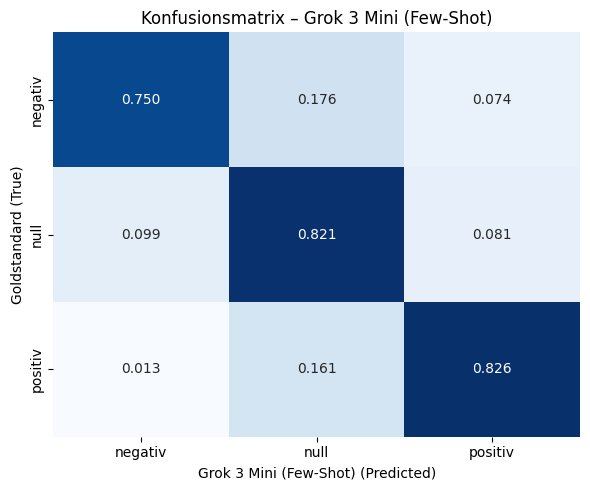

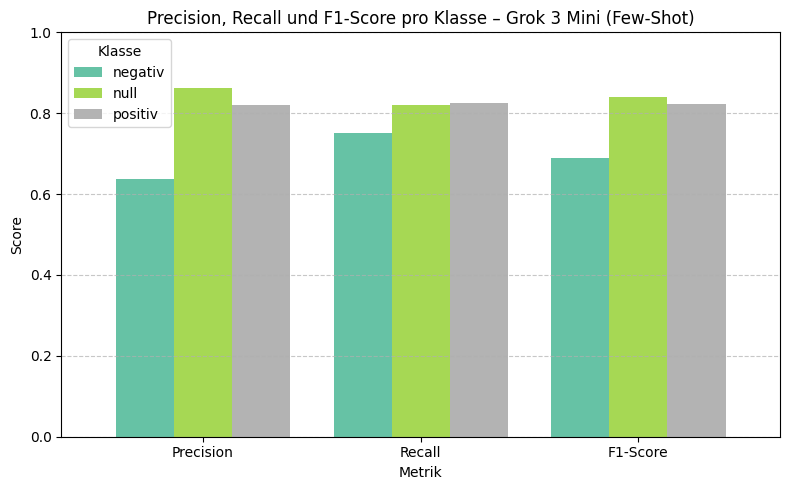

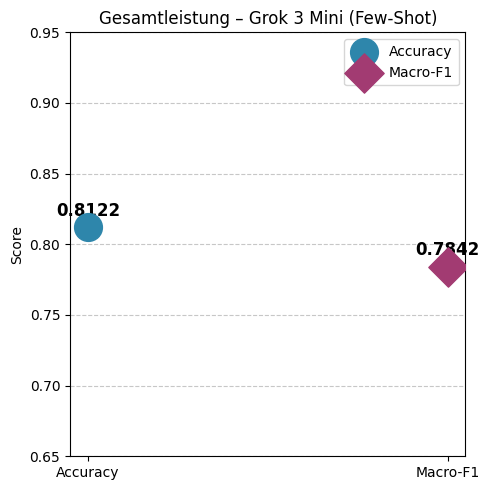

In [18]:
gold, ki_dict = load_gold_and_ki_results(
    "/content/drive/MyDrive/Projekt_ABSA/goldstandard_clean.csv",
    "/content/drive/MyDrive/Projekt_ABSA/absa_ki_g1.jsonl"   # wird nur zum Laden benötigt
)

# Funktionsaufruf
evaluate_model(gold, ki_dict, model_name="Grok 3 Mini (Few-Shot)")

## Goldstandard vs Single Run mit neuem Few-Shot Prompt

Verglichene Instanzen: 490

Grok 3 Mini (neuer Few-Shot) vs. manueller Goldstandard

Accuracy:        0.7061
Macro Precision: 0.6820
Macro Recall:    0.7569
Macro F1:        0.7025
Micro F1:        0.7061

Detail pro Klasse:
              precision    recall  f1-score   support

     negativ     0.5743    0.8529    0.6864        68
        null     0.8284    0.6190    0.7086       273
     positiv     0.6432    0.7987    0.7126       149

    accuracy                         0.7061       490
   macro avg     0.6820    0.7569    0.7025       490
weighted avg     0.7368    0.7061    0.7067       490



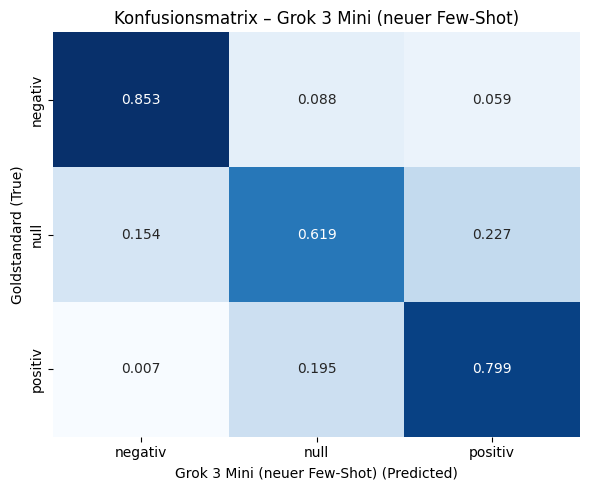

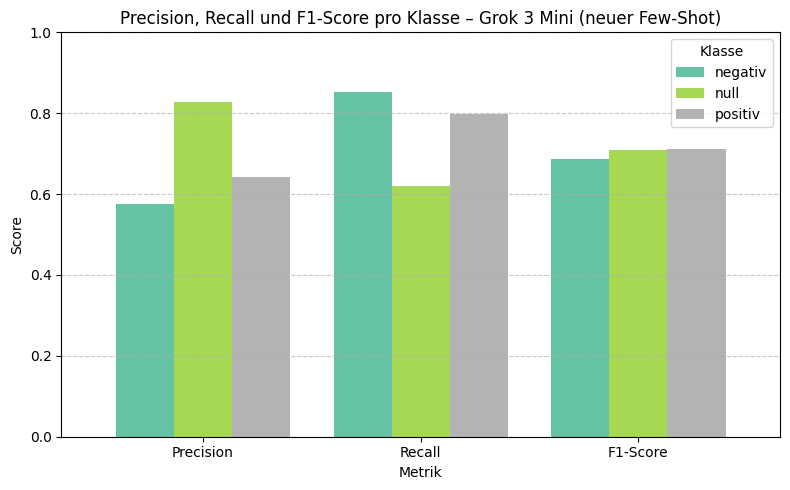

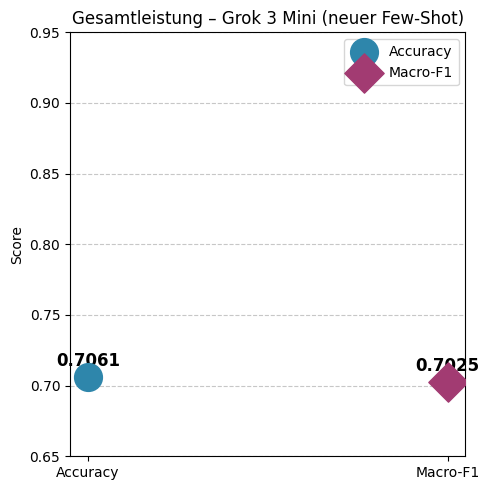

In [19]:
gold, ki_dict = load_gold_and_ki_results(
    "/content/drive/MyDrive/Projekt_ABSA/goldstandard_clean.csv",
    "/content/drive/MyDrive/Projekt_ABSA/grok_optimize_ev.jsonl"   # wird nur zum Laden benötigt
)

# Funktionsaufruf
evaluate_model(gold, ki_dict, model_name="Grok 3 Mini (neuer Few-Shot)")

## Goldstandard vs ABSA mit Einsatz von QAIE

Verglichene Instanzen: 490

Grok 3 Mini + 400x Datenaugmentation vs. manueller Goldstandard

Accuracy:        0.6980
Macro Precision: 0.6721
Macro Recall:    0.7446
Macro F1:        0.6918
Micro F1:        0.6980

Detail pro Klasse:
              precision    recall  f1-score   support

     negativ     0.5545    0.8235    0.6627        68
        null     0.8186    0.6117    0.7002       273
     positiv     0.6432    0.7987    0.7126       149

    accuracy                         0.6980       490
   macro avg     0.6721    0.7446    0.6918       490
weighted avg     0.7286    0.6980    0.6988       490



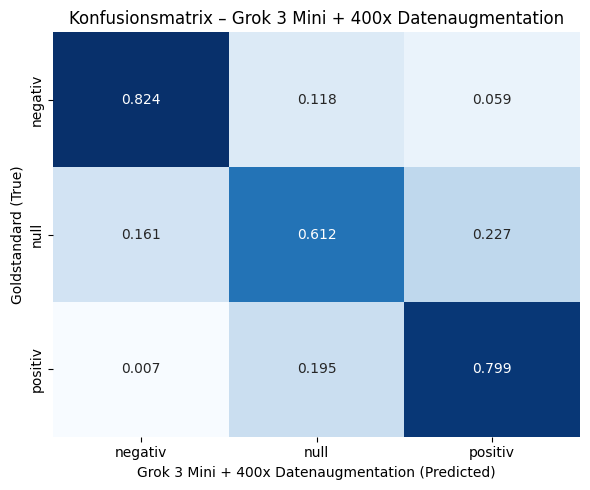

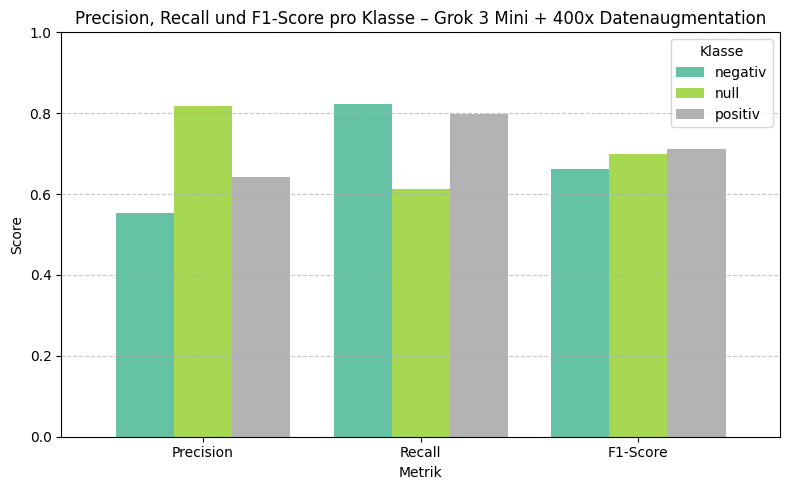

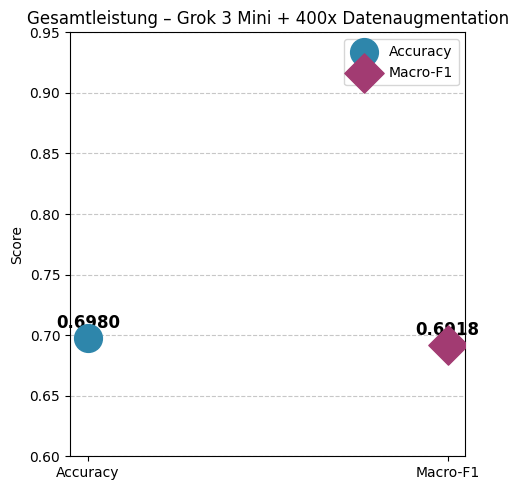

In [27]:
# Goldstandard einmal laden
gold = pd.read_csv("/content/drive/MyDrive/Projekt_ABSA/goldstandard_clean.csv",
                   sep=';', encoding='utf-8-sig')
gold = gold.dropna(how='all').reset_index(drop=True)

# 400 augmentierte Daten und Funktionsaufruf
pred_400 = load_and_aggregate_predictions("/content/drive/MyDrive/Projekt_ABSA/absa_grok400.jsonl")
evaluate_majority_vote(gold, pred_400, model_name="Grok 3 Mini + 400x Datenaugmentation")

Wenn die globalen Regeln im Prompt weggelassen werden:

Verglichene Instanzen: 475

Grok 3 Mini + 400x Datenaugmentation vs. manueller Goldstandard

Accuracy:        0.7347
Macro Precision: 0.7393
Macro Recall:    0.6657
Macro F1:        0.6876
Micro F1:        0.7347

Detail pro Klasse:
              precision    recall  f1-score   support

     negativ     0.6610    0.5735    0.6142        68
        null     0.7183    0.8855    0.7932       262
     positiv     0.8387    0.5379    0.6555       145

    accuracy                         0.7347       475
   macro avg     0.7393    0.6657    0.6876       475
weighted avg     0.7468    0.7347    0.7255       475



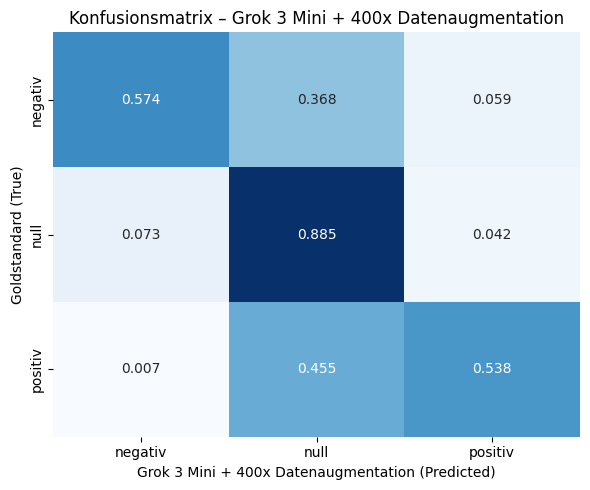

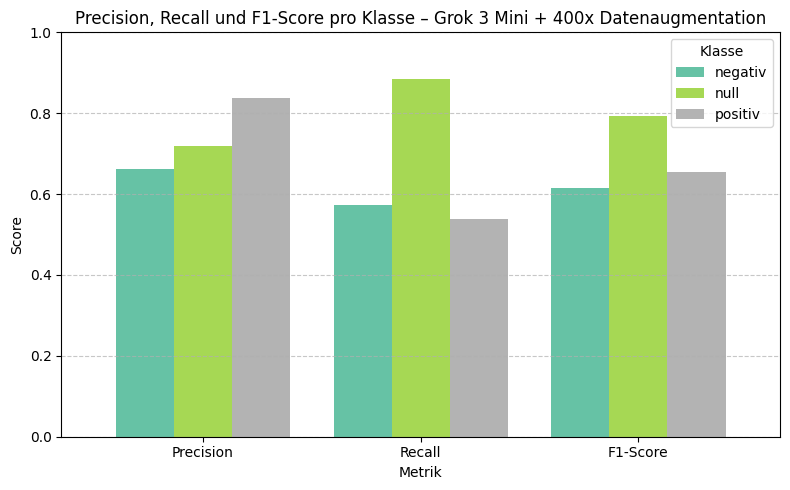

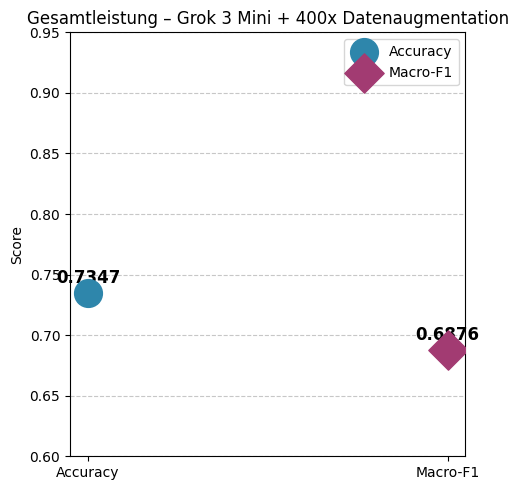

In [31]:
# Goldstandard einmal laden
gold = pd.read_csv("/content/drive/MyDrive/Projekt_ABSA/goldstandard_clean.csv",
                   sep=';', encoding='utf-8-sig')
gold = gold.dropna(how='all').reset_index(drop=True)

# 400 augmentierte Daten und Funktionsaufruf
pred_400 = load_and_aggregate_predictions("/content/drive/MyDrive/Projekt_ABSA/grok_qaie_new.jsonl")
evaluate_majority_vote(gold, pred_400, model_name="Grok 3 Mini + 400x Datenaugmentation")

## Goldstandard vs ABSA durch Syn-Check-Methode

Verglichene Instanzen: 490

Grok 3 Mini (Syn-Chain) vs. manueller Goldstandard

Accuracy:        0.8245
Macro Precision: 0.7852
Macro Recall:    0.8097
Macro F1:        0.7953
Micro F1:        0.8245

Detail pro Klasse:
              precision    recall  f1-score   support

     negativ     0.6341    0.7647    0.6933        68
        null     0.8674    0.8388    0.8529       273
     positiv     0.8542    0.8255    0.8396       149

    accuracy                         0.8245       490
   macro avg     0.7852    0.8097    0.7953       490
weighted avg     0.8310    0.8245    0.8267       490



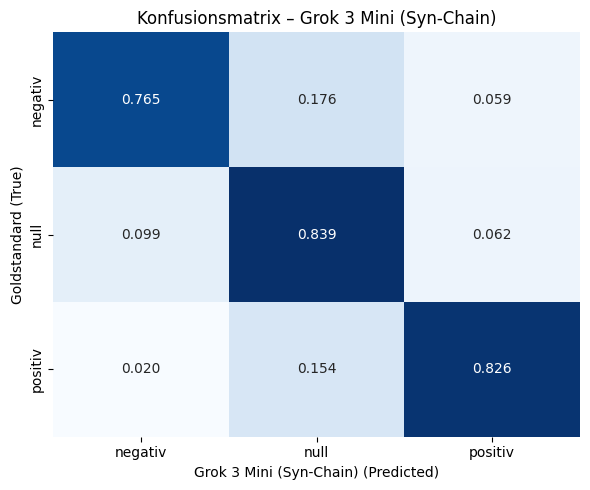

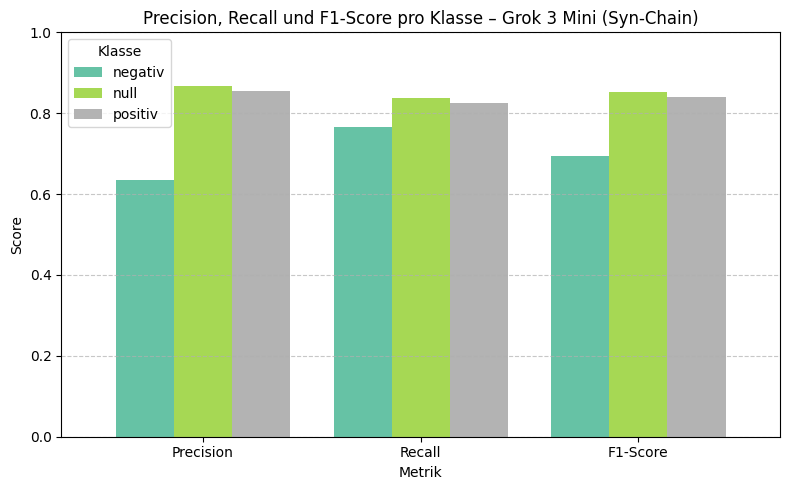

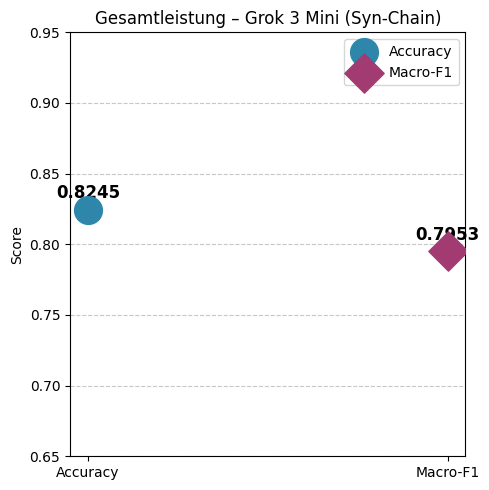

In [20]:
gold, ki_dict = load_gold_and_ki_results(
    "/content/drive/MyDrive/Projekt_ABSA/goldstandard_clean.csv",
    "/content/drive/MyDrive/Projekt_ABSA/absa_synchain_GROK_aktuell.jsonl"   # wird nur zum Laden benötigt
)

# Funktionsaufruf
evaluate_model(gold, ki_dict, model_name="Grok 3 Mini (Syn-Chain)")

# **Mistral AI**

## Goldstandard vs Single Run mit Few-Shot Prompting

Verglichene Instanzen: 490

Mistral Large Instruct (Few-Shot) vs. manueller Goldstandard

Accuracy:        0.7694
Macro Precision: 0.7426
Macro Recall:    0.6928
Macro F1:        0.7104
Micro F1:        0.7694

Detail pro Klasse:
              precision    recall  f1-score   support

     negativ     0.5469    0.5147    0.5303        68
        null     0.7619    0.8791    0.8163       273
     positiv     0.9189    0.6846    0.7846       149

    accuracy                         0.7694       490
   macro avg     0.7426    0.6928    0.7104       490
weighted avg     0.7798    0.7694    0.7670       490



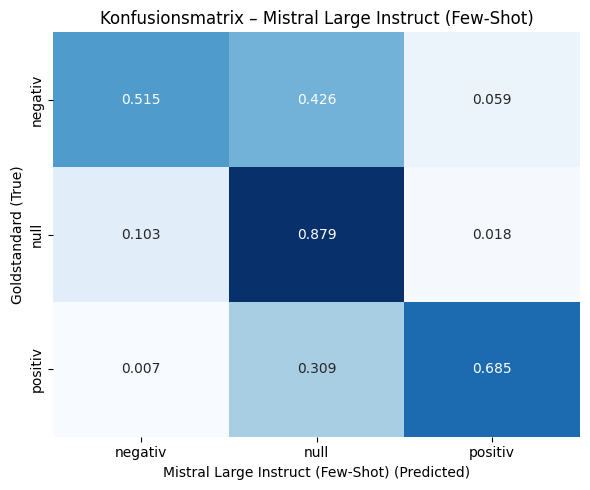

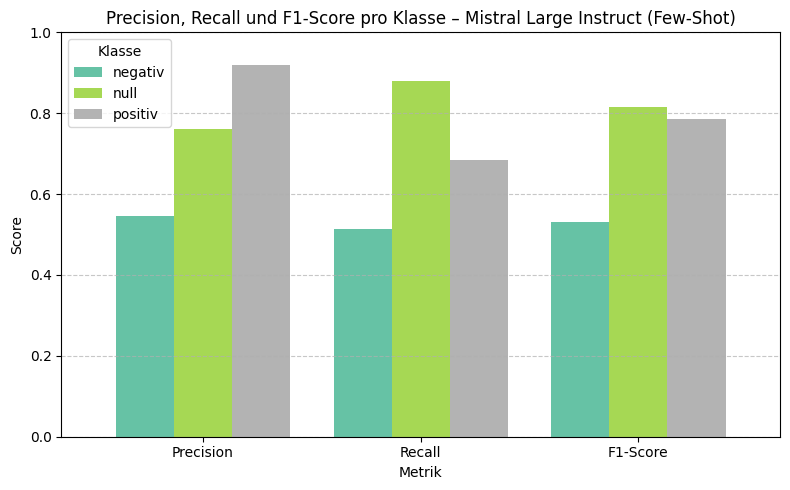

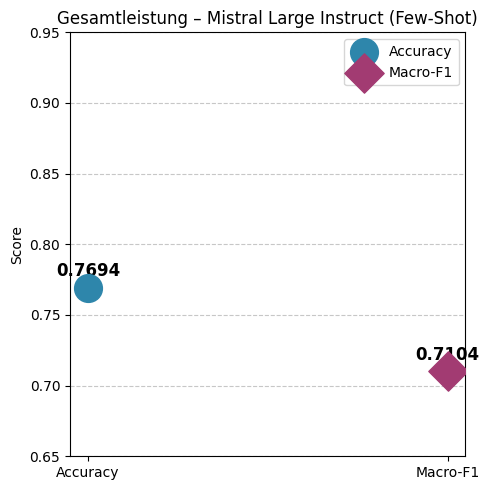

In [21]:
gold, ki_dict = load_gold_and_ki_results(
    "/content/drive/MyDrive/Projekt_ABSA/goldstandard_clean.csv",
    "/content/drive/MyDrive/Projekt_ABSA/absa_ki_m1.jsonl"   # wird nur zum Laden benötigt
)

# Funktionsaufruf
evaluate_model(gold, ki_dict, model_name="Mistral Large Instruct (Few-Shot)")

## Goldstandard vs Single Run mit neuem Few-Shot Prompt

Verglichene Instanzen: 490

Mistral Large Instruct (neuer Few-Shot-Prompt) vs. manueller Goldstandard

Accuracy:        0.7204
Macro Precision: 0.6771
Macro Recall:    0.6702
Macro F1:        0.6733
Micro F1:        0.7204

Detail pro Klasse:
              precision    recall  f1-score   support

     negativ     0.5294    0.5294    0.5294        68
        null     0.7518    0.7766    0.7640       273
     positiv     0.7500    0.7047    0.7266       149

    accuracy                         0.7204       490
   macro avg     0.6771    0.6702    0.6733       490
weighted avg     0.7204    0.7204    0.7201       490



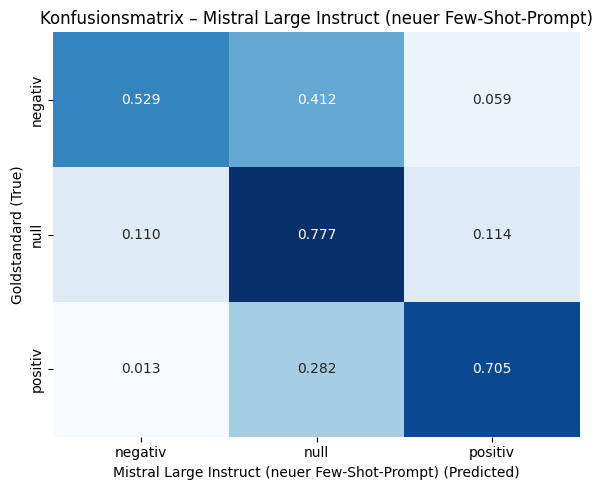

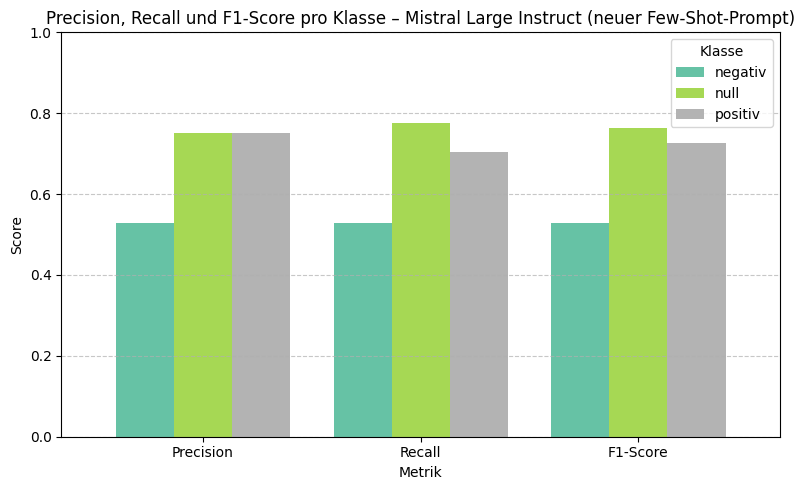

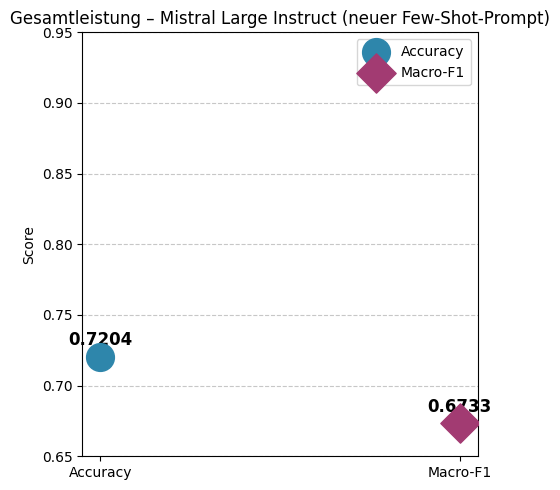

In [22]:
gold, ki_dict = load_gold_and_ki_results(
    "/content/drive/MyDrive/Projekt_ABSA/goldstandard_clean.csv",
    "/content/drive/MyDrive/Projekt_ABSA/mistral_optimize_ev.jsonl"   # wird nur zum Laden benötigt
)

# Funktionsaufruf
evaluate_model(gold, ki_dict, model_name="Mistral Large Instruct (neuer Few-Shot-Prompt)")

## Goldstandard vs ABSA mit Einsatz von Datenaugmentation

Verglichene Instanzen: 490

Mistral Large Instruct + 400x Datenaugmentation vs. manueller Goldstandard

Accuracy:        0.7245
Macro Precision: 0.7063
Macro Recall:    0.6678
Macro F1:        0.6830
Micro F1:        0.7245

Detail pro Klasse:
              precision    recall  f1-score   support

     negativ     0.6230    0.5588    0.5891        68
        null     0.7273    0.8205    0.7711       273
     positiv     0.7686    0.6242    0.6889       149

    accuracy                         0.7245       490
   macro avg     0.7063    0.6678    0.6830       490
weighted avg     0.7254    0.7245    0.7208       490



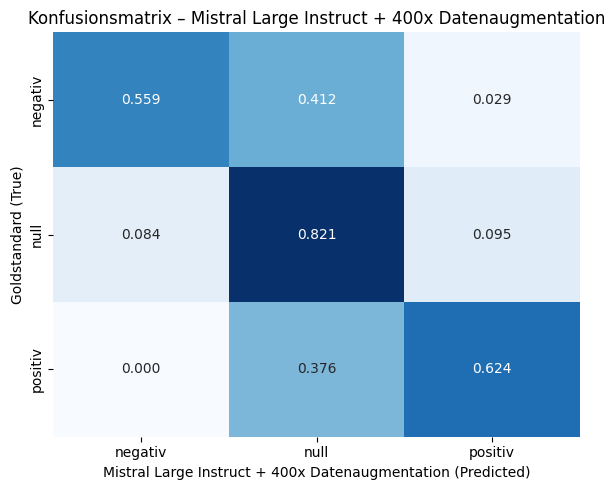

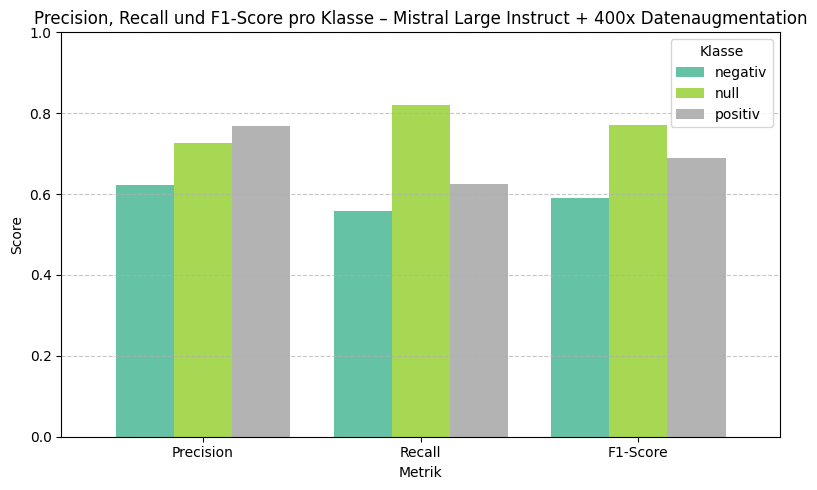

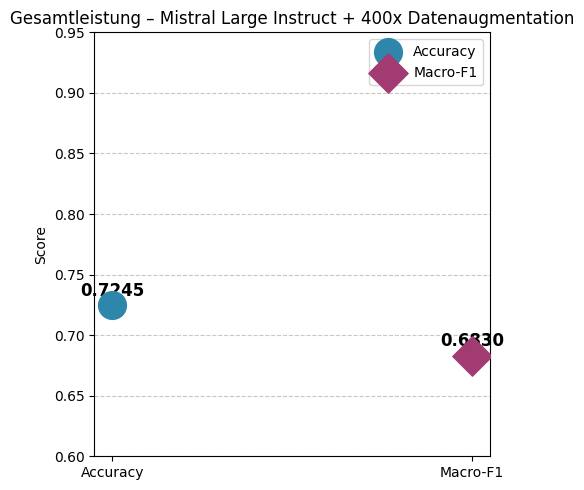

In [32]:
# Goldstandard einmal laden
gold = pd.read_csv("/content/drive/MyDrive/Projekt_ABSA/goldstandard_clean.csv",
                   sep=';', encoding='utf-8-sig')
gold = gold.dropna(how='all').reset_index(drop=True)

# 400 augmentierte Daten und Funktionsaufruf
pred_400 = load_and_aggregate_predictions("/content/drive/MyDrive/Projekt_ABSA/absa_mistral400.jsonl")
evaluate_majority_vote(gold, pred_400, model_name="Mistral Large Instruct + 400x Datenaugmentation")

## Goldstandard vs ABSA durch Syn-Check-Methode

Verglichene Instanzen: 490

Mistral Large Instruct (Syn-Chain) vs. manueller Goldstandard

Accuracy:        0.8184
Macro Precision: 0.8343
Macro Recall:    0.7538
Macro F1:        0.7819
Micro F1:        0.8184

Detail pro Klasse:
              precision    recall  f1-score   support

     negativ     0.7895    0.6618    0.7200        68
        null     0.7896    0.9487    0.8619       273
     positiv     0.9238    0.6510    0.7638       149

    accuracy                         0.8184       490
   macro avg     0.8343    0.7538    0.7819       490
weighted avg     0.8304    0.8184    0.8124       490



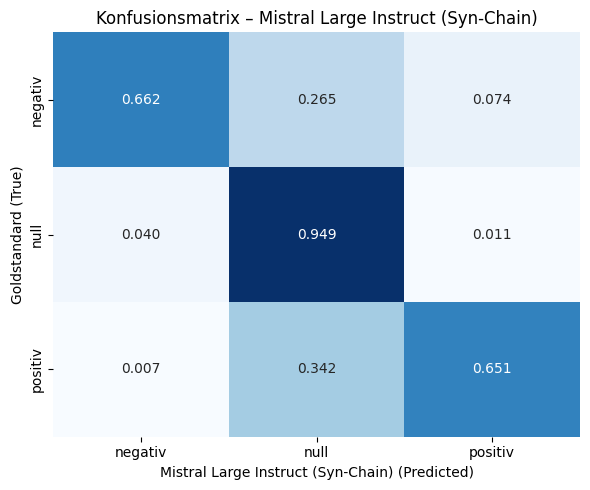

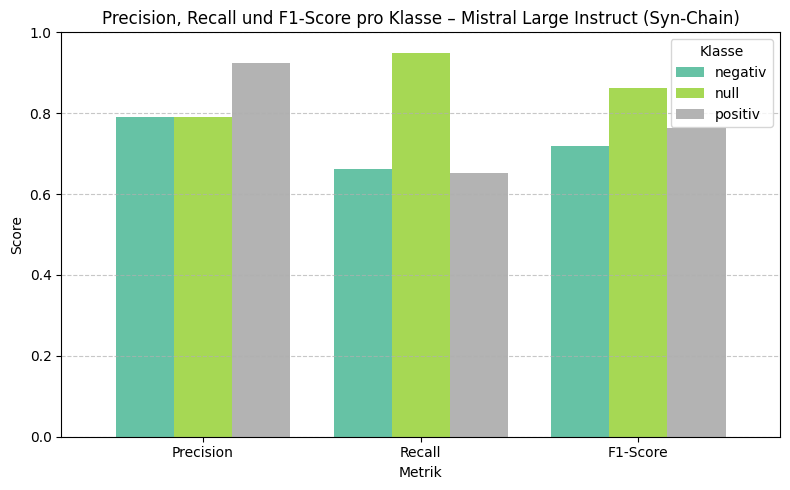

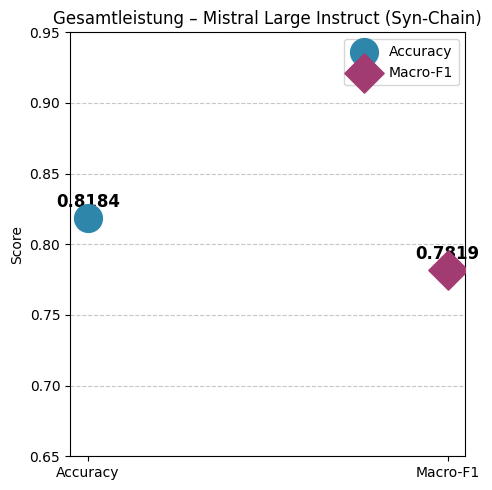

In [24]:
gold, ki_dict = load_gold_and_ki_results(
    "/content/drive/MyDrive/Projekt_ABSA/goldstandard_clean.csv",
    "/content/drive/MyDrive/Projekt_ABSA/absa_MISTRAL_new.jsonl"   # wird nur zum Laden benötigt
)

# Funktionsaufruf
evaluate_model(gold, ki_dict, model_name="Mistral Large Instruct (Syn-Chain)")

#**Aspektbasierte Sentimentanalyse (ABSA)**

# Vorbereitung und Prompts

# Few-Shot-Prompt entwerfen

In [ ]:
# @title
"""You are an ABSA expert for Google reviews of German nursing homes.
Analyze review and output ONLY ONE LINE of valid JSON:
{"id": 123, "text"= "original text", "Personal": "positiv", "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": null, "Hygiene": null}
For each aspect ["Personal", "Verpflegung", "Hygiene", "Wohnen", "Sicherheit"]:
-"positiv" -> if aspect is positively mentioned
-"negativ" -> if aspect is negatively mentioned
-null -> if aspect is not mentioned at all
Output must be directly savable as .jsonl Line"""

## 11 starke Beispiele hinzufügen

**1. Testphase**

In [ ]:
# @title
Analyze review and output ONLY ONE LINE of valid JSON:
{"id": 123, "text"= "original text", "Personal": "positiv", "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": null, "Hygiene": null}
For each aspect ["Personal", "Verpflegung", "Hygiene", "Wohnen", "Sicherheit"]:
-"positiv" -> if aspect is positively mentioned
-"negativ" -> if aspect is negatively mentioned
-null -> if aspect is not mentioned at all
Output must be directly savable as .jsonl Line
Examples:
Review: Ich arbeite seit ca. 10 Jahren im Botegunhof und meine Eltern waren beide Bewohner dort. Das arbeiten mit den Kollegen ist sehr kollegial, die Betreuung der Bewohner ist sehr Bewohner bezogen. Sehr gut sind unsere Feste die von den Bewohnern sehr beliebt sind.Wenn es so schlecht dort ist wie manche behaupten, dann frage ich mich warum ich und andere Kollegen schon so lange dort sind.
Analysis: {"id": 2463, "text": "Ich arbeite seit ca. 10 Jahren im Botegunhof und meine Eltern waren beide Bewohner dort. Das arbeiten mit den Kollegen ist sehr kollegial, die Betreuung der Bewohner ist sehr Bewohner bezogen. Sehr gut sind unsere Feste die von den Bewohnern sehr beliebt sind.Wenn es so schlecht dort ist wie manche behaupten, dann frage ich mich warum ich und andere Kollegen schon so lange dort sind.", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": null, "Wohnen": null, "Hygiene": null}

Review: Ich arbeite seit ca. 10 Jahren im Botegunhof und meine Eltern waren beide Heimbewohner dort. Das arbeiten mit den Kollegen ist sehr kollegial, die Obhut der Bewohner ist sehr Bewohner bezogen. Sehr gut sind unsere Feste die von den Bewohnern sehr beliebt sind.Wenn es so schlecht dort ist wie manche behaupten, dann frage ich mich warum ich und andere Kollegen schon so lange dort sind.
Analysis: {"id": 2463, "text": "Ich arbeite seit ca. 10 Jahren im Botegunhof und meine Eltern waren beide Heimbewohner dort. Das arbeiten mit den Kollegen ist sehr kollegial, die Obhut der Bewohner ist sehr Bewohner bezogen. Sehr gut sind unsere Feste die von den Bewohnern sehr beliebt sind.Wenn es so schlecht dort ist wie manche behaupten, dann frage ich mich warum ich und andere Kollegen schon so lange dort sind.", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": null, "Wohnen": null, "Hygiene": null}

Review: Alles nicht ganz einfach. Testung ist gut, aber die Öffnungszeiten stehen z.B. nicht auf der Homepage oder Facebook. Manche sind draußen mit Maske, andere nicht. Da fragt man sich, was ist hier die Regel?
Analysis: {"id": 6745, "text": "Alles nicht ganz einfach. Testung ist gut, aber die Öffnungszeiten stehen z.B. nicht auf der Homepage oder Facebook. Manche sind draußen mit Maske, andere nicht. Da fragt man sich, was ist hier die Regel?", "Personal": null, "Verpflegung": null, "Sicherheit": negativ, "Wohnen": positiv, "Hygiene": null}

Review: Alles nicht ganz einfach. Manche sind draußen mit Maske, andere nicht. Testung ist gut, aber die Öffnungszeiten stehen z.B. nicht auf der Homepage oder Facebook. Da fragt man sich, was ist hier die Regel?
Analysis: {"id": 6745, "text": "Alles nicht ganz einfach. Manche sind draußen mit Maske, andere nicht. Testung ist gut, aber die Öffnungszeiten stehen z.B. nicht auf der Homepage oder Facebook. Da fragt man sich, was ist hier die Regel?", "Personal": null, "Verpflegung": null, "Sicherheit": negativ, "Wohnen": positiv, "Hygiene": null}

Review: Sehr schönes Heim, auch mit einem Hauch Exklusivität. Die Zimmer sind sehr schön mit viel Licht. Es gibt Fernsehen und Telefon. Ich war vor covid 19 öfter dort und habe auch festgestellt, dass das Essen immer gut ausgesehen hat. Das Personal  hat stets auch unter Anspannung einen zufriedenen Eindruck hinterlassen!
Analysis: {"id": 11587, "text": "Sehr schönes Heim, auch mit einem Hauch Exklusivität. Die Zimmer sind sehr schön mit viel Licht. Es gibt Fernsehen und Telefon. Ich war vor covid 19 öfter dort und habe auch festgestellt, dass das Essen immer gut ausgesehen hat. Das Personal  hat stets auch unter Anspannung einen zufriedenen Eindruck hinterlassen!", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": null, "Wohnen": positiv, "Hygiene": null}

Review: Sehr schönes Residenz, auch mit einem Hauch Exklusivität. Die Wohnbereich sind sehr schön mit viel Licht. Es gibt Fernsehen und Telefon. Ich war vor covid 19 öfter dort und habe auch festgestellt, dass das Gerichte immer gut ausgesehen hat. Das Belegschaft  hat stets auch unter Anspannung einen zufriedenen Eindruck hinterlassen!
Analysis: {"id": 11587, "text": "Sehr schönes Residenz, auch mit einem Hauch Exklusivität. Die Wohnbereich sind sehr schön mit viel Licht. Es gibt Fernsehen und Telefon. Ich war vor covid 19 öfter dort und habe auch festgestellt, dass das Gerichte immer gut ausgesehen hat. Das Belegschaft  hat stets auch unter Anspannung einen zufriedenen Eindruck hinterlassen!", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": null, "Wohnen": positiv, "Hygiene": null}

Review: Leider keine guten Erfahrungen hier in diesem Haus mit meiner Mutter in der Pflege gemacht!
Analysis: {"id": 48, "text": "Leider keine guten Erfahrungen hier in diesem Haus mit meiner Mutter in der Pflege gemacht!", "Personal": "negativ", "Verpflegung": "negativ", "Sicherheit": "negativ", "Wohnen": "negativ", "Hygiene": "negativ"}

Review: Leider keine guten Erfahrungen hier in diesem Pflegeheim mit meiner Familienangehörige in der Fürsorge gemacht!
Analysis: {"id": 48, "text": "Leider keine guten Erfahrungen hier in diesem Pflegeheim mit meiner Familienangehörige in der Fürsorge gemacht!", "Personal": "negativ", "Verpflegung": "negativ", "Sicherheit": "negativ", "Wohnen": "negativ", "Hygiene": "negativ"}

Review: Das Altenheim ist mit einem Wort eine Katastrophe. Zum Teil inkompetent,  unfreundliches Personal. Schlechte oder keine Reinigung der Zimmer am Wochenende oder Feiertagen. Essen ungenießbar.Medikamentengabe Zufall ,wenn es funktioniert. Was auf der Webseite steht,  entspricht nicht der Wahrheit,sondern kann für die Bewohner  Lebensgefährlich sein.
Analysis: {"id": 10618, "text": "Das Altenheim ist mit einem Wort eine Katastrophe. Zum Teil inkompetent,  unfreundliches Personal. Schlechte oder keine Reinigung der Zimmer am Wochenende oder Feiertagen. Essen ungenießbar.Medikamentengabe Zufall ,wenn es funktioniert. Was auf der Webseite steht,  entspricht nicht der Wahrheit,sondern kann für die Bewohner  Lebensgefährlich sein.", "Personal": "negativ", "Verpflegung": "negativ", "Sicherheit": "negativ", "Wohnen": "negativ", "Hygiene": "negativ"}

Review: Das Altenheim ist mit einem Wort eine Katastrophe. Gerichte ungenießbar.Medikamentengabe Zufall ,wenn es funktioniert. Schlechte oder keine Reinigung der Wohnbereich am Wochenende oder Feiertagen. Zum Teil inkompetent,  unfreundliches Pflegekräfte. Was auf der Webseite steht,  entspricht nicht der Wahrheit,sondern kann für die Heimbewohner  Lebensgefährlich sein.
Analysis: {"id": 10618, "text": "Das Altenheim ist mit einem Wort eine Katastrophe. Gerichte ungenießbar.Medikamentengabe Zufall ,wenn es funktioniert. Schlechte oder keine Reinigung der Wohnbereich am Wochenende oder Feiertagen. Zum Teil inkompetent,  unfreundliches Pflegekräfte. Was auf der Webseite steht,  entspricht nicht der Wahrheit,sondern kann für die Heimbewohner  Lebensgefährlich sein.", "Personal": "negativ", "Verpflegung": "negativ", "Sicherheit": "negativ", "Wohnen": "negativ", "Hygiene": "negativ"}

Review: Alles Top
Analysis: {"id": 10675, "text": "Alles Top", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": "positiv", "Wohnen": "positiv", "Hygiene": "positiv"}

New Review: Wer nur auf Äußerlichkeiten (Einrichtung) Wert legt, körperlich fit ist und zusätzlich einen dicken Geldbeutel hat, mag hier gut aufgehoben sein. Alle anderen sollten sich darüber im Klaren sein, dass jede Kleinigkeit extra erkauft bzw bezahlt werden muss und der Umgangston gegenüber der Bewohner zum Teil sehr unsensibel ist.Am Tag der offenen Tür wurde seitens des Chefs extra betont, man sehe sich als Hotel an. Schön! Aber selbst in einem Hotel muss der Gast sein Toilettenpapier nicht selbst kaufen!Nein danke! Absolut nicht empfehlenswert! Den einen Stern gibt`s für die Einrichtung und das zum Teil nette Personal. Das motzendes Personal (weil sich ein neuer Bewohner in der Etage geirrt hat) sorgt wiederum für Punktabzug.Mein Angehöriger wurde hier dermaßen verunsichert, dass wir nach sehr kurzer Zeit das Heim gewechselt haben.

New Review: sehr schlecht😣


Ausgabe aus Grok.com:

In [ ]:
{"id": 123, "text": "Sehr schöne Zimmer, nette und kompetente Betreuung. Meine Mutter ist sehr zufrieden dortAbwertung : Patienten sind sehr unzufrieden mit der hohen Fluktuation der Pflegekräfte. So kann sich kein vertrauensverhältnis aufbauen", "Personal": "negativ", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}

## Test mit 5 neuen Rezensionen (nicht bereits annotiert)


In [ ]:
# @title
Analyze new reviews and output ONLY ONE LINE of valid JSON per new review:
{"id": 123, "text"= "original text", "Personal": "positiv", "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": null, "Hygiene": null}
For each aspect ["Personal", "Verpflegung", "Hygiene", "Wohnen", "Sicherheit"]:
-"positiv" -> if aspect is positively mentioned
-"negativ" -> if aspect is negatively mentioned
-null -> if aspect is not mentioned at all
Output must be directly savable as .jsonl Line
Examples:
Review: Ich arbeite seit ca. 10 Jahren im Botegunhof und meine Eltern waren beide Bewohner dort. Das arbeiten mit den Kollegen ist sehr kollegial, die Betreuung der Bewohner ist sehr Bewohner bezogen. Sehr gut sind unsere Feste die von den Bewohnern sehr beliebt sind.Wenn es so schlecht dort ist wie manche behaupten, dann frage ich mich warum ich und andere Kollegen schon so lange dort sind.
Analysis: {"id": 2463, "text": "Ich arbeite seit ca. 10 Jahren im Botegunhof und meine Eltern waren beide Bewohner dort. Das arbeiten mit den Kollegen ist sehr kollegial, die Betreuung der Bewohner ist sehr Bewohner bezogen. Sehr gut sind unsere Feste die von den Bewohnern sehr beliebt sind.Wenn es so schlecht dort ist wie manche behaupten, dann frage ich mich warum ich und andere Kollegen schon so lange dort sind.", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": null, "Wohnen": null, "Hygiene": null}

Review: Ich arbeite seit ca. 10 Jahren im Botegunhof und meine Eltern waren beide Heimbewohner dort. Das arbeiten mit den Kollegen ist sehr kollegial, die Obhut der Bewohner ist sehr Bewohner bezogen. Sehr gut sind unsere Feste die von den Bewohnern sehr beliebt sind.Wenn es so schlecht dort ist wie manche behaupten, dann frage ich mich warum ich und andere Kollegen schon so lange dort sind.
Analysis: {"id": 2463, "text": "Ich arbeite seit ca. 10 Jahren im Botegunhof und meine Eltern waren beide Heimbewohner dort. Das arbeiten mit den Kollegen ist sehr kollegial, die Obhut der Bewohner ist sehr Bewohner bezogen. Sehr gut sind unsere Feste die von den Bewohnern sehr beliebt sind.Wenn es so schlecht dort ist wie manche behaupten, dann frage ich mich warum ich und andere Kollegen schon so lange dort sind.", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": null, "Wohnen": null, "Hygiene": null}

Review: Alles nicht ganz einfach. Testung ist gut, aber die Öffnungszeiten stehen z.B. nicht auf der Homepage oder Facebook. Manche sind draußen mit Maske, andere nicht. Da fragt man sich, was ist hier die Regel?
Analysis: {"id": 6745, "text": "Alles nicht ganz einfach. Testung ist gut, aber die Öffnungszeiten stehen z.B. nicht auf der Homepage oder Facebook. Manche sind draußen mit Maske, andere nicht. Da fragt man sich, was ist hier die Regel?", "Personal": null, "Verpflegung": null, "Sicherheit": negativ, "Wohnen": positiv, "Hygiene": null}

Review: Alles nicht ganz einfach. Manche sind draußen mit Maske, andere nicht. Testung ist gut, aber die Öffnungszeiten stehen z.B. nicht auf der Homepage oder Facebook. Da fragt man sich, was ist hier die Regel?
Analysis: {"id": 6745, "text": "Alles nicht ganz einfach. Manche sind draußen mit Maske, andere nicht. Testung ist gut, aber die Öffnungszeiten stehen z.B. nicht auf der Homepage oder Facebook. Da fragt man sich, was ist hier die Regel?", "Personal": null, "Verpflegung": null, "Sicherheit": negativ, "Wohnen": positiv, "Hygiene": null}

Review: Sehr schönes Heim, auch mit einem Hauch Exklusivität. Die Zimmer sind sehr schön mit viel Licht. Es gibt Fernsehen und Telefon. Ich war vor covid 19 öfter dort und habe auch festgestellt, dass das Essen immer gut ausgesehen hat. Das Personal  hat stets auch unter Anspannung einen zufriedenen Eindruck hinterlassen!
Analysis: {"id": 11587, "text": "Sehr schönes Heim, auch mit einem Hauch Exklusivität. Die Zimmer sind sehr schön mit viel Licht. Es gibt Fernsehen und Telefon. Ich war vor covid 19 öfter dort und habe auch festgestellt, dass das Essen immer gut ausgesehen hat. Das Personal  hat stets auch unter Anspannung einen zufriedenen Eindruck hinterlassen!", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": null, "Wohnen": positiv, "Hygiene": null}

Review: Sehr schönes Residenz, auch mit einem Hauch Exklusivität. Die Wohnbereich sind sehr schön mit viel Licht. Es gibt Fernsehen und Telefon. Ich war vor covid 19 öfter dort und habe auch festgestellt, dass das Gerichte immer gut ausgesehen hat. Das Belegschaft  hat stets auch unter Anspannung einen zufriedenen Eindruck hinterlassen!
Analysis: {"id": 11587, "text": "Sehr schönes Residenz, auch mit einem Hauch Exklusivität. Die Wohnbereich sind sehr schön mit viel Licht. Es gibt Fernsehen und Telefon. Ich war vor covid 19 öfter dort und habe auch festgestellt, dass das Gerichte immer gut ausgesehen hat. Das Belegschaft  hat stets auch unter Anspannung einen zufriedenen Eindruck hinterlassen!", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": null, "Wohnen": positiv, "Hygiene": null}

Review: Leider keine guten Erfahrungen hier in diesem Haus mit meiner Mutter in der Pflege gemacht!
Analysis: {"id": 48, "text": "Leider keine guten Erfahrungen hier in diesem Haus mit meiner Mutter in der Pflege gemacht!", "Personal": "negativ", "Verpflegung": "negativ", "Sicherheit": "negativ", "Wohnen": "negativ", "Hygiene": "negativ"}

Review: Leider keine guten Erfahrungen hier in diesem Pflegeheim mit meiner Familienangehörige in der Fürsorge gemacht!
Analysis: {"id": 48, "text": "Leider keine guten Erfahrungen hier in diesem Pflegeheim mit meiner Familienangehörige in der Fürsorge gemacht!", "Personal": "negativ", "Verpflegung": "negativ", "Sicherheit": "negativ", "Wohnen": "negativ", "Hygiene": "negativ"}

Review: Das Altenheim ist mit einem Wort eine Katastrophe. Zum Teil inkompetent,  unfreundliches Personal. Schlechte oder keine Reinigung der Zimmer am Wochenende oder Feiertagen. Essen ungenießbar.Medikamentengabe Zufall ,wenn es funktioniert. Was auf der Webseite steht,  entspricht nicht der Wahrheit,sondern kann für die Bewohner  Lebensgefährlich sein.
Analysis: {"id": 10618, "text": "Das Altenheim ist mit einem Wort eine Katastrophe. Zum Teil inkompetent,  unfreundliches Personal. Schlechte oder keine Reinigung der Zimmer am Wochenende oder Feiertagen. Essen ungenießbar.Medikamentengabe Zufall ,wenn es funktioniert. Was auf der Webseite steht,  entspricht nicht der Wahrheit,sondern kann für die Bewohner  Lebensgefährlich sein.", "Personal": "negativ", "Verpflegung": "negativ", "Sicherheit": "negativ", "Wohnen": "negativ", "Hygiene": "negativ"}

Review: Das Altenheim ist mit einem Wort eine Katastrophe. Gerichte ungenießbar.Medikamentengabe Zufall ,wenn es funktioniert. Schlechte oder keine Reinigung der Wohnbereich am Wochenende oder Feiertagen. Zum Teil inkompetent,  unfreundliches Pflegekräfte. Was auf der Webseite steht,  entspricht nicht der Wahrheit,sondern kann für die Heimbewohner  Lebensgefährlich sein.
Analysis: {"id": 10618, "text": "Das Altenheim ist mit einem Wort eine Katastrophe. Gerichte ungenießbar.Medikamentengabe Zufall ,wenn es funktioniert. Schlechte oder keine Reinigung der Wohnbereich am Wochenende oder Feiertagen. Zum Teil inkompetent,  unfreundliches Pflegekräfte. Was auf der Webseite steht,  entspricht nicht der Wahrheit,sondern kann für die Heimbewohner  Lebensgefährlich sein.", "Personal": "negativ", "Verpflegung": "negativ", "Sicherheit": "negativ", "Wohnen": "negativ", "Hygiene": "negativ"}

Review: Alles Top
Analysis: {"id": 10675, "text": "Alles Top", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": "positiv", "Wohnen": "positiv", "Hygiene": "positiv"}

New Review: Wer nur auf Äußerlichkeiten (Einrichtung) Wert legt, körperlich fit ist und zusätzlich einen dicken Geldbeutel hat, mag hier gut aufgehoben sein. Alle anderen sollten sich darüber im Klaren sein, dass jede Kleinigkeit extra erkauft bzw bezahlt werden muss und der Umgangston gegenüber der Bewohner zum Teil sehr unsensibel ist.Am Tag der offenen Tür wurde seitens des Chefs extra betont, man sehe sich als Hotel an. Schön! Aber selbst in einem Hotel muss der Gast sein Toilettenpapier nicht selbst kaufen!Nein danke! Absolut nicht empfehlenswert! Den einen Stern gibt`s für die Einrichtung und das zum Teil nette Personal. Das motzendes Personal (weil sich ein neuer Bewohner in der Etage geirrt hat) sorgt wiederum für Punktabzug.Mein Angehöriger wurde hier dermaßen verunsichert, dass wir nach sehr kurzer Zeit das Heim gewechselt haben.

New Review: sehr schlecht😣

New Review: Helle Flure, freundliches Personal. Es wird Einiges geboten an Freizeitbeschäftigung, besonders schön finde ich die Hundebesuche oder den Hundetag.

New Review: Angenehme Atmosphäre

New Review: Nie wieder würden wir einen Angehörigen in dieser grausamen Einrichtung unterbringen. Was unser Opi dort aushalten musste ist einfach nur unmenschlich!

Ausgabe:

In [ ]:
# @title
{"id": 20000, "text": "Wer nur auf Äußerlichkeiten (Einrichtung) Wert legt, körperlich fit ist und zusätzlich einen dicken Geldbeutel hat, mag hier gut aufgehoben sein. Alle anderen sollten sich darüber im Klaren sein, dass jede Kleinigkeit extra erkauft bzw bezahlt werden muss und der Umgangston gegenüber der Bewohner zum Teil sehr unsensibel ist.Am Tag der offenen Tür wurde seitens des Chefs extra betont, man sehe sich als Hotel an. Schön! Aber selbst in einem Hotel muss der Gast sein Toilettenpapier nicht selbst kaufen!Nein danke! Absolut nicht empfehlenswert! Den einen Stern gibt`s für die Einrichtung und das zum Teil nette Personal. Das motzendes Personal (weil sich ein neuer Bewohner in der Etage geirrt hat) sorgt wiederum für Punktabzug.Mein Angehöriger wurde hier dermaßen verunsichert, dass wir nach sehr kurzer Zeit das Heim gewechselt haben.", "Personal": "negativ", "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": "positiv", "Hygiene": "negativ"}
{"id": 20001, "text": "sehr schlecht😣", "Personal": "negativ", "Verpflegung": "negativ", "Sicherheit": "negativ", "Wohnen": "negativ", "Hygiene": "negativ"}
{"id": 20002, "text": "Helle Flure, freundliches Personal. Es wird Einiges geboten an Freizeitbeschäftigung, besonders schön finde ich die Hundebesuche oder den Hundetag.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}
{"id": 20003, "text": "Angenehme Atmosphäre", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": "positiv", "Wohnen": "positiv", "Hygiene": "positiv"}
{"id": 20004, "text": "Nie wieder würden wir einen Angehörigen in dieser grausamen Einrichtung unterbringen. Was unser Opi dort aushalten musste ist einfach nur unmenschlich!", "Personal": "negativ", "Verpflegung": "negativ", "Sicherheit": "negativ", "Wohnen": "negativ", "Hygiene": "negativ"}

Rezension mit Zufallszahl "5518": LLM erkannte nicht, dass Verfasser der Rezension die Wohnsituation (man müsse für jede Kleinigkeit Geld bezahlen) als negativ wertet. Wahrscheinlich wegen dem ersten Satz?

In [ ]:
# @title
manuell : , "Personal": "negativ", "Verpflegung": "negativ", "Sicherheit": null, "Wohnen": "negativ", "Hygiene": null
KI_Grok : , "Personal": "negativ", "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": "positiv", "Hygiene": "negativ"

## Test mit 100 Rezensionen aus manuelle_ABSA.csv

### Erster Versuch

In [ ]:
# @title
Analyze all reviews from uploaded csv file and output ONLY ONE LINE of valid JSON per review:
{"id": 123, "text": "{{text}}", "Personal": "positiv", "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": null, "Hygiene": null}
For each aspect ["Personal", "Verpflegung", "Hygiene", "Wohnen", "Sicherheit"]:
-"positiv" -> if aspect is positively mentioned
-"negativ" -> if aspect is negatively mentioned
-null -> if aspect is not mentioned at all
Output must be directly savable as .jsonl Line
Examples:
Review: Ich arbeite seit ca. 10 Jahren im Botegunhof und meine Eltern waren beide Bewohner dort. Das arbeiten mit den Kollegen ist sehr kollegial, die Betreuung der Bewohner ist sehr Bewohner bezogen. Sehr gut sind unsere Feste die von den Bewohnern sehr beliebt sind.Wenn es so schlecht dort ist wie manche behaupten, dann frage ich mich warum ich und andere Kollegen schon so lange dort sind.
Analysis: {"id": 2463, "text": "Ich arbeite seit ca. 10 Jahren im Botegunhof und meine Eltern waren beide Bewohner dort. Das arbeiten mit den Kollegen ist sehr kollegial, die Betreuung der Bewohner ist sehr Bewohner bezogen. Sehr gut sind unsere Feste die von den Bewohnern sehr beliebt sind.Wenn es so schlecht dort ist wie manche behaupten, dann frage ich mich warum ich und andere Kollegen schon so lange dort sind.", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": null, "Wohnen": null, "Hygiene": null}

Review: Ich arbeite seit ca. 10 Jahren im Botegunhof und meine Eltern waren beide Heimbewohner dort. Das arbeiten mit den Kollegen ist sehr kollegial, die Obhut der Bewohner ist sehr Bewohner bezogen. Sehr gut sind unsere Feste die von den Bewohnern sehr beliebt sind.Wenn es so schlecht dort ist wie manche behaupten, dann frage ich mich warum ich und andere Kollegen schon so lange dort sind.
Analysis: {"id": 2463, "text": "Ich arbeite seit ca. 10 Jahren im Botegunhof und meine Eltern waren beide Heimbewohner dort. Das arbeiten mit den Kollegen ist sehr kollegial, die Obhut der Bewohner ist sehr Bewohner bezogen. Sehr gut sind unsere Feste die von den Bewohnern sehr beliebt sind.Wenn es so schlecht dort ist wie manche behaupten, dann frage ich mich warum ich und andere Kollegen schon so lange dort sind.", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": null, "Wohnen": null, "Hygiene": null}

Review: Alles nicht ganz einfach. Testung ist gut, aber die Öffnungszeiten stehen z.B. nicht auf der Homepage oder Facebook. Manche sind draußen mit Maske, andere nicht. Da fragt man sich, was ist hier die Regel?
Analysis: {"id": 6745, "text": "Alles nicht ganz einfach. Testung ist gut, aber die Öffnungszeiten stehen z.B. nicht auf der Homepage oder Facebook. Manche sind draußen mit Maske, andere nicht. Da fragt man sich, was ist hier die Regel?", "Personal": null, "Verpflegung": null, "Sicherheit": negativ, "Wohnen": positiv, "Hygiene": null}

Review: Alles nicht ganz einfach. Manche sind draußen mit Maske, andere nicht. Testung ist gut, aber die Öffnungszeiten stehen z.B. nicht auf der Homepage oder Facebook. Da fragt man sich, was ist hier die Regel?
Analysis: {"id": 6745, "text": "Alles nicht ganz einfach. Manche sind draußen mit Maske, andere nicht. Testung ist gut, aber die Öffnungszeiten stehen z.B. nicht auf der Homepage oder Facebook. Da fragt man sich, was ist hier die Regel?", "Personal": null, "Verpflegung": null, "Sicherheit": negativ, "Wohnen": positiv, "Hygiene": null}

Review: Sehr schönes Heim, auch mit einem Hauch Exklusivität. Die Zimmer sind sehr schön mit viel Licht. Es gibt Fernsehen und Telefon. Ich war vor covid 19 öfter dort und habe auch festgestellt, dass das Essen immer gut ausgesehen hat. Das Personal  hat stets auch unter Anspannung einen zufriedenen Eindruck hinterlassen!
Analysis: {"id": 11587, "text": "Sehr schönes Heim, auch mit einem Hauch Exklusivität. Die Zimmer sind sehr schön mit viel Licht. Es gibt Fernsehen und Telefon. Ich war vor covid 19 öfter dort und habe auch festgestellt, dass das Essen immer gut ausgesehen hat. Das Personal  hat stets auch unter Anspannung einen zufriedenen Eindruck hinterlassen!", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": null, "Wohnen": positiv, "Hygiene": null}

Review: Sehr schönes Residenz, auch mit einem Hauch Exklusivität. Die Wohnbereich sind sehr schön mit viel Licht. Es gibt Fernsehen und Telefon. Ich war vor covid 19 öfter dort und habe auch festgestellt, dass das Gerichte immer gut ausgesehen hat. Das Belegschaft  hat stets auch unter Anspannung einen zufriedenen Eindruck hinterlassen!
Analysis: {"id": 11587, "text": "Sehr schönes Residenz, auch mit einem Hauch Exklusivität. Die Wohnbereich sind sehr schön mit viel Licht. Es gibt Fernsehen und Telefon. Ich war vor covid 19 öfter dort und habe auch festgestellt, dass das Gerichte immer gut ausgesehen hat. Das Belegschaft  hat stets auch unter Anspannung einen zufriedenen Eindruck hinterlassen!", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": null, "Wohnen": positiv, "Hygiene": null}

Review: Leider keine guten Erfahrungen hier in diesem Haus mit meiner Mutter in der Pflege gemacht!
Analysis: {"id": 48, "text": "Leider keine guten Erfahrungen hier in diesem Haus mit meiner Mutter in der Pflege gemacht!", "Personal": "negativ", "Verpflegung": "negativ", "Sicherheit": "negativ", "Wohnen": "negativ", "Hygiene": "negativ"}

Review: Leider keine guten Erfahrungen hier in diesem Pflegeheim mit meiner Familienangehörige in der Fürsorge gemacht!
Analysis: {"id": 48, "text": "Leider keine guten Erfahrungen hier in diesem Pflegeheim mit meiner Familienangehörige in der Fürsorge gemacht!", "Personal": "negativ", "Verpflegung": "negativ", "Sicherheit": "negativ", "Wohnen": "negativ", "Hygiene": "negativ"}

Review: Das Altenheim ist mit einem Wort eine Katastrophe. Zum Teil inkompetent,  unfreundliches Personal. Schlechte oder keine Reinigung der Zimmer am Wochenende oder Feiertagen. Essen ungenießbar.Medikamentengabe Zufall ,wenn es funktioniert. Was auf der Webseite steht,  entspricht nicht der Wahrheit,sondern kann für die Bewohner  Lebensgefährlich sein.
Analysis: {"id": 10618, "text": "Das Altenheim ist mit einem Wort eine Katastrophe. Zum Teil inkompetent,  unfreundliches Personal. Schlechte oder keine Reinigung der Zimmer am Wochenende oder Feiertagen. Essen ungenießbar.Medikamentengabe Zufall ,wenn es funktioniert. Was auf der Webseite steht,  entspricht nicht der Wahrheit,sondern kann für die Bewohner  Lebensgefährlich sein.", "Personal": "negativ", "Verpflegung": "negativ", "Sicherheit": "negativ", "Wohnen": "negativ", "Hygiene": "negativ"}

Review: Das Altenheim ist mit einem Wort eine Katastrophe. Gerichte ungenießbar.Medikamentengabe Zufall ,wenn es funktioniert. Schlechte oder keine Reinigung der Wohnbereich am Wochenende oder Feiertagen. Zum Teil inkompetent,  unfreundliches Pflegekräfte. Was auf der Webseite steht,  entspricht nicht der Wahrheit,sondern kann für die Heimbewohner  Lebensgefährlich sein.
Analysis: {"id": 10618, "text": "Das Altenheim ist mit einem Wort eine Katastrophe. Gerichte ungenießbar.Medikamentengabe Zufall ,wenn es funktioniert. Schlechte oder keine Reinigung der Wohnbereich am Wochenende oder Feiertagen. Zum Teil inkompetent,  unfreundliches Pflegekräfte. Was auf der Webseite steht,  entspricht nicht der Wahrheit,sondern kann für die Heimbewohner  Lebensgefährlich sein.", "Personal": "negativ", "Verpflegung": "negativ", "Sicherheit": "negativ", "Wohnen": "negativ", "Hygiene": "negativ"}

Review: Alles Top
Analysis: {"id": 10675, "text": "Alles Top", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": "positiv", "Wohnen": "positiv", "Hygiene": "positiv"}




### Fehlgeschlagener Output

In [ ]:
# @title
{"id": 2426, "text": "Sehr tolle Mitarbeiter , bewundernswert wie sie mit den Bewohnern umgehen. Ich bedanke mich besonderes beim Team des Wohnbereichs 2 .Liebe Grüße", "absa_result": {"error": "Expecting value: line 1 column 1 (char 0)"}}
{"id": 7428, "text": "Nur eine Momentaufnahme. Wir hatten hier unseren Vater. War ein angenehmer Aufenthalt. Es gab Beschäftigung für die Bewohner und die Besucher bekamen auch mal einen Kaffee, wenn es gerade passte. So weit erkennbar wurde kein alter Mensch komplett allein gelassen. Ist jetzt schon zwar Jahre her, aber da war soweit alles i. O. Ich hörte auch, dass Pflegekräfte hier gerne arbeiten.", "absa_result": {"error": "Expecting value: line 1 column 1 (char 0)"}}
{"id": 9976, "text": "Schön und angemessen", "absa_result": {"error": "Expecting value: line 1 column 1 (char 0)"}}


### Zweiter Versuch



In [ ]:
# @title
Analyze review below and return exactly ONE LINE of valid JSON.
Review: {{text}}

Output format:
{"id": 123, "text": "{{text}}", "Personal": "positiv", "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": null, "Hygiene": null}
Rules:
-"positiv"->aspect positively mentioned
-"negativ"->aspect negatively mentioned
- null ->aspect not mentioned at all
- aspects: Personal, Verpflegung, Sicherheit, Wohnen, Hygiene

Examples:
Review: Ich arbeite seit ca. 10 Jahren im Botegunhof und meine Eltern waren beide Bewohner dort. Das arbeiten mit den Kollegen ist sehr kollegial, die Betreuung der Bewohner ist sehr Bewohner bezogen. Sehr gut sind unsere Feste die von den Bewohnern sehr beliebt sind.Wenn es so schlecht dort ist wie manche behaupten, dann frage ich mich warum ich und andere Kollegen schon so lange dort sind.
Analysis: {"id": 2463, "text": "Ich arbeite seit ca. 10 Jahren im Botegunhof und meine Eltern waren beide Bewohner dort. Das arbeiten mit den Kollegen ist sehr kollegial, die Betreuung der Bewohner ist sehr Bewohner bezogen. Sehr gut sind unsere Feste die von den Bewohnern sehr beliebt sind.Wenn es so schlecht dort ist wie manche behaupten, dann frage ich mich warum ich und andere Kollegen schon so lange dort sind.", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": null, "Wohnen": null, "Hygiene": null}

Review: Ich arbeite seit ca. 10 Jahren im Botegunhof und meine Eltern waren beide Heimbewohner dort. Das arbeiten mit den Kollegen ist sehr kollegial, die Obhut der Bewohner ist sehr Bewohner bezogen. Sehr gut sind unsere Feste die von den Bewohnern sehr beliebt sind.Wenn es so schlecht dort ist wie manche behaupten, dann frage ich mich warum ich und andere Kollegen schon so lange dort sind.
Analysis: {"id": 2463, "text": "Ich arbeite seit ca. 10 Jahren im Botegunhof und meine Eltern waren beide Heimbewohner dort. Das arbeiten mit den Kollegen ist sehr kollegial, die Obhut der Bewohner ist sehr Bewohner bezogen. Sehr gut sind unsere Feste die von den Bewohnern sehr beliebt sind.Wenn es so schlecht dort ist wie manche behaupten, dann frage ich mich warum ich und andere Kollegen schon so lange dort sind.", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": null, "Wohnen": null, "Hygiene": null}

Review: Alles nicht ganz einfach. Testung ist gut, aber die Öffnungszeiten stehen z.B. nicht auf der Homepage oder Facebook. Manche sind draußen mit Maske, andere nicht. Da fragt man sich, was ist hier die Regel?
Analysis: {"id": 6745, "text": "Alles nicht ganz einfach. Testung ist gut, aber die Öffnungszeiten stehen z.B. nicht auf der Homepage oder Facebook. Manche sind draußen mit Maske, andere nicht. Da fragt man sich, was ist hier die Regel?", "Personal": null, "Verpflegung": null, "Sicherheit": negativ, "Wohnen": positiv, "Hygiene": null}

Review: Alles nicht ganz einfach. Manche sind draußen mit Maske, andere nicht. Testung ist gut, aber die Öffnungszeiten stehen z.B. nicht auf der Homepage oder Facebook. Da fragt man sich, was ist hier die Regel?
Analysis: {"id": 6745, "text": "Alles nicht ganz einfach. Manche sind draußen mit Maske, andere nicht. Testung ist gut, aber die Öffnungszeiten stehen z.B. nicht auf der Homepage oder Facebook. Da fragt man sich, was ist hier die Regel?", "Personal": null, "Verpflegung": null, "Sicherheit": negativ, "Wohnen": positiv, "Hygiene": null}

Review: Sehr schönes Heim, auch mit einem Hauch Exklusivität. Die Zimmer sind sehr schön mit viel Licht. Es gibt Fernsehen und Telefon. Ich war vor covid 19 öfter dort und habe auch festgestellt, dass das Essen immer gut ausgesehen hat. Das Personal  hat stets auch unter Anspannung einen zufriedenen Eindruck hinterlassen!
Analysis: {"id": 11587, "text": "Sehr schönes Heim, auch mit einem Hauch Exklusivität. Die Zimmer sind sehr schön mit viel Licht. Es gibt Fernsehen und Telefon. Ich war vor covid 19 öfter dort und habe auch festgestellt, dass das Essen immer gut ausgesehen hat. Das Personal  hat stets auch unter Anspannung einen zufriedenen Eindruck hinterlassen!", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": null, "Wohnen": positiv, "Hygiene": null}

Review: Sehr schönes Residenz, auch mit einem Hauch Exklusivität. Die Wohnbereich sind sehr schön mit viel Licht. Es gibt Fernsehen und Telefon. Ich war vor covid 19 öfter dort und habe auch festgestellt, dass das Gerichte immer gut ausgesehen hat. Das Belegschaft  hat stets auch unter Anspannung einen zufriedenen Eindruck hinterlassen!
Analysis: {"id": 11587, "text": "Sehr schönes Residenz, auch mit einem Hauch Exklusivität. Die Wohnbereich sind sehr schön mit viel Licht. Es gibt Fernsehen und Telefon. Ich war vor covid 19 öfter dort und habe auch festgestellt, dass das Gerichte immer gut ausgesehen hat. Das Belegschaft  hat stets auch unter Anspannung einen zufriedenen Eindruck hinterlassen!", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": null, "Wohnen": positiv, "Hygiene": null}

Review: Leider keine guten Erfahrungen hier in diesem Haus mit meiner Mutter in der Pflege gemacht!
Analysis: {"id": 48, "text": "Leider keine guten Erfahrungen hier in diesem Haus mit meiner Mutter in der Pflege gemacht!", "Personal": "negativ", "Verpflegung": "negativ", "Sicherheit": "negativ", "Wohnen": "negativ", "Hygiene": "negativ"}

Review: Leider keine guten Erfahrungen hier in diesem Pflegeheim mit meiner Familienangehörige in der Fürsorge gemacht!
Analysis: {"id": 48, "text": "Leider keine guten Erfahrungen hier in diesem Pflegeheim mit meiner Familienangehörige in der Fürsorge gemacht!", "Personal": "negativ", "Verpflegung": "negativ", "Sicherheit": "negativ", "Wohnen": "negativ", "Hygiene": "negativ"}

Review: Das Altenheim ist mit einem Wort eine Katastrophe. Zum Teil inkompetent,  unfreundliches Personal. Schlechte oder keine Reinigung der Zimmer am Wochenende oder Feiertagen. Essen ungenießbar.Medikamentengabe Zufall ,wenn es funktioniert. Was auf der Webseite steht,  entspricht nicht der Wahrheit,sondern kann für die Bewohner  Lebensgefährlich sein.
Analysis: {"id": 10618, "text": "Das Altenheim ist mit einem Wort eine Katastrophe. Zum Teil inkompetent,  unfreundliches Personal. Schlechte oder keine Reinigung der Zimmer am Wochenende oder Feiertagen. Essen ungenießbar.Medikamentengabe Zufall ,wenn es funktioniert. Was auf der Webseite steht,  entspricht nicht der Wahrheit,sondern kann für die Bewohner  Lebensgefährlich sein.", "Personal": "negativ", "Verpflegung": "negativ", "Sicherheit": "negativ", "Wohnen": "negativ", "Hygiene": "negativ"}

Review: Das Altenheim ist mit einem Wort eine Katastrophe. Gerichte ungenießbar.Medikamentengabe Zufall ,wenn es funktioniert. Schlechte oder keine Reinigung der Wohnbereich am Wochenende oder Feiertagen. Zum Teil inkompetent,  unfreundliches Pflegekräfte. Was auf der Webseite steht,  entspricht nicht der Wahrheit,sondern kann für die Heimbewohner  Lebensgefährlich sein.
Analysis: {"id": 10618, "text": "Das Altenheim ist mit einem Wort eine Katastrophe. Gerichte ungenießbar.Medikamentengabe Zufall ,wenn es funktioniert. Schlechte oder keine Reinigung der Wohnbereich am Wochenende oder Feiertagen. Zum Teil inkompetent,  unfreundliches Pflegekräfte. Was auf der Webseite steht,  entspricht nicht der Wahrheit,sondern kann für die Heimbewohner  Lebensgefährlich sein.", "Personal": "negativ", "Verpflegung": "negativ", "Sicherheit": "negativ", "Wohnen": "negativ", "Hygiene": "negativ"}

Review: Alles Top
Analysis: {"id": 10675, "text": "Alles Top", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": "positiv", "Wohnen": "positiv", "Hygiene": "positiv"}

Review: Zu Verkehrsnah gelegen
Analysis: {"id": 5895, "text": "Zu Verkehrsnah gelegen", "Personal": null, "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": "negativ", "Hygiene": null}


### Auch fehlgeschlagen

In [ ]:
# @title
{"id": 11446, "text": "Meine Frau ist seit Ca 3 Wochen dort in KurzzeitpflegeSie hat die Pflegegruppe 4Seitdem ist sie nicht ein einziges Mal geduscht worden.Wir bezahlen ja das volle Geld für den AufenthaltEs heißt immer keine ZeitDas kann la nicht sein", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}
{"id": 4688, "text": "Helle Flure, freundliches Personal. Es wird Einiges geboten an Freizeitbeschäftigung, besonders schön finde ich die Hundebesuche oder den Hundetag.", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}
{"id": 2160, "text": "Schöne Anlage. Leider Privatgelände.", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}
{"id": 8675, "text": "sehr schlecht😣", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}
{"id": 10012, "text": "Ich habe dort 2 Wochen ein Praktikum gemacht und muss sagen das ich total begeistert bin. Super freundlich und sympathisch. Ich kann es weiterempfehlen. Die Bewohner waren MEINES  Erachtens sehr zufrieden.", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}
{"id": 10358, "text": "Die Zimmer im Altbau: überwiegend ohne eigenes Bad. Die Einrichtung könnte im Altbau etwas erneuert werden.Die Zimmer im Neubau: Sehr schön und mit eigenem Badezimmer sowie auch mit Kühlschrank.Nettes und sehr bemühtes Pflegepersonal, schöne Veranstaltungen.Nachteil: Die Sitzecke draußen ist zur Dannenberger Straße offen, die Stühle müssen bei gutem Wetter immer eingeschlossen werden. Der Durchgang zur hinteren Wohnsiedlung wird ab und zu durch Radverkehr gestört, was für Rollstuhlfahrer und Benutzer von Rollatoren nicht so angenehm ist. Schöner wäre ein abgegrenzter Garten.", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}
{"id": 8744, "text": "Hier sind Senioren gut aufgehoben und fühlen sich wohl", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}
{"id": 3320, "text": "Angenehme Atmosphäre", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}
{"id": 5518, "text": "Wer nur auf Äußerlichkeiten (Einrichtung) Wert legt, körperlich fit ist und zusätzlich einen dicken Geldbeutel hat, mag hier gut aufgehoben sein. Alle anderen sollten sich darüber im Klaren sein, dass jede Kleinigkeit extra erkauft bzw bezahlt werden muss und der Umgangston gegenüber der Bewohner zum Teil sehr unsensibel ist.Am Tag der offenen Tür wurde seitens des Chefs extra betont, man sehe sich als Hotel an. Schön! Aber selbst in einem Hotel muss der Gast sein Toilettenpapier nicht selbst kaufen!Nein danke! Absolut nicht empfehlenswert! Den einen Stern gibt`s für die Einrichtung und das zum Teil nette Personal. Das motzendes Personal (weil sich ein neuer Bewohner in der Etage geirrt hat) sorgt wiederum für Punktabzug.Mein Angehöriger wurde hier dermaßen verunsichert, dass wir nach sehr kurzer Zeit das Heim gewechselt haben.", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}
{"id": 6375, "text": "Freundliches Pflegeheim mit gutem Personal , weiter so!", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}

### Dritter Versuch

In [ ]:
# @title
Analyze review and output exactly ONE LINE of valid JSON.
Review: {{text}}
Output format:
{"id": 999, "text": "{{text}}", "Personal": "positiv", "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": null, "Hygiene": null}
Rules:
-"positiv"->aspect positively mentioned
-"negativ"->aspect negatively mentioned
- null ->aspect not mentioned
- Aspects: Personal, Verpflegung, Sicherheit, Wohnen, Hygiene

Examples:
Review: Ich arbeite seit ca. 10 Jahren im Botegunhof und meine Eltern waren beide Bewohner dort. Das arbeiten mit den Kollegen ist sehr kollegial, die Betreuung der Bewohner ist sehr Bewohner bezogen. Sehr gut sind unsere Feste die von den Bewohnern sehr beliebt sind.Wenn es so schlecht dort ist wie manche behaupten, dann frage ich mich warum ich und andere Kollegen schon so lange dort sind.
Analysis: {"id": 999, "text": "Ich arbeite seit ca. 10 Jahren im Botegunhof und meine Eltern waren beide Bewohner dort. Das arbeiten mit den Kollegen ist sehr kollegial, die Betreuung der Bewohner ist sehr Bewohner bezogen. Sehr gut sind unsere Feste die von den Bewohnern sehr beliebt sind.Wenn es so schlecht dort ist wie manche behaupten, dann frage ich mich warum ich und andere Kollegen schon so lange dort sind.", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": null, "Wohnen": null, "Hygiene": null}

Review: Ich arbeite seit ca. 10 Jahren im Botegunhof und meine Eltern waren beide Heimbewohner dort. Das arbeiten mit den Kollegen ist sehr kollegial, die Obhut der Bewohner ist sehr Bewohner bezogen. Sehr gut sind unsere Feste die von den Bewohnern sehr beliebt sind.Wenn es so schlecht dort ist wie manche behaupten, dann frage ich mich warum ich und andere Kollegen schon so lange dort sind.
Analysis: {"id": 999, "text": "Ich arbeite seit ca. 10 Jahren im Botegunhof und meine Eltern waren beide Heimbewohner dort. Das arbeiten mit den Kollegen ist sehr kollegial, die Obhut der Bewohner ist sehr Bewohner bezogen. Sehr gut sind unsere Feste die von den Bewohnern sehr beliebt sind.Wenn es so schlecht dort ist wie manche behaupten, dann frage ich mich warum ich und andere Kollegen schon so lange dort sind.", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": null, "Wohnen": null, "Hygiene": null}

Review: Sehr schönes Heim, auch mit einem Hauch Exklusivität. Die Zimmer sind sehr schön mit viel Licht. Es gibt Fernsehen und Telefon. Ich war vor covid 19 öfter dort und habe auch festgestellt, dass das Essen immer gut ausgesehen hat. Das Personal  hat stets auch unter Anspannung einen zufriedenen Eindruck hinterlassen!
Analysis: {"id": 999, "text": "Sehr schönes Heim, auch mit einem Hauch Exklusivität. Die Zimmer sind sehr schön mit viel Licht. Es gibt Fernsehen und Telefon. Ich war vor covid 19 öfter dort und habe auch festgestellt, dass das Essen immer gut ausgesehen hat. Das Personal  hat stets auch unter Anspannung einen zufriedenen Eindruck hinterlassen!", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": null, "Wohnen": positiv, "Hygiene": null}

Review: Das Altenheim ist mit einem Wort eine Katastrophe. Zum Teil inkompetent,  unfreundliches Personal. Schlechte oder keine Reinigung der Zimmer am Wochenende oder Feiertagen. Essen ungenießbar.Medikamentengabe Zufall ,wenn es funktioniert. Was auf der Webseite steht,  entspricht nicht der Wahrheit,sondern kann für die Bewohner  Lebensgefährlich sein.
Analysis: {"id": 999, "text": "Das Altenheim ist mit einem Wort eine Katastrophe. Zum Teil inkompetent,  unfreundliches Personal. Schlechte oder keine Reinigung der Zimmer am Wochenende oder Feiertagen. Essen ungenießbar.Medikamentengabe Zufall ,wenn es funktioniert. Was auf der Webseite steht,  entspricht nicht der Wahrheit,sondern kann für die Bewohner  Lebensgefährlich sein.", "Personal": "negativ", "Verpflegung": "negativ", "Sicherheit": "negativ", "Wohnen": "negativ", "Hygiene": "negativ"}

Review: Alles Top
Analysis: {"id": 999, "text": "Alles Top", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": "positiv", "Wohnen": "positiv", "Hygiene": "positiv"}



### Output: Die ersten 6 Zeilen (absa_ki(3).jsonl

In [ ]:
# @title
{"id": 11446, "text": "Meine Frau ist seit Ca 3 Wochen dort in KurzzeitpflegeSie hat die Pflegegruppe 4Seitdem ist sie nicht ein einziges Mal geduscht worden.Wir bezahlen ja das volle Geld für den AufenthaltEs heißt immer keine ZeitDas kann la nicht sein", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}
{"id": 4688, "text": "Helle Flure, freundliches Personal. Es wird Einiges geboten an Freizeitbeschäftigung, besonders schön finde ich die Hundebesuche oder den Hundetag.", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}
{"id": 2160, "text": "Schöne Anlage. Leider Privatgelände.", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}
{"id": 8675, "text": "sehr schlecht😣", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}
{"id": 10012, "text": "Ich habe dort 2 Wochen ein Praktikum gemacht und muss sagen das ich total begeistert bin. Super freundlich und sympathisch. Ich kann es weiterempfehlen. Die Bewohner waren MEINES  Erachtens sehr zufrieden.", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}
{"id": 10358, "text": "Die Zimmer im Altbau: überwiegend ohne eigenes Bad. Die Einrichtung könnte im Altbau etwas erneuert werden.Die Zimmer im Neubau: Sehr schön und mit eigenem Badezimmer sowie auch mit Kühlschrank.Nettes und sehr bemühtes Pflegepersonal, schöne Veranstaltungen.Nachteil: Die Sitzecke draußen ist zur Dannenberger Straße offen, die Stühle müssen bei gutem Wetter immer eingeschlossen werden. Der Durchgang zur hinteren Wohnsiedlung wird ab und zu durch Radverkehr gestört, was für Rollstuhlfahrer und Benutzer von Rollatoren nicht so angenehm ist. Schöner wäre ein abgegrenzter Garten.", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}

# Sentimentanalyse

Erster gelungener Testdurchlauf mit 100 Rezensionen mit Grok 3 Mini

In [ ]:
# @title
Analyze the review and output EXACTLY ONE LINE of valid JSON — no explanations, no code blocks.

Review:
{{text}}

Output format (one line only):
{"id": 999, "text": "{{text}}", "Personal": "positiv", "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": null, "Hygiene": null}

Rules:
- "positiv" → aspect is positively mentioned
- "negativ" → aspect is negatively mentioned
- null → not mentioned
- Aspects: Personal, Verpflegung, Sicherheit, Wohnen, Hygiene

You must assign "positiv" or "negativ" if the aspect is mentioned, even indirectly.

Examples:

Review: Sehr tolle Mitarbeiter, bewundernswert wie sie mit den Bewohnern umgehen.
Analysis: {"id": 999, "text": "Sehr tolle Mitarbeiter, bewundernswert wie sie mit den Bewohnern umgehen.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}

Review: Das Essen war kalt und fade. Die Zimmer sind sauber.
Analysis: {"id": 999, "text": "Das Essen war kalt und fade. Die Zimmer sind sauber.", "Personal": null, "Verpflegung": "negativ", "Sicherheit": null, "Wohnen": null, "Hygiene": "positiv"}

Review: Alles nicht ganz einfach. Testung ist gut, aber die Öffnungszeiten stehen z.B. nicht auf der Homepage oder Facebook. Manche sind draußen mit Maske, andere nicht. Da fragt man sich, was ist hier die Regel?
Analysis: {"id": 999, "text": "Alles nicht ganz einfach. Testung ist gut, aber die Öffnungszeiten stehen z.B. nicht auf der Homepage oder Facebook. Manche sind draußen mit Maske, andere nicht. Da fragt man sich, was ist hier die Regel?", "source": "original", "Personal": null, "Verpflegung": null, "Sicherheit": negativ, "Wohnen": positiv, "Hygiene": null}

Review:Alles nicht ganz einfach. Manche sind draußen mit Maske, andere nicht. Testung ist gut, aber die Öffnungszeiten stehen z.B. nicht auf der Homepage oder Facebook. Da fragt man sich, was ist hier die Regel?
Analysis: {"id": 6745, "text": "Alles nicht ganz einfach. Manche sind draußen mit Maske, andere nicht. Testung ist gut, aber die Öffnungszeiten stehen z.B. nicht auf der Homepage oder Facebook. Da fragt man sich, was ist hier die Regel?", "source": "paraphrase", "variant_id": 2, "Personal": null, "Verpflegung": null, "Sicherheit": negativ, "Wohnen": positiv, "Hygiene": null}

Review: Alles Top
Analysis: {"id": 999, "text": "Alles Top", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": "positiv", "Wohnen": "positiv", "Hygiene": "positiv"}

Output: Die ersten 8 Zeilen aus "absa_ki(100).jsonl"

In [ ]:
# @title
{"id": 11446, "text": "Meine Frau ist seit Ca 3 Wochen dort in KurzzeitpflegeSie hat die Pflegegruppe 4Seitdem ist sie nicht ein einziges Mal geduscht worden.Wir bezahlen ja das volle Geld für den AufenthaltEs heißt immer keine ZeitDas kann la nicht sein", "Personal": "negativ", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": "negativ"}
{"id": 4688, "text": "Helle Flure, freundliches Personal. Es wird Einiges geboten an Freizeitbeschäftigung, besonders schön finde ich die Hundebesuche oder den Hundetag.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}
{"id": 2160, "text": "Schöne Anlage. Leider Privatgelände.", "Personal": null, "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": "positiv", "Hygiene": null}
{"id": 8675, "text": "sehr schlecht😣", "Personal": "negativ", "Verpflegung": "negativ", "Sicherheit": "negativ", "Wohnen": "negativ", "Hygiene": "negativ"}
{"id": 10012, "text": "Ich habe dort 2 Wochen ein Praktikum gemacht und muss sagen das ich total begeistert bin. Super freundlich und sympathisch. Ich kann es weiterempfehlen. Die Bewohner waren MEINES  Erachtens sehr zufrieden.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}
{"id": 10358, "text": "Die Zimmer im Altbau: überwiegend ohne eigenes Bad. Die Einrichtung könnte im Altbau etwas erneuert werden.Die Zimmer im Neubau: Sehr schön und mit eigenem Badezimmer sowie auch mit Kühlschrank.Nettes und sehr bemühtes Pflegepersonal, schöne Veranstaltungen.Nachteil: Die Sitzecke draußen ist zur Dannenberger Straße offen, die Stühle müssen bei gutem Wetter immer eingeschlossen werden. Der Durchgang zur hinteren Wohnsiedlung wird ab und zu durch Radverkehr gestört, was für Rollstuhlfahrer und Benutzer von Rollatoren nicht so angenehm ist. Schöner wäre ein abgegrenzter Garten.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}
{"id": 8744, "text": "Hier sind Senioren gut aufgehoben und fühlen sich wohl", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}
{"id": 3320, "text": "Angenehme Atmosphäre", "Personal": "negativ", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": "negativ"}

2. Testdurchlauf mit stateless Chat

In [ ]:
# @title
Analyze the review and output EXACTLY ONE LINE of valid JSON — no explanations, no code blocks.

Review:
{{text}}

Output format (one line only):
{"id": 999, "text": "{{text}}", "Personal": "positiv", "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": null, "Hygiene": null}

Rules:
- "positiv" → aspect is positively mentioned
- "negativ" → aspect is negatively mentioned
- null → not mentioned
- Aspects: Personal, Verpflegung, Sicherheit, Wohnen, Hygiene

You must assign "positiv" or "negativ" if the aspect is mentioned, even indirectly.

Examples:

Review: Sehr tolle Mitarbeiter, bewundernswert wie sie mit den Bewohnern umgehen.
Analysis: {"id": 999, "text": "Sehr tolle Mitarbeiter, bewundernswert wie sie mit den Bewohnern umgehen.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}

Review: Das Essen war kalt und fade. Die Zimmer sind sauber.
Analysis: {"id": 999, "text": "Das Essen war kalt und fade. Die Zimmer sind sauber.", "Personal": null, "Verpflegung": "negativ", "Sicherheit": null, "Wohnen": null, "Hygiene": "positiv"}

Review: Alles nicht ganz einfach. Testung ist gut, aber die Öffnungszeiten stehen z.B. nicht auf der Homepage oder Facebook. Manche sind draußen mit Maske, andere nicht. Da fragt man sich, was ist hier die Regel?
Analysis: {"id": 999, "text": "Alles nicht ganz einfach. Testung ist gut, aber die Öffnungszeiten stehen z.B. nicht auf der Homepage oder Facebook. Manche sind draußen mit Maske, andere nicht. Da fragt man sich, was ist hier die Regel?", "source": "original", "Personal": null, "Verpflegung": null, "Sicherheit": negativ, "Wohnen": positiv, "Hygiene": null}

Review:Alles nicht ganz einfach. Manche sind draußen mit Maske, andere nicht. Testung ist gut, aber die Öffnungszeiten stehen z.B. nicht auf der Homepage oder Facebook. Da fragt man sich, was ist hier die Regel?
Analysis: {"id": 6745, "text": "Alles nicht ganz einfach. Manche sind draußen mit Maske, andere nicht. Testung ist gut, aber die Öffnungszeiten stehen z.B. nicht auf der Homepage oder Facebook. Da fragt man sich, was ist hier die Regel?", "source": "paraphrase", "variant_id": 2, "Personal": null, "Verpflegung": null, "Sicherheit": negativ, "Wohnen": positiv, "Hygiene": null}

Review: Alles Top
Analysis: {"id": 999, "text": "Alles Top", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": "positiv", "Wohnen": "positiv", "Hygiene": "positiv"}

Output ("absa_ki_g1.jsonl)

In [ ]:
# @title
{"id": 9975, "text": "Sehr viele unfreundliche Mitarbeiter, Umgangs tun mit Mitarbeitern sehr schlecht, auf gar kein Fall zu empfehlen, am liebsten würde ich-5 Sterne geben. Gar nicht zu empfehlen, ich habe nämlich dort mein Praktikum gemacht, und wurde nur angeschrien", "Personal": "negativ", "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": null, "Hygiene": null}
{"id": 5161, "text": "Sehr geehrte Damen und Herren,ich möchte mich für die gute und freundliche Aufnahme meiner Mutter Frau Irma Höse bedanken. Meine Mutter fühlt sich bei Ihnen ausgesprochen wohl und auch ich als Angehörige bin sehr beruhigt.Vielen Dank für alles und dem Haus weiterhin alles GuteBarbara Sumpf", "Personal": "positiv", "Verpflegung": null, "Sicherheit": "positiv", "Wohnen": "positiv", "Hygiene": null}
{"id": 8130, "text": "Super Einrichtung, qualifiziertes Pflegeangebot.Tolle und übersichtliche HomepageWäre schön solche Häuser vermehrt zu haben!LG aus Kiel", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}
{"id": 2426, "text": "Sehr tolle Mitarbeiter , bewundernswert wie sie mit den Bewohnern umgehen. Ich bedanke mich besonderes beim Team des Wohnbereichs 2 .Liebe Grüße", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}
{"id": 7428, "text": "Nur eine Momentaufnahme. Wir hatten hier unseren Vater. War ein angenehmer Aufenthalt. Es gab Beschäftigung für die Bewohner und die Besucher bekamen auch mal einen Kaffee, wenn es gerade passte. So weit erkennbar wurde kein alter Mensch komplett allein gelassen. Ist jetzt schon zwar Jahre her, aber da war soweit alles i. O. Ich hörte auch, dass Pflegekräfte hier gerne arbeiten.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": "positiv", "Wohnen": "positiv", "Hygiene": null}
{"id": 9976, "text": "Schön und angemessen", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": "positiv", "Wohnen": "positiv", "Hygiene": "positiv"}
{"id": 10864, "text": "War in Kurzzeitpflege dort. Fühlte mich als Fremdling weil ich zur \"Born to be wild\" Generation gehöre. Personal okay,Essen 3 Sterne. Leider kein WLAN in den Zimmern,deshalb Punktanzug.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": "negativ", "Hygiene": null}
{"id": 2136, "text": "Ausgezeichnete Einrichtung, besonders für Gäste, die nicht mehr so gut zu Fuß sind. Wunderschön gelegen und absolut ruhig. Ideal für Körper und Seele. Zugewandte und verständnisvolle Belegschaft.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": "positiv", "Wohnen": "positiv", "Hygiene": null}
{"id": 3975, "text": "Leider sehr enttäuscht... die (meisten) Mitarbeiter geben zwar ihr bestes aber dennoch muss ich dauernd feststellen wie unhöflich doch einige Mitarbeiter sind, welche direkt mit dem Menschen zusammenarbeiten! Nur weil die Menschen alt und krank sind, sind sie doch nicht weniger wert oder?Naja ich werde mich nicht nochmal für dieses Heim entscheiden", "Personal": "negativ", "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": null, "Hygiene": null}
{"id": 4144, "text": "Ein besonders liebevoll geführtes Pflegeheim.Dank für die kompetente Pflege und liebevolle Betreuung  meiner Mutter .Ein ganz grosses Dankeschön geht an Schwester/Pflegerin Gudrun und Nachtschwester Susi. Beide haben mir und auch meiner Mutterin den letzten Stunden sehr geholfen.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}
{"id": 2724, "text": "Ein sehr familiäres Flair, gemütliches Ambiente und sehr freundlich das gesamte Pflegeteam . Hier wird jeder Bewohner mit Respekt und Würde behandelt. Individuell auf die Bedürfnisse der Bewohner eingegangen und ein Klasse Koch Team  gibt es im Haus ,wo noch richtig selbst das Essen für die Bewohner zubereitet wird, und nicht aus einer Großküche  angeliefert wird. Dieses Pflegeheim ist nur zu empfehlen.", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}
{"id": 11796, "text": "Dieses Heim ist nicht empfehlenswert.Die Bewohner sind auf sich allein gestellt, Wünsche werden nicht beachtet.Chef und PDL kann man in die Tonne hauen!", "Personal": "negativ", "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": null, "Hygiene": null}
{"id": 1171, "text": "Mit dem Personal wird nicht gut umgegangen.  Ständig  Schichtplanänderungen usw. Personal ändert sich Ständig  weil unzufrieden .", "Personal": "negativ", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}
{"id": 1198, "text": "Klein, gemütlich und familiär!", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}

ABSA Test mit zufällig 100 ausgewählten Rezensionen (aus erfahrungen_paraphrased.jsonl) --> Test mit Rezensionen aus Datei "100_reviews.jsonl"

In [ ]:
# @title
Analyze the review and output EXACTLY ONE LINE of valid JSON — no explanations, no code blocks.

Review:
{{text}}

Output format (one line only):
{"id": 999, "text": "{{text}}", "Personal": "positiv", "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": null, "Hygiene": null}

Rules:
- "positiv" → aspect is positively mentioned
- "negativ" → aspect is negatively mentioned
- null → not mentioned
- Aspects: Personal, Verpflegung, Sicherheit, Wohnen, Hygiene

You must assign "positiv" or "negativ" if the aspect is mentioned, even indirectly.

Examples:

Review: Sehr tolle Mitarbeiter, bewundernswert wie sie mit den Bewohnern umgehen.
Analysis: {"id": 999, "text": "Sehr tolle Mitarbeiter, bewundernswert wie sie mit den Bewohnern umgehen.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}

Review: Das Essen war kalt und fade. Die Zimmer sind sauber.
Analysis: {"id": 999, "text": "Das Essen war kalt und fade. Die Zimmer sind sauber.", "Personal": null, "Verpflegung": "negativ", "Sicherheit": null, "Wohnen": null, "Hygiene": "positiv"}

Review: Alles nicht ganz einfach. Testung ist gut, aber die Öffnungszeiten stehen z.B. nicht auf der Homepage oder Facebook. Manche sind draußen mit Maske, andere nicht. Da fragt man sich, was ist hier die Regel?
Analysis: {"id": 999, "text": "Alles nicht ganz einfach. Testung ist gut, aber die Öffnungszeiten stehen z.B. nicht auf der Homepage oder Facebook. Manche sind draußen mit Maske, andere nicht. Da fragt man sich, was ist hier die Regel?", "source": "original", "Personal": null, "Verpflegung": null, "Sicherheit": negativ, "Wohnen": positiv, "Hygiene": null}

Review:Alles nicht ganz einfach. Manche sind draußen mit Maske, andere nicht. Testung ist gut, aber die Öffnungszeiten stehen z.B. nicht auf der Homepage oder Facebook. Da fragt man sich, was ist hier die Regel?
Analysis: {"id": 6745, "text": "Alles nicht ganz einfach. Manche sind draußen mit Maske, andere nicht. Testung ist gut, aber die Öffnungszeiten stehen z.B. nicht auf der Homepage oder Facebook. Da fragt man sich, was ist hier die Regel?", "source": "paraphrase", "variant_id": 2, "Personal": null, "Verpflegung": null, "Sicherheit": negativ, "Wohnen": positiv, "Hygiene": null}

Review: Alles Top
Analysis: {"id": 999, "text": "Alles Top", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": "positiv", "Wohnen": "positiv", "Hygiene": "positiv"}

Output

In [ ]:
# @title
absa_grok(100)(1).jsonl:
{"id": 1161, "text": "Eine wirklich tolle Einrichtung. Meine Oma lebt seit nun mehr als sieben Jahren in der Einrichtung. Sie ist dort sehr glücklich und deshalb bin ich es auch. Die Mitarbeiter sind alle sehr freundlich, kompetent und hilfsbereit. Die letzten Wochen und Monate waren für uns alle sehr schwer. Aber Oma fühlt sich bestens umsorgt. Danke!", "Personal": "positiv", "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": "positiv", "Hygiene": null}
{"id": 4810, "text": "Weihnachten 2020:Keinerlei Ansprechpartner vor Ort erreichbar.Keine weihnachtliche Atmosphäre, kein Weihnachtsschmuck. Frustrierte Bewohner.Empathie seitens Einrichtungsleitung gleich Null.Welch ein Unterschied zur Einrichtung meiner Schwiegermutter in Einbeck.Meine Mutter war am Boden zerstört und ich hörte ihre traurige Stimme am Telefon.Eine traurige Weihnacht für wohl nicht nur diesen langjährigen Bewohner. Für mich Grund zur negativen Kritik an der Heimführung. Hier ist über die letzten Jahre eine schleichende Qualitätsminderung für die Bewohner sichtbar geworden. Schande über das DRK für diese Entwicklung.", "Personal": "negativ", "Verpflegung": null, "Sicherheit": null, "Wohnen": "negativ", "Hygiene": null}
{"id": 10044, "text": "Sehr schlechte Einrichtung. Kann ich nicht empfehlen. Das Personal ist fachlich nicht ausreichend geschult. Zudem sind dort alle sehr unfreundlich und arrogant. Mit dem Wort Sauberkeit können die nichts anfangen.", "Personal": "negativ", "Verpflegung": null, "Sicherheit": null, "Wohnen": "negativ", "Hygiene": "negativ"}
{"id": 1068, "text": "Einfach das beste!", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": "positiv", "Wohnen": "positiv", "Hygiene": "positiv"}
{"id": 3324, "text": "Auf den ersten Blick wirkt dieses Haus,  von der Sedanstraße aus gesehen,  etwas in die Jahre gekommen. Sobald man aber auf den Hof fährt,  wird man begrüßt von einer blühenden, gepflegten Außenanlage. Der Eingangsbereich mit Rezeption und angrenzendem Restaurant für die Bewohner ist hell und freundlich gestaltet. Auch hier wird man von frischen Blumen begrüßt und es duftet herrlich frisch. Das Haus hat inklusive dem Erdgeschoss 8 Wohnbereiche. Jedem Wohnbereich ist eine Oase zugeordnet,  in der gelebt,  gespielt,  gesungen,  gefeiert aber auch innerhalb der Gruppe kleine Gerichte in der Wohnküche selbst zubereitet werden.  Alle helfen dann mit. Bastelideen gibt es viele und zu jedem Fest wird fleißig gewerkelt,  geklebt und bemalt. Alles wirkt sehr familiär und man schaut in viele freundliche Gesichter. Von Renovierungsstau keine Spur. Die ganze Immobilie ist toppgepflegt. Kommt man in die oberen Etagen,  wird man belohnt von einem traumhaften Blick über die Stadt,  bis hin zum Dörenberg in der einen und zum Wiehengebirge in der anderen Richtung. Allerdings hält dieses Haus noch Doppelzimmer vor, die für Ehepaare natürlich hervorragend sind,  für alleinstehende Personen aber auch eine Gewöhnung mit sich bringen. Einzelzimmer oder Doppelzimmer,  als Paar oder solo,  dieses Haus ist perfekt für einen charmanten Lebensabend! Und wenn man irgendwo von \" Pflege mit Herz ❤️ \" gelesen hat - hier ist sie zu Hause! Wir sind total begeistert und freuen uns, diese Einrichtung der Diakonie Osnabrück kennenlernt zu haben!!!", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": "positiv"}
{"id": 9796, "text": "Ich habe vor kurzem meine Ur-Oma besucht. Ich muss sagen das die Mitarbeiter dort sehr nett sind. Mir wurde alles erklärt, da es seid Corona regelmässig zu Änderungen kommt. Es ist dort immer sehr sauber.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": "positiv", "Wohnen": null, "Hygiene": "positiv"}
{"id": 8207, "text": "das sind bibi und tinaauf amadeus und sabrinasie jagen im windsie reiten geschwindweil sie freunde sindweil sie freunde sind", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}
{"id": 2679, "text": "Hoffentlich bleibt es meinem Mann und mir erspart, so unseren Lebensabend verbringen zu müssen!!!Meine Schwiegermutter war dort. Da sie von Langen war, wollte sie von dort nicht weg. Sie hätte es überall besser gehabt!!! Solange die Bewohner noch selbstständig sind, ist es in Ordnung.  Aber wehe man ist voll pflegebedürftig, oh weh!!! Da kommt man nicht mehr aus dem Bett und bekommt einen Katheter, das Essen wird einfach abgestellt, obwohl der Bewohner nicht alleine essen kann. Weichlagerungsmatrazen liegen falsch herum im Bett!!! Urinhautschäden werden nicht ordentlich versorgt!!! Auf die ordentliche und pünktliche Gabe der Medikamente wird auch nicht geachtet!!! Bettdecken die dem Bewohner gehören verschwinden spurlos und sie tauchen erst wieder auf wenn ein Angehöriger mehrmals nachfragt!!!Alles in allem, ist das der letzte Ort, wo man seine Lieben hingeben will!!!Antwort auf Ihre Meldung:Vielen Dank für Ihre Antwort,  Sie können unseren Eindruck und das Verhalten sowie den Umgang mit meiner Schwiegermutter  nicht mehr ändern. Schön Reden lässt sich alles!!! An einem Gespräch mit Ihnen oder dem Arzt der alles angeordnet hat,  sind wir nicht interessiert. Eine weitere Kommunikation auf dieser Plattform wird es auch nicht mehr geben!!!", "Personal": "negativ", "Verpflegung": "negativ", "Sicherheit": "negativ", "Wohnen": "negativ", "Hygiene": "negativ"}

## ABSA mit Mistral AI

1. Testlauf mit 5 Rezensionen

In [ ]:
# @title
Analyze the review and output EXACTLY ONE LINE of valid JSON — no explanations, no code blocks.

Review:
{{text}}

Output format (one line only):
{"id": 999, "text": "{{text}}", "Personal": "positiv", "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": null, "Hygiene": null}

Rules:
- "positiv" → aspect is positively mentioned
- "negativ" → aspect is negatively mentioned
- null → not mentioned
- Aspects: Personal, Verpflegung, Sicherheit, Wohnen, Hygiene

You must assign "positiv" or "negativ" if the aspect is mentioned, even indirectly.

Examples:

Review: Sehr tolle Mitarbeiter, bewundernswert wie sie mit den Bewohnern umgehen.
Analysis: {"id": 999, "text": "Sehr tolle Mitarbeiter, bewundernswert wie sie mit den Bewohnern umgehen.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}

Review: Das Essen war kalt und fade. Die Zimmer sind sauber.
Analysis: {"id": 999, "text": "Das Essen war kalt und fade. Die Zimmer sind sauber.", "Personal": null, "Verpflegung": "negativ", "Sicherheit": null, "Wohnen": null, "Hygiene": "positiv"}

Review: Alles nicht ganz einfach. Testung ist gut, aber die Öffnungszeiten stehen z.B. nicht auf der Homepage oder Facebook. Manche sind draußen mit Maske, andere nicht. Da fragt man sich, was ist hier die Regel?
Analysis: {"id": 999, "text": "Alles nicht ganz einfach. Testung ist gut, aber die Öffnungszeiten stehen z.B. nicht auf der Homepage oder Facebook. Manche sind draußen mit Maske, andere nicht. Da fragt man sich, was ist hier die Regel?", "source": "original", "Personal": null, "Verpflegung": null, "Sicherheit": negativ, "Wohnen": positiv, "Hygiene": null}

Review:Alles nicht ganz einfach. Manche sind draußen mit Maske, andere nicht. Testung ist gut, aber die Öffnungszeiten stehen z.B. nicht auf der Homepage oder Facebook. Da fragt man sich, was ist hier die Regel?
Analysis: {"id": 6745, "text": "Alles nicht ganz einfach. Manche sind draußen mit Maske, andere nicht. Testung ist gut, aber die Öffnungszeiten stehen z.B. nicht auf der Homepage oder Facebook. Da fragt man sich, was ist hier die Regel?", "source": "paraphrase", "variant_id": 2, "Personal": null, "Verpflegung": null, "Sicherheit": negativ, "Wohnen": positiv, "Hygiene": null}

Review: Alles Top
Analysis: {"id": 999, "text": "Alles Top", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": "positiv", "Wohnen": "positiv", "Hygiene": "positiv"}

Output

In [ ]:
# @title
{
  "id": 11446,
  "text": "Meine Frau ist seit Ca 3 Wochen dort in KurzzeitpflegeSie hat die Pflegegruppe 4Seitdem ist sie nicht ein einziges Mal geduscht worden.Wir bezahlen ja das volle Geld für den AufenthaltEs heißt immer keine ZeitDas kann la nicht sein",
  "Personal": "negativ",
  "Verpflegung": null,
  "Sicherheit": null,
  "Wohnen": null,
  "Hygiene": null
}
{
  "id": 4688,
  "text": "Helle Flure, freundliches Personal. Es wird Einiges geboten an Freizeitbeschäftigung, besonders schön finde ich die Hundebesuche oder den Hundetag.",
  "Personal": "positiv",
  "Verpflegung": null,
  "Sicherheit": null,
  "Wohnen": null,
  "Hygiene": null
}
{
  "id": 2160,
  "text": "Schöne Anlage. Leider Privatgelände.",
  "Personal": null,
  "Verpflegung": null,
  "Sicherheit": null,
  "Wohnen": "positiv",
  "Hygiene": null
}
{
  "id": 8675,
  "text": "sehr schlecht😣",
  "Personal": null,
  "Verpflegung": null,
  "Sicherheit": "negativ",
  "Wohnen": null,
  "Hygiene": null
}
{
  "id": 10012,
  "text": "Ich habe dort 2 Wochen ein Praktikum gemacht und muss sagen das ich total begeistert bin. Super freundlich und sympathisch. Ich kann es weiterempfehlen. Die Bewohner waren MEINES  Erachtens sehr zufrieden.",
  "Personal": "positiv",
  "Verpflegung": null,
  "Sicherheit": null,
  "Wohnen": null,
  "Hygiene": null
}

## Jetzt mit 100 Rezensionen

In [ ]:
# @title
Analyze the review and output EXACTLY ONE LINE of valid JSON — no explanations, no code blocks.

Review:
{{text}}

Output format (one line only):
{"id": 999, "text": "{{text}}", "Personal": "positiv", "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": null, "Hygiene": null}

Rules:
- "positiv" → aspect is positively mentioned
- "negativ" → aspect is negatively mentioned
- null → not mentioned
- Aspects: Personal, Verpflegung, Sicherheit, Wohnen, Hygiene

You must assign "positiv" or "negativ" if the aspect is mentioned, even indirectly.

Examples:

Review: Sehr tolle Mitarbeiter, bewundernswert wie sie mit den Bewohnern umgehen.
Analysis: {"id": 999, "text": "Sehr tolle Mitarbeiter, bewundernswert wie sie mit den Bewohnern umgehen.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}

Review: Das Essen war kalt und fade. Die Zimmer sind sauber.
Analysis: {"id": 999, "text": "Das Essen war kalt und fade. Die Zimmer sind sauber.", "Personal": null, "Verpflegung": "negativ", "Sicherheit": null, "Wohnen": null, "Hygiene": "positiv"}

Review: Alles nicht ganz einfach. Testung ist gut, aber die Öffnungszeiten stehen z.B. nicht auf der Homepage oder Facebook. Manche sind draußen mit Maske, andere nicht. Da fragt man sich, was ist hier die Regel?
Analysis: {"id": 999, "text": "Alles nicht ganz einfach. Testung ist gut, aber die Öffnungszeiten stehen z.B. nicht auf der Homepage oder Facebook. Manche sind draußen mit Maske, andere nicht. Da fragt man sich, was ist hier die Regel?", "source": "original", "Personal": null, "Verpflegung": null, "Sicherheit": negativ, "Wohnen": positiv, "Hygiene": null}

Review:Alles nicht ganz einfach. Manche sind draußen mit Maske, andere nicht. Testung ist gut, aber die Öffnungszeiten stehen z.B. nicht auf der Homepage oder Facebook. Da fragt man sich, was ist hier die Regel?
Analysis: {"id": 6745, "text": "Alles nicht ganz einfach. Manche sind draußen mit Maske, andere nicht. Testung ist gut, aber die Öffnungszeiten stehen z.B. nicht auf der Homepage oder Facebook. Da fragt man sich, was ist hier die Regel?", "source": "paraphrase", "variant_id": 2, "Personal": null, "Verpflegung": null, "Sicherheit": negativ, "Wohnen": positiv, "Hygiene": null}

Review: Alles Top
Analysis: {"id": 999, "text": "Alles Top", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": "positiv", "Wohnen": "positiv", "Hygiene": "positiv"}

Output: "absa_ki_m1.jsonl

In [ ]:
# @title
{"id": 12319, "text": "Am Anfang hatte ich ein gutes Gefühl meine Mutter dort unterzubringen. Leider hielt dieses Gefühl nicht sehr lange an. Anfangs waren alle Pflekräfte sehr freundlich und nahmen sich Zeit. Meine Mutter ist stark an Demenz erkrankt aber sie bezog ein Zimmer auf der \"normalen\" Station. Letztes Zimmer im Gang. Mit der Zeit wurde der Ton rauher. Man sagte mir, meine Mutter wolle mehrfach am am Tag weglaufen. Sie würde angestiftet werden duch einen Heimbewohner. Auf meinem Rat sie doch auf die Demenz Station umziehen zu lassen,meinten sie, dann würde sie noch schneller abhauen können. Zunehmend sah meine Mutter ungepflegter aus. Ungewaschene Hände. Sie roch nicht gut. Im Zimmer das Gleiche. Es roch nicht gut. ständig hatte sie keine Brille auf. Sie ist stark kurzsichtig (-7,5). Man kannn sich vorstellen das so eine Brille in der Anschaffung sehr teuer ist. Zum Glück hatte sie eine Ersatzbrille. Die andere Brille ist weg.Aus heiteren Himmel teilte man mir mit meine Mutter müsse das Heim verlassen. Schnellstens. Sie können keine Verantwortung mehr mit dem Weglaufen übernehmen. Dabei sind wir überein gekommen mich ständig auf dem laufenden zu halten.  Sie wollten  mir helfen ein neues Heim zu finden. Aber dem kamen sie nicht nach. Ab diesen Zeitpunkt wurde es für meine Mutter dort sehr unangnehm. Ich fand sie einen Tag nachmittags um 17h im Bett. Total verwirrt. Sie sagte immer nur einen Satz der mir unter die Haut ging. Sie meinte immer nur da habe sie wohl etwas falsch gemacht??? Wenn ich nicht da gewesen waere, haette sie auch kein Abendessen bekommen. Erst als ich den Pfleger aufforderte ausnahmsweise mal das Abendessen im Zimmer zu servieren. Meine Mutter ist dort noch dünner geworden als sie eh schon vorher war. Hat dort enorm abbgebaut. Man hat sich nicht gekümmert. Und wurden mir gegenüber auch noch unfreundlich.Jetzt habe ich einen guten Platz sie gefunden. Sie umarmt dort die Pfleger und sagt sie waeren die Besten. Sie nimmt zu und riecht gut. Sie sieht toll aus und ich habe wieder ein gutes Gefühl.Wenn ich könnte, ich würde 0 Sterne geben für so eine Täuschung.", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}

{"id": 5589, "text": "Möchte einmal auf diesem Wege \"Danke\" sagen, für eine super Zusammenarbeit mit tollen Kollegen. Was mir besonders wichtig ist, ein respektvollen liebervoller Umgang gegenüber unseren Bewohner*innen.Danke auch an unsere Geschäftsführerin für ihre sehr wertschätzende und emphatischen Umgang gegenüber uns Mitarbeitern...Dankewardo", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}

{"id": 11685, "text": "Eine traurige Erfahrung!Die gepflegte Anlage, die Einrichtung des Hauses, das Beratungsgespräch machen zunächst große Hoffnung auf eine würdevolle Unterbringung. Die Realität sieht anders aus. Die Qualität der Pflegekräfte ist erschreckend, der Pflegedienstleiter und sein Team sind auch mit konstruktiver Kritik überfordert, die Heimleitung hat Standardsprüche, um Mißstände zu rechtfertigen.  Allein und verlassen bleibt der Pflegebedürftige, den die Familie  nach langen Überlegungen dem \"Haus der Ruhe\" anvertraut hat.", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}

Error on ID 12319: Expecting ',' delimiter: line 1 column 287 (char 286)
Error on ID 5589: Expecting ',' delimiter: line 1 column 53 (char 52)
Error on ID 11685: Expecting ',' delimiter: line 1 column 514 (char 513)

Was fällt auf?


*   id 11685: Überlegungen dem(hier wurde ein "," erwartet) \"Haus der Ruhe\" usw. --> wegen ""
*   1. Konsistenz der Zuordnung

Personal: Die Bewertungen für das Personal sind meistens plausibel. Positive Bewertungen wie "freundliches Personal" oder "kompetentes Pflegeteam" wurden korrekt als positiv klassifiziert, während negative Aussagen wie "unfreundliche Mitarbeiter" als negativ markiert wurden.
Hygiene: Die Zuordnung ist oft korrekt, besonders wenn explizit auf Sauberkeit oder mangelnde Hygiene hingewiesen wird.
Wohnen: Die Bewertungen für das Wohnen sind meistens dann sinnvoll, wenn der Text explizit auf die Zimmer oder die Einrichtung eingeht.
Verpflegung und Sicherheit: Diese Aspekte wurden oft als None klassifiziert, wenn sie nicht explizit im Text erwähnt wurden. Das ist nachvollziehbar, da nicht jede Rezension alle Aspekte abdeckt.


2. Herausforderungen und Verbesserungspotenzial

Fehlende Aspekte: In einigen Fällen wurden Aspekte nicht erkannt, obwohl sie im Text implizit vorhanden waren. Zum Beispiel könnte bei einer Rezension über "schöne Anlage" auch der Aspekt Wohnen als positiv klassifiziert werden.
Mehrdeutige Aussagen: Bei komplexen oder mehrdeutigen Aussagen (z. B. "Am Anfang war es gut, dann wurde es schlecht") könnte die Analyse verbessert werden, indem sie die Entwicklung des Sentiments über den Text hinweg berücksichtigt.
Fehlende Differenzierung: Bei einigen Rezensionen wurden mehrere Aspekte nicht erkannt, obwohl sie im Text angesprochen wurden. Eine feinere Granularität könnte die Analyse verbessern.


3. Beispiele für gute und weniger gute Zuordnungen


Gut:

Text: "Helle Flure, freundliches Personal. Es wird Einiges geboten an Freizeitbeschäftigung..."
Zuordnung: Personal: positiv, Wohnen: positiv
Bewertung: Korrekt, da sowohl das Personal als auch die Wohnsituation positiv erwähnt werden.



Verbesserungswürdig:

Text: "Schöne Anlage. Leider Privatgelände."
Zuordnung: Sicherheit: negativ, Wohnen: positiv
Bewertung: Die Zuordnung von Wohnen: positiv ist korrekt, aber Sicherheit: negativ könnte diskutiert werden, da "Privatgelände" nicht unbedingt ein Sicherheitsproblem darstellt.







## Zweiter Testlauf mit anderen 100 Rezensionen  --> Test mit Rezensionen aus Datei "100_reviews.jsonl"

In [ ]:
# @title
Analyze the review and output EXACTLY ONE LINE of valid JSON — no explanations, no code blocks.

Review:
{{text}}

Output format (one line only):
{"id": 999, "text": "{{text}}", "Personal": "positiv", "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": null, "Hygiene": null}

Rules:
- "positiv" → aspect is positively mentioned
- "negativ" → aspect is negatively mentioned
- null → not mentioned
- Aspects: Personal, Verpflegung, Sicherheit, Wohnen, Hygiene

You must assign "positiv" or "negativ" if the aspect is mentioned, even indirectly.

Examples:

Review: Sehr tolle Mitarbeiter, bewundernswert wie sie mit den Bewohnern umgehen.
Analysis: {"id": 999, "text": "Sehr tolle Mitarbeiter, bewundernswert wie sie mit den Bewohnern umgehen.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}

Review: Das Essen war kalt und fade. Die Zimmer sind sauber.
Analysis: {"id": 999, "text": "Das Essen war kalt und fade. Die Zimmer sind sauber.", "Personal": null, "Verpflegung": "negativ", "Sicherheit": null, "Wohnen": null, "Hygiene": "positiv"}

Review: Alles nicht ganz einfach. Testung ist gut, aber die Öffnungszeiten stehen z.B. nicht auf der Homepage oder Facebook. Manche sind draußen mit Maske, andere nicht. Da fragt man sich, was ist hier die Regel?
Analysis: {"id": 999, "text": "Alles nicht ganz einfach. Testung ist gut, aber die Öffnungszeiten stehen z.B. nicht auf der Homepage oder Facebook. Manche sind draußen mit Maske, andere nicht. Da fragt man sich, was ist hier die Regel?", "source": "original", "Personal": null, "Verpflegung": null, "Sicherheit": negativ, "Wohnen": positiv, "Hygiene": null}

Review:Alles nicht ganz einfach. Manche sind draußen mit Maske, andere nicht. Testung ist gut, aber die Öffnungszeiten stehen z.B. nicht auf der Homepage oder Facebook. Da fragt man sich, was ist hier die Regel?
Analysis: {"id": 6745, "text": "Alles nicht ganz einfach. Manche sind draußen mit Maske, andere nicht. Testung ist gut, aber die Öffnungszeiten stehen z.B. nicht auf der Homepage oder Facebook. Da fragt man sich, was ist hier die Regel?", "source": "paraphrase", "variant_id": 2, "Personal": null, "Verpflegung": null, "Sicherheit": negativ, "Wohnen": positiv, "Hygiene": null}

Review: Alles Top
Analysis: {"id": 999, "text": "Alles Top", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": "positiv", "Wohnen": "positiv", "Hygiene": "positiv"}

Output: Zu sehen in "absa_ki(100)m.jsonl"

In [ ]:
# @title
{"id": 1161, "text": "Eine wirklich tolle Einrichtung. Meine Oma lebt seit nun mehr als sieben Jahren in der Einrichtung. Sie ist dort sehr glücklich und deshalb bin ich es auch. Die Mitarbeiter sind alle sehr freundlich, kompetent und hilfsbereit. Die letzten Wochen und Monate waren für uns alle sehr schwer. Aber Oma fühlt sich bestens umsorgt. Danke!", "Personal": "positiv", "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": null, "Hygiene": null}
{"id": 4810, "text": "Weihnachten 2020:Keinerlei Ansprechpartner vor Ort erreichbar.Keine weihnachtliche Atmosphäre, kein Weihnachtsschmuck. Frustrierte Bewohner.Empathie seitens Einrichtungsleitung gleich Null.Welch ein Unterschied zur Einrichtung meiner Schwiegermutter in Einbeck.Meine Mutter war am Boden zerstört und ich hörte ihre traurige Stimme am Telefon.Eine traurige Weihnacht für wohl nicht nur diesen langjährigen Bewohner. Für mich Grund zur negativen Kritik an der Heimführung. Hier ist über die letzten Jahre eine schleichende Qualitätsminderung für die Bewohner sichtbar geworden. Schande über das DRK für diese Entwicklung.", "Personal": "negativ", "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": null, "Hygiene": null}
{"id": 10044, "text": "Sehr schlechte Einrichtung. Kann ich nicht empfehlen. Das Personal ist fachlich nicht ausreichend geschult. Zudem sind dort alle sehr unfreundlich und arrogant. Mit dem Wort Sauberkeit können die nichts anfangen.", "Personal": "negativ", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": "negativ"}
{"id": 1068, "text": "Einfach das beste!", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": "positiv", "Wohnen": "positiv", "Hygiene": "positiv"}
{"id": 3324, "text": "Auf den ersten Blick wirkt dieses Haus,  von der Sedanstraße aus gesehen,  etwas in die Jahre gekommen. Sobald man aber auf den Hof fährt,  wird man begrüßt von einer blühenden, gepflegten Außenanlage. Der Eingangsbereich mit Rezeption und angrenzendem Restaurant für die Bewohner ist hell und freundlich gestaltet. Auch hier wird man von frischen Blumen begrüßt und es duftet herrlich frisch. Das Haus hat inklusive dem Erdgeschoss 8 Wohnbereiche. Jedem Wohnbereich ist eine Oase zugeordnet,  in der gelebt,  gespielt,  gesungen,  gefeiert aber auch innerhalb der Gruppe kleine Gerichte in der Wohnküche selbst zubereitet werden.  Alle helfen dann mit. Bastelideen gibt es viele und zu jedem Fest wird fleißig gewerkelt,  geklebt und bemalt. Alles wirkt sehr familiär und man schaut in viele freundliche Gesichter. Von Renovierungsstau keine Spur. Die ganze Immobilie ist toppgepflegt. Kommt man in die oberen Etagen,  wird man belohnt von einem traumhaften Blick über die Stadt,  bis hin zum Dörenberg in der einen und zum Wiehengebirge in der anderen Richtung. Allerdings hält dieses Haus noch Doppelzimmer vor, die für Ehepaare natürlich hervorragend sind,  für alleinstehende Personen aber auch eine Gewöhnung mit sich bringen. Einzelzimmer oder Doppelzimmer,  als Paar oder solo,  dieses Haus ist perfekt für einen charmanten Lebensabend! Und wenn man irgendwo von \" Pflege mit Herz ❤️ \" gelesen hat - hier ist sie zu Hause! Wir sind total begeistert und freuen uns, diese Einrichtung der Diakonie Osnabrück kennenlernt zu haben!!!", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}
{"id": 9796, "text": "Ich habe vor kurzem meine Ur-Oma besucht. Ich muss sagen das die Mitarbeiter dort sehr nett sind. Mir wurde alles erklärt, da es seid Corona regelmässig zu Änderungen kommt. Es ist dort immer sehr sauber.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": null, "Hygiene": "positiv"}
{"id": 8207, "text": "das sind bibi und tinaauf amadeus und sabrinasie jagen im windsie reiten geschwindweil sie freunde sindweil sie freunde sind", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}
{"id": 2679, "text": "Hoffentlich bleibt es meinem Mann und mir erspart, so unseren Lebensabend verbringen zu müssen!!!Meine Schwiegermutter war dort. Da sie von Langen war, wollte sie von dort nicht weg. Sie hätte es überall besser gehabt!!! Solange die Bewohner noch selbstständig sind, ist es in Ordnung.  Aber wehe man ist voll pflegebedürftig, oh weh!!! Da kommt man nicht mehr aus dem Bett und bekommt einen Katheter, das Essen wird einfach abgestellt, obwohl der Bewohner nicht alleine essen kann. Weichlagerungsmatrazen liegen falsch herum im Bett!!! Urinhautschäden werden nicht ordentlich versorgt!!! Auf die ordentliche und pünktliche Gabe der Medikamente wird auch nicht geachtet!!! Bettdecken die dem Bewohner gehören verschwinden spurlos und sie tauchen erst wieder auf wenn ein Angehöriger mehrmals nachfragt!!!Alles in allem, ist das der letzte Ort, wo man seine Lieben hingeben will!!!Antwort auf Ihre Meldung:Vielen Dank für Ihre Antwort,  Sie können unseren Eindruck und das Verhalten sowie den Umgang mit meiner Schwiegermutter  nicht mehr ändern. Schön Reden lässt sich alles!!! An einem Gespräch mit Ihnen oder dem Arzt der alles angeordnet hat,  sind wir nicht interessiert. Eine weitere Kommunikation auf dieser Plattform wird es auch nicht mehr geben!!!", "Personal": "negativ", "Verpflegung": "negativ", "Sicherheit": null, "Wohnen": null, "Hygiene": "negativ"}
{"id": 4493, "text": "Meine Mutter ist seit März im Hansa Pflegezentrum Stuhr.Trotz Corona sind alle sehr bemüht,  eine möglichst angenehme Atmosphäre zu schaffen. \"Hut ab\"- Pflegekräfte und Verwaltung machen einen tollen Job.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": null, "Hygiene": null}

Delimiter selbst nachträglich hinzufügen und die einzelnen Reviews nichmal nachträglich analysieren lassen für die Evaluation!

# Optimierung mit Few-Shot Prompting und Syn-Chain-Methode

## Optimierung mit Grok 3 Mini

Was verbessern?

*   Schwachstellen durch Prompting beheben
„fühlt sich umsorgt/wohl/sicher“ → Sicherheit positiv
„familiär“, „herzlich“, „wie zu Hause“ → Wohnen positiv
„gepflegt“, „sauber“, „frisch“ → Hygiene positiv
*   globale Positivbegriffe („tolle Einrichtung“, „super!“, „TRAUMHAFT“) → alle relevanten Aspekte positiv
*   Globale Negativbegriffe („schlecht“, „nicht empfehlenswert“, „kriminell“) → alle relevanten Aspekte negativ
*   Listeneintrag
*   Listeneintrag





1. Neue Few-Shot Beispiele, die die Schwächen, beheben soll --> mit Prompt p1.0 und den neuen Few Shot Beispielen: p1.1

In [ ]:
# @title
Analyze the review and output EXACTLY ONE LINE of valid JSON — no explanations, no code blocks.

Review:
{{text}}

Output format (one line only):
{"id": 999, "text": "{{text}}", "Personal": "positiv", "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": null, "Hygiene": null}

Rules:
- "positiv" → aspect is positively mentioned (directly or indirectly)
- "negativ" → aspect is negatively mentioned (directly or indirectly)
- null → not mentioned
- Aspects: Personal, Verpflegung, Sicherheit, Wohnen, Hygiene

Must assign "positiv" or "negativ" if the aspect is mentioned
Global rules:
- global positive statements like "tolle Einrichtung", "super!", "TRAUMHAFT", "zum Wohlfühlen", "Alles Top", "sehr empfehlenswert" → set all five aspects to "positiv"
- global negative statements like "grauenhaft", "schlecht", "nicht empfehlenswert", "kriminell" → -> set all five aspects to "negativ"
Recognize implicit triggers:
- "wohl/umgesorgt/sicheres Gefühl/aufgehoben"→ Sicherheit = positiv
- "familiär/herzlich/wie zu Hause/zuhause fühlen"→ Wohnen = positiv
- "sauber/gepflegt/rein/duftet/frisch"→ Hygiene = positiv
- "freundlich/hilfsbereit/angenehm/liebevoll"→ Personal = positiv

Examples:

Review: Der erste Eindruck war starker Urin Geruch beim Betreten des Wohnbereichs. Das Personal war vollkommen überfordert und wahrscheinlich unterbesetzt. Die Stationsküche sah dementsprechend aus und ein Bewohner wurde mit komplett eingenässter Hose an den Tisch im Speisesaal gesetzt. Nach zwei Wochen die Einrichtung gewechselt...
Analysis: {"id": 999, "text": "Der erste Eindruck war starker Urin Geruch beim Betreten des Wohnbereichs. Das Personal war vollkommen überfordert und wahrscheinlich unterbesetzt. Die Stationsküche sah dementsprechend aus und ein Bewohner wurde mit komplett eingenässter Hose an den Tisch im Speisesaal gesetzt. Nach zwei Wochen die Einrichtung gewechselt...", "source": "original", "Personal": "negativ", "Verpflegung": "negativ", "Sicherheit": null, "Wohnen": null, "Hygiene": "negativ"}

Review: Eine traurige Erfahrung!Die gepflegte Anlage, die Einrichtung des Hauses, das Beratungsgespräch machen zunächst große Hoffnung auf eine würdevolle Unterbringung. Die Realität sieht anders aus. Die Qualität der Pflegekräfte ist erschreckend, der Pflegedienstleiter und sein Team sind auch mit konstruktiver Kritik überfordert, die Heimleitung hat Standardsprüche, um Mißstände zu rechtfertigen. Allein und verlassen bleibt der Pflegebedürftige, den die Familie nach langen Überlegungen dem \"Haus der Ruhe\" anvertraut hat.
Analysis: {"id": 999, "text": "Eine traurige Erfahrung!Die gepflegte Anlage, die Einrichtung des Hauses, das Beratungsgespräch machen zunächst große Hoffnung auf eine würdevolle Unterbringung. Die Realität sieht anders aus. Die Qualität der Pflegekräfte ist erschreckend, der Pflegedienstleiter und sein Team sind auch mit konstruktiver Kritik überfordert, die Heimleitung hat Standardsprüche, um Mißstände zu rechtfertigen. Allein und verlassen bleibt der Pflegebedürftige, den die Familie nach langen Überlegungen dem \"Haus der Ruhe\" anvertraut hat.", "source": "original", "Personal": "negativ", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": "positiv"}

Review: Ein Seniorenheim zum Wohlfühlen! Die Zimmer sind klein und gemütlich! Sie sind mit großen Fenstern und Balkon ausgestattet!Das Personal ist sehr freundlich und hilfsbereit!
Analysis: {"id": 999, "text": "Ein Seniorenheim zum Wohlfühlen! Die Zimmer sind klein und gemütlich! Sie sind mit großen Fenstern und Balkon ausgestattet!Das Personal ist sehr freundlich und hilfsbereit!", "source": "original", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}

Review: Heute vor 6 Monaten habe ich angefangen in diesem Heim zu Arbeiten, ich muss sagen das ich anfangs erst sehr skeptisch war weil man hir und dort mal was gehört hat. Heute kann ich guten gewissens meine Berwertng abgeben. Ich bin hier auf ein mega tolles Team getroffen die alle ihr bestes geben und sehr liebevoll mit den Bewohnern umgehen. Die Geschäftsleitung Frau Lechtaler  sowie Herr Falke PDL haben immer ein gehöhr für jewilige Belange und versuchen es einem recht zu machen.Danke das ich teilhaben kann in diesem Heim Arbeiten zu dürfen.
Analysis: {"id": 999, "original": "Heute vor 6 Monaten habe ich angefangen in diesem Heim zu Arbeiten, ich muss sagen das ich anfangs erst sehr skeptisch war weil man hir und dort mal was gehört hat. Heute kann ich guten gewissens meine Berwertng abgeben. Ich bin hier auf ein mega tolles Team getroffen  die alle ihr bestes geben und sehr liebevoll mit den Bewohnern umgehen. Die Geschäftsleitung Frau Lechtaler  sowie Herr Falke PDL haben immer ein gehöhr für jewilige Belange und versuchen es einem recht zu machen.Danke das ich teilhaben kann in diesem Heim Arbeiten zu dürfen.", "source": "original", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}

Review: Das Altenheim ist mit einem Wort eine Katastrophe. Zum Teil inkompetent,  unfreundliches Personal. Schlechte oder keine Reinigung der Zimmer am Wochenende oder Feiertagen. Essen ungenießbar.Medikamentengabe Zufall ,wenn es funktioniert. Was auf der Webseite steht, entspricht nicht der Wahrheit,sondern kann für die Bewohner  Lebensgefährlich sein.
Analysis: {"id": 999, "text": "Das Altenheim ist mit einem Wort eine Katastrophe. Zum Teil inkompetent,  unfreundliches Personal. Schlechte oder keine Reinigung der Zimmer am Wochenende oder Feiertagen. Essen ungenießbar.Medikamentengabe Zufall ,wenn es funktioniert. Was auf der Webseite steht,  entspricht nicht der Wahrheit,sondern kann für die Bewohner  Lebensgefährlich sein.", "source": "original", "Personal": "negativ", "Verpflegung": "negativ", "Sicherheit": "negativ", "Wohnen": "negativ", "Hygiene": "negativ"}


## Output

In [ ]:
aus absa_grok_optimize1.jsonl

## Nochmal selbe Optimierung mit den Rezensionen aus "manuelle_ABSA.csv"

In [ ]:
# @title
Analyze the review and output EXACTLY ONE LINE of valid JSON — no explanations, no code blocks.

Review:
{{text}}

Output format (one line only):
{"id": 999, "text": "{{text}}", "Personal": "positiv", "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": null, "Hygiene": null}

Rules:
- "positiv" → aspect is positively mentioned (directly or indirectly)
- "negativ" → aspect is negatively mentioned (directly or indirectly)
- null → not mentioned
- Aspects: Personal, Verpflegung, Sicherheit, Wohnen, Hygiene

Must assign "positiv" or "negativ" if the aspect is mentioned
Global rules:
- global positive statements like "tolle Einrichtung", "super!", "TRAUMHAFT", "zum Wohlfühlen", "Alles Top", "sehr empfehlenswert" → set all five aspects to "positiv"
- global negative statements like "grauenhaft", "schlecht", "nicht empfehlenswert", "kriminell" → -> set all five aspects to "negativ"
Recognize implicit triggers:
- "wohl/umgesorgt/sicheres Gefühl/aufgehoben"→ Sicherheit = positiv
- "familiär/herzlich/wie zu Hause/zuhause fühlen"→ Wohnen = positiv
- "sauber/gepflegt/rein/duftet/frisch"→ Hygiene = positiv
- "freundlich/hilfsbereit/angenehm/liebevoll"→ Personal = positiv

Examples:

Review: Der erste Eindruck war starker Urin Geruch beim Betreten des Wohnbereichs. Das Personal war vollkommen überfordert und wahrscheinlich unterbesetzt. Die Stationsküche sah dementsprechend aus und ein Bewohner wurde mit komplett eingenässter Hose an den Tisch im Speisesaal gesetzt. Nach zwei Wochen die Einrichtung gewechselt...
Analysis: {"id": 999, "text": "Der erste Eindruck war starker Urin Geruch beim Betreten des Wohnbereichs. Das Personal war vollkommen überfordert und wahrscheinlich unterbesetzt. Die Stationsküche sah dementsprechend aus und ein Bewohner wurde mit komplett eingenässter Hose an den Tisch im Speisesaal gesetzt. Nach zwei Wochen die Einrichtung gewechselt...", "source": "original", "Personal": "negativ", "Verpflegung": "negativ", "Sicherheit": null, "Wohnen": null, "Hygiene": "negativ"}

Review: Eine traurige Erfahrung!Die gepflegte Anlage, die Einrichtung des Hauses, das Beratungsgespräch machen zunächst große Hoffnung auf eine würdevolle Unterbringung. Die Realität sieht anders aus. Die Qualität der Pflegekräfte ist erschreckend, der Pflegedienstleiter und sein Team sind auch mit konstruktiver Kritik überfordert, die Heimleitung hat Standardsprüche, um Mißstände zu rechtfertigen. Allein und verlassen bleibt der Pflegebedürftige, den die Familie nach langen Überlegungen dem \"Haus der Ruhe\" anvertraut hat.
Analysis: {"id": 999, "text": "Eine traurige Erfahrung!Die gepflegte Anlage, die Einrichtung des Hauses, das Beratungsgespräch machen zunächst große Hoffnung auf eine würdevolle Unterbringung. Die Realität sieht anders aus. Die Qualität der Pflegekräfte ist erschreckend, der Pflegedienstleiter und sein Team sind auch mit konstruktiver Kritik überfordert, die Heimleitung hat Standardsprüche, um Mißstände zu rechtfertigen. Allein und verlassen bleibt der Pflegebedürftige, den die Familie nach langen Überlegungen dem \"Haus der Ruhe\" anvertraut hat.", "source": "original", "Personal": "negativ", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": "positiv"}

Review: Ein Seniorenheim zum Wohlfühlen! Die Zimmer sind klein und gemütlich! Sie sind mit großen Fenstern und Balkon ausgestattet!Das Personal ist sehr freundlich und hilfsbereit!
Analysis: {"id": 999, "text": "Ein Seniorenheim zum Wohlfühlen! Die Zimmer sind klein und gemütlich! Sie sind mit großen Fenstern und Balkon ausgestattet!Das Personal ist sehr freundlich und hilfsbereit!", "source": "original", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}

Review: Heute vor 6 Monaten habe ich angefangen in diesem Heim zu Arbeiten, ich muss sagen das ich anfangs erst sehr skeptisch war weil man hir und dort mal was gehört hat. Heute kann ich guten gewissens meine Berwertng abgeben. Ich bin hier auf ein mega tolles Team getroffen die alle ihr bestes geben und sehr liebevoll mit den Bewohnern umgehen. Die Geschäftsleitung Frau Lechtaler  sowie Herr Falke PDL haben immer ein gehöhr für jewilige Belange und versuchen es einem recht zu machen.Danke das ich teilhaben kann in diesem Heim Arbeiten zu dürfen.
Analysis: {"id": 999, "original": "Heute vor 6 Monaten habe ich angefangen in diesem Heim zu Arbeiten, ich muss sagen das ich anfangs erst sehr skeptisch war weil man hir und dort mal was gehört hat. Heute kann ich guten gewissens meine Berwertng abgeben. Ich bin hier auf ein mega tolles Team getroffen  die alle ihr bestes geben und sehr liebevoll mit den Bewohnern umgehen. Die Geschäftsleitung Frau Lechtaler  sowie Herr Falke PDL haben immer ein gehöhr für jewilige Belange und versuchen es einem recht zu machen.Danke das ich teilhaben kann in diesem Heim Arbeiten zu dürfen.", "source": "original", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}

Review: Das Altenheim ist mit einem Wort eine Katastrophe. Zum Teil inkompetent,  unfreundliches Personal. Schlechte oder keine Reinigung der Zimmer am Wochenende oder Feiertagen. Essen ungenießbar.Medikamentengabe Zufall ,wenn es funktioniert. Was auf der Webseite steht, entspricht nicht der Wahrheit,sondern kann für die Bewohner  Lebensgefährlich sein.
Analysis: {"id": 999, "text": "Das Altenheim ist mit einem Wort eine Katastrophe. Zum Teil inkompetent,  unfreundliches Personal. Schlechte oder keine Reinigung der Zimmer am Wochenende oder Feiertagen. Essen ungenießbar.Medikamentengabe Zufall ,wenn es funktioniert. Was auf der Webseite steht,  entspricht nicht der Wahrheit,sondern kann für die Bewohner  Lebensgefährlich sein.", "source": "original", "Personal": "negativ", "Verpflegung": "negativ", "Sicherheit": "negativ", "Wohnen": "negativ", "Hygiene": "negativ"}


### Output "grok_optimize_ev.jsonl"


## Optimierung mit Mistral Large Instruct

Test mit den Daten aus manuelle_ABSA.csv

In [ ]:
# @title
Analyze the review and output EXACTLY ONE LINE of valid JSON — no explanations, no code blocks.

Review:
{{text}}

Output format (one line only):
{"id": 999, "text": "{{text}}", "Personal": "positiv", "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": null, "Hygiene": null}

Rules:
- "positiv" → aspect is positively mentioned (directly or indirectly)
- "negativ" → aspect is negatively mentioned (directly or indirectly)
- null → not mentioned
- Aspects: Personal, Verpflegung, Sicherheit, Wohnen, Hygiene

Must assign "positiv" or "negativ" if the aspect is mentioned
Global rules:
- global positive statements like "tolle Einrichtung", "super!", "TRAUMHAFT", "zum Wohlfühlen", "Alles Top", "sehr empfehlenswert" → set all five aspects to "positiv"
- global negative statements like "grauenhaft", "schlecht", "nicht empfehlenswert", "kriminell" → -> set all five aspects to "negativ"
Recognize implicit triggers:
- "wohl/umgesorgt/sicheres Gefühl/aufgehoben"→ Sicherheit = positiv
- "familiär/herzlich/wie zu Hause/zuhause fühlen"→ Wohnen = positiv
- "sauber/gepflegt/rein/duftet/frisch"→ Hygiene = positiv
- "freundlich/hilfsbereit/angenehm/liebevoll"→ Personal = positiv

Examples:

Review: Der erste Eindruck war starker Urin Geruch beim Betreten des Wohnbereichs. Das Personal war vollkommen überfordert und wahrscheinlich unterbesetzt. Die Stationsküche sah dementsprechend aus und ein Bewohner wurde mit komplett eingenässter Hose an den Tisch im Speisesaal gesetzt. Nach zwei Wochen die Einrichtung gewechselt...
Analysis: {"id": 999, "text": "Der erste Eindruck war starker Urin Geruch beim Betreten des Wohnbereichs. Das Personal war vollkommen überfordert und wahrscheinlich unterbesetzt. Die Stationsküche sah dementsprechend aus und ein Bewohner wurde mit komplett eingenässter Hose an den Tisch im Speisesaal gesetzt. Nach zwei Wochen die Einrichtung gewechselt...", "source": "original", "Personal": "negativ", "Verpflegung": "negativ", "Sicherheit": null, "Wohnen": null, "Hygiene": "negativ"}

Review: Eine traurige Erfahrung!Die gepflegte Anlage, die Einrichtung des Hauses, das Beratungsgespräch machen zunächst große Hoffnung auf eine würdevolle Unterbringung. Die Realität sieht anders aus. Die Qualität der Pflegekräfte ist erschreckend, der Pflegedienstleiter und sein Team sind auch mit konstruktiver Kritik überfordert, die Heimleitung hat Standardsprüche, um Mißstände zu rechtfertigen. Allein und verlassen bleibt der Pflegebedürftige, den die Familie nach langen Überlegungen dem \"Haus der Ruhe\" anvertraut hat.
Analysis: {"id": 999, "text": "Eine traurige Erfahrung!Die gepflegte Anlage, die Einrichtung des Hauses, das Beratungsgespräch machen zunächst große Hoffnung auf eine würdevolle Unterbringung. Die Realität sieht anders aus. Die Qualität der Pflegekräfte ist erschreckend, der Pflegedienstleiter und sein Team sind auch mit konstruktiver Kritik überfordert, die Heimleitung hat Standardsprüche, um Mißstände zu rechtfertigen. Allein und verlassen bleibt der Pflegebedürftige, den die Familie nach langen Überlegungen dem \"Haus der Ruhe\" anvertraut hat.", "source": "original", "Personal": "negativ", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": "positiv"}

Review: Ein Seniorenheim zum Wohlfühlen! Die Zimmer sind klein und gemütlich! Sie sind mit großen Fenstern und Balkon ausgestattet!Das Personal ist sehr freundlich und hilfsbereit!
Analysis: {"id": 999, "text": "Ein Seniorenheim zum Wohlfühlen! Die Zimmer sind klein und gemütlich! Sie sind mit großen Fenstern und Balkon ausgestattet!Das Personal ist sehr freundlich und hilfsbereit!", "source": "original", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}

Review: Heute vor 6 Monaten habe ich angefangen in diesem Heim zu Arbeiten, ich muss sagen das ich anfangs erst sehr skeptisch war weil man hir und dort mal was gehört hat. Heute kann ich guten gewissens meine Berwertng abgeben. Ich bin hier auf ein mega tolles Team getroffen die alle ihr bestes geben und sehr liebevoll mit den Bewohnern umgehen. Die Geschäftsleitung Frau Lechtaler  sowie Herr Falke PDL haben immer ein gehöhr für jewilige Belange und versuchen es einem recht zu machen.Danke das ich teilhaben kann in diesem Heim Arbeiten zu dürfen.
Analysis: {"id": 999, "original": "Heute vor 6 Monaten habe ich angefangen in diesem Heim zu Arbeiten, ich muss sagen das ich anfangs erst sehr skeptisch war weil man hir und dort mal was gehört hat. Heute kann ich guten gewissens meine Berwertng abgeben. Ich bin hier auf ein mega tolles Team getroffen  die alle ihr bestes geben und sehr liebevoll mit den Bewohnern umgehen. Die Geschäftsleitung Frau Lechtaler  sowie Herr Falke PDL haben immer ein gehöhr für jewilige Belange und versuchen es einem recht zu machen.Danke das ich teilhaben kann in diesem Heim Arbeiten zu dürfen.", "source": "original", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}

Review: Das Altenheim ist mit einem Wort eine Katastrophe. Zum Teil inkompetent,  unfreundliches Personal. Schlechte oder keine Reinigung der Zimmer am Wochenende oder Feiertagen. Essen ungenießbar.Medikamentengabe Zufall ,wenn es funktioniert. Was auf der Webseite steht, entspricht nicht der Wahrheit,sondern kann für die Bewohner  Lebensgefährlich sein.
Analysis: {"id": 999, "text": "Das Altenheim ist mit einem Wort eine Katastrophe. Zum Teil inkompetent,  unfreundliches Personal. Schlechte oder keine Reinigung der Zimmer am Wochenende oder Feiertagen. Essen ungenießbar.Medikamentengabe Zufall ,wenn es funktioniert. Was auf der Webseite steht,  entspricht nicht der Wahrheit,sondern kann für die Bewohner  Lebensgefährlich sein.", "source": "original", "Personal": "negativ", "Verpflegung": "negativ", "Sicherheit": "negativ", "Wohnen": "negativ", "Hygiene": "negativ"}


Output in mistral_optimize_ev.jsonl

1. Test für Optimierung mit p1.1

In [ ]:
# @title
Analyze the review and output EXACTLY ONE LINE of valid JSON — no explanations, no code blocks.

Review:
{{text}}

Output format (one line only):
{"id": 999, "text": "{{text}}", "Personal": "positiv", "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": null, "Hygiene": null}

Rules:
- "positiv" → aspect is positively mentioned (directly or indirectly)
- "negativ" → aspect is negatively mentioned (directly or indirectly)
- null → not mentioned
- Aspects: Personal, Verpflegung, Sicherheit, Wohnen, Hygiene

Must assign "positiv" or "negativ" if the aspect is mentioned
Global rules:
- global positive statements like "tolle Einrichtung", "super!", "TRAUMHAFT", "zum Wohlfühlen", "Alles Top", "sehr empfehlenswert" → set all five aspects to "positiv"
- global negative statements like "grauenhaft", "schlecht", "nicht empfehlenswert", "kriminell" → -> set all five aspects to "negativ"
Recognize implicit triggers:
- "wohl/umgesorgt/sicheres Gefühl/aufgehoben"→ Sicherheit = positiv
- "familiär/herzlich/wie zu Hause/zuhause fühlen"→ Wohnen = positiv
- "sauber/gepflegt/rein/duftet/frisch"→ Hygiene = positiv
- "freundlich/hilfsbereit/angenehm/liebevoll"→ Personal = positiv

Examples:

Review: Der erste Eindruck war starker Urin Geruch beim Betreten des Wohnbereichs. Das Personal war vollkommen überfordert und wahrscheinlich unterbesetzt. Die Stationsküche sah dementsprechend aus und ein Bewohner wurde mit komplett eingenässter Hose an den Tisch im Speisesaal gesetzt. Nach zwei Wochen die Einrichtung gewechselt...
Analysis: {"id": 999, "text": "Der erste Eindruck war starker Urin Geruch beim Betreten des Wohnbereichs. Das Personal war vollkommen überfordert und wahrscheinlich unterbesetzt. Die Stationsküche sah dementsprechend aus und ein Bewohner wurde mit komplett eingenässter Hose an den Tisch im Speisesaal gesetzt. Nach zwei Wochen die Einrichtung gewechselt...", "source": "original", "Personal": "negativ", "Verpflegung": "negativ", "Sicherheit": null, "Wohnen": null, "Hygiene": "negativ"}

Review: Eine traurige Erfahrung!Die gepflegte Anlage, die Einrichtung des Hauses, das Beratungsgespräch machen zunächst große Hoffnung auf eine würdevolle Unterbringung. Die Realität sieht anders aus. Die Qualität der Pflegekräfte ist erschreckend, der Pflegedienstleiter und sein Team sind auch mit konstruktiver Kritik überfordert, die Heimleitung hat Standardsprüche, um Mißstände zu rechtfertigen. Allein und verlassen bleibt der Pflegebedürftige, den die Familie nach langen Überlegungen dem \"Haus der Ruhe\" anvertraut hat.
Analysis: {"id": 999, "text": "Eine traurige Erfahrung!Die gepflegte Anlage, die Einrichtung des Hauses, das Beratungsgespräch machen zunächst große Hoffnung auf eine würdevolle Unterbringung. Die Realität sieht anders aus. Die Qualität der Pflegekräfte ist erschreckend, der Pflegedienstleiter und sein Team sind auch mit konstruktiver Kritik überfordert, die Heimleitung hat Standardsprüche, um Mißstände zu rechtfertigen. Allein und verlassen bleibt der Pflegebedürftige, den die Familie nach langen Überlegungen dem \"Haus der Ruhe\" anvertraut hat.", "source": "original", "Personal": "negativ", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": "positiv"}

Review: Ein Seniorenheim zum Wohlfühlen! Die Zimmer sind klein und gemütlich! Sie sind mit großen Fenstern und Balkon ausgestattet!Das Personal ist sehr freundlich und hilfsbereit!
Analysis: {"id": 999, "text": "Ein Seniorenheim zum Wohlfühlen! Die Zimmer sind klein und gemütlich! Sie sind mit großen Fenstern und Balkon ausgestattet!Das Personal ist sehr freundlich und hilfsbereit!", "source": "original", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}

Review: Heute vor 6 Monaten habe ich angefangen in diesem Heim zu Arbeiten, ich muss sagen das ich anfangs erst sehr skeptisch war weil man hir und dort mal was gehört hat. Heute kann ich guten gewissens meine Berwertng abgeben. Ich bin hier auf ein mega tolles Team getroffen die alle ihr bestes geben und sehr liebevoll mit den Bewohnern umgehen. Die Geschäftsleitung Frau Lechtaler  sowie Herr Falke PDL haben immer ein gehöhr für jewilige Belange und versuchen es einem recht zu machen.Danke das ich teilhaben kann in diesem Heim Arbeiten zu dürfen.
Analysis: {"id": 999, "original": "Heute vor 6 Monaten habe ich angefangen in diesem Heim zu Arbeiten, ich muss sagen das ich anfangs erst sehr skeptisch war weil man hir und dort mal was gehört hat. Heute kann ich guten gewissens meine Berwertng abgeben. Ich bin hier auf ein mega tolles Team getroffen  die alle ihr bestes geben und sehr liebevoll mit den Bewohnern umgehen. Die Geschäftsleitung Frau Lechtaler  sowie Herr Falke PDL haben immer ein gehöhr für jewilige Belange und versuchen es einem recht zu machen.Danke das ich teilhaben kann in diesem Heim Arbeiten zu dürfen.", "source": "original", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}

Review: Das Altenheim ist mit einem Wort eine Katastrophe. Zum Teil inkompetent,  unfreundliches Personal. Schlechte oder keine Reinigung der Zimmer am Wochenende oder Feiertagen. Essen ungenießbar.Medikamentengabe Zufall ,wenn es funktioniert. Was auf der Webseite steht, entspricht nicht der Wahrheit,sondern kann für die Bewohner  Lebensgefährlich sein.
Analysis: {"id": 999, "text": "Das Altenheim ist mit einem Wort eine Katastrophe. Zum Teil inkompetent,  unfreundliches Personal. Schlechte oder keine Reinigung der Zimmer am Wochenende oder Feiertagen. Essen ungenießbar.Medikamentengabe Zufall ,wenn es funktioniert. Was auf der Webseite steht,  entspricht nicht der Wahrheit,sondern kann für die Bewohner  Lebensgefährlich sein.", "source": "original", "Personal": "negativ", "Verpflegung": "negativ", "Sicherheit": "negativ", "Wohnen": "negativ", "Hygiene": "negativ"}


### Output aus absa_mistral_optimize1.jsonl

##Einsatz von Datenaugmentation für die Optimierung der Aspekt basierten Sentimentanalyse

Datei für den Run mit p1.1 erstellen

## Grok

Run wird mit qaie_400_input.csv

In [ ]:
# @title
Analyze the review and output EXACTLY ONE LINE of valid JSON — no explanations, no code blocks.

Review:
{{text}}

Output format (one line only):
{"id": 999, "text": "{{text}}", "Personal": "positiv", "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": null, "Hygiene": null}

Rules:
- "positiv" → aspect is positively mentioned (directly or indirectly)
- "negativ" → aspect is negatively mentioned (directly or indirectly)
- null → not mentioned
- Aspects: Personal, Verpflegung, Sicherheit, Wohnen, Hygiene

Must assign "positiv" or "negativ" if the aspect is mentioned
Global rules:
- global positive statements like "tolle Einrichtung", "super!", "TRAUMHAFT", "zum Wohlfühlen", "Alles Top", "sehr empfehlenswert" → set all five aspects to "positiv"
- global negative statements like "grauenhaft", "schlecht", "nicht empfehlenswert", "kriminell" → -> set all five aspects to "negativ"
Recognize implicit triggers:
- "wohl/umgesorgt/sicheres Gefühl/aufgehoben"→ Sicherheit = positiv
- "familiär/herzlich/wie zu Hause/zuhause fühlen"→ Wohnen = positiv
- "sauber/gepflegt/rein/duftet/frisch"→ Hygiene = positiv
- "freundlich/hilfsbereit/angenehm/liebevoll"→ Personal = positiv

Examples:

Review: Der erste Eindruck war starker Urin Geruch beim Betreten des Wohnbereichs. Das Personal war vollkommen überfordert und wahrscheinlich unterbesetzt. Die Stationsküche sah dementsprechend aus und ein Bewohner wurde mit komplett eingenässter Hose an den Tisch im Speisesaal gesetzt. Nach zwei Wochen die Einrichtung gewechselt...
Analysis: {"id": 999, "text": "Der erste Eindruck war starker Urin Geruch beim Betreten des Wohnbereichs. Das Personal war vollkommen überfordert und wahrscheinlich unterbesetzt. Die Stationsküche sah dementsprechend aus und ein Bewohner wurde mit komplett eingenässter Hose an den Tisch im Speisesaal gesetzt. Nach zwei Wochen die Einrichtung gewechselt...", "source": "original", "Personal": "negativ", "Verpflegung": "negativ", "Sicherheit": null, "Wohnen": null, "Hygiene": "negativ"}

Review: Eine traurige Erfahrung!Die gepflegte Anlage, die Einrichtung des Hauses, das Beratungsgespräch machen zunächst große Hoffnung auf eine würdevolle Unterbringung. Die Realität sieht anders aus. Die Qualität der Pflegekräfte ist erschreckend, der Pflegedienstleiter und sein Team sind auch mit konstruktiver Kritik überfordert, die Heimleitung hat Standardsprüche, um Mißstände zu rechtfertigen. Allein und verlassen bleibt der Pflegebedürftige, den die Familie nach langen Überlegungen dem \"Haus der Ruhe\" anvertraut hat.
Analysis: {"id": 999, "text": "Eine traurige Erfahrung!Die gepflegte Anlage, die Einrichtung des Hauses, das Beratungsgespräch machen zunächst große Hoffnung auf eine würdevolle Unterbringung. Die Realität sieht anders aus. Die Qualität der Pflegekräfte ist erschreckend, der Pflegedienstleiter und sein Team sind auch mit konstruktiver Kritik überfordert, die Heimleitung hat Standardsprüche, um Mißstände zu rechtfertigen. Allein und verlassen bleibt der Pflegebedürftige, den die Familie nach langen Überlegungen dem \"Haus der Ruhe\" anvertraut hat.", "source": "original", "Personal": "negativ", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": "positiv"}

Review: Ein Seniorenheim zum Wohlfühlen! Die Zimmer sind klein und gemütlich! Sie sind mit großen Fenstern und Balkon ausgestattet!Das Personal ist sehr freundlich und hilfsbereit!
Analysis: {"id": 999, "text": "Ein Seniorenheim zum Wohlfühlen! Die Zimmer sind klein und gemütlich! Sie sind mit großen Fenstern und Balkon ausgestattet!Das Personal ist sehr freundlich und hilfsbereit!", "source": "original", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}

Review: Heute vor 6 Monaten habe ich angefangen in diesem Heim zu Arbeiten, ich muss sagen das ich anfangs erst sehr skeptisch war weil man hir und dort mal was gehört hat. Heute kann ich guten gewissens meine Berwertng abgeben. Ich bin hier auf ein mega tolles Team getroffen die alle ihr bestes geben und sehr liebevoll mit den Bewohnern umgehen. Die Geschäftsleitung Frau Lechtaler  sowie Herr Falke PDL haben immer ein gehöhr für jewilige Belange und versuchen es einem recht zu machen.Danke das ich teilhaben kann in diesem Heim Arbeiten zu dürfen.
Analysis: {"id": 999, "original": "Heute vor 6 Monaten habe ich angefangen in diesem Heim zu Arbeiten, ich muss sagen das ich anfangs erst sehr skeptisch war weil man hir und dort mal was gehört hat. Heute kann ich guten gewissens meine Berwertng abgeben. Ich bin hier auf ein mega tolles Team getroffen  die alle ihr bestes geben und sehr liebevoll mit den Bewohnern umgehen. Die Geschäftsleitung Frau Lechtaler  sowie Herr Falke PDL haben immer ein gehöhr für jewilige Belange und versuchen es einem recht zu machen.Danke das ich teilhaben kann in diesem Heim Arbeiten zu dürfen.", "source": "original", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}

Review: Das Altenheim ist mit einem Wort eine Katastrophe. Zum Teil inkompetent,  unfreundliches Personal. Schlechte oder keine Reinigung der Zimmer am Wochenende oder Feiertagen. Essen ungenießbar.Medikamentengabe Zufall ,wenn es funktioniert. Was auf der Webseite steht, entspricht nicht der Wahrheit,sondern kann für die Bewohner  Lebensgefährlich sein.
Analysis: {"id": 999, "text": "Das Altenheim ist mit einem Wort eine Katastrophe. Zum Teil inkompetent,  unfreundliches Personal. Schlechte oder keine Reinigung der Zimmer am Wochenende oder Feiertagen. Essen ungenießbar.Medikamentengabe Zufall ,wenn es funktioniert. Was auf der Webseite steht,  entspricht nicht der Wahrheit,sondern kann für die Bewohner  Lebensgefährlich sein.", "source": "original", "Personal": "negativ", "Verpflegung": "negativ", "Sicherheit": "negativ", "Wohnen": "negativ", "Hygiene": "negativ"}

Output in absa_grok400.jsonl

Ohne Few-Shot-Beispiele

In [ ]:
Analyze the review and output EXACTLY ONE LINE of valid JSON — no explanations, no code blocks.

Review:
{{text}}

Output format (one line only):
{"id": 999, "text": "{{text}}", "Personal": "positiv", "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": null, "Hygiene": null}

Rules:
- "positiv" → aspect is positively mentioned (directly or indirectly)
- "negativ" → aspect is negatively mentioned (directly or indirectly)
- null → not mentioned
- Aspects: Personal, Verpflegung, Sicherheit, Wohnen, Hygiene

Must assign "positiv" or "negativ" if the aspect is mentioned
Global rules:
- global positive statements like "tolle Einrichtung", "super!", "TRAUMHAFT", "zum Wohlfühlen", "Alles Top", "sehr empfehlenswert" → set all five aspects to "positiv"
- global negative statements like "grauenhaft", "schlecht", "nicht empfehlenswert", "kriminell" → -> set all five aspects to "negativ"
Recognize implicit triggers:
- "wohl/umgesorgt/sicheres Gefühl/aufgehoben"→ Sicherheit = positiv
- "familiär/herzlich/wie zu Hause/zuhause fühlen"→ Wohnen = positiv
- "sauber/gepflegt/rein/duftet/frisch"→ Hygiene = positiv
- "freundlich/hilfsbereit/angenehm/liebevoll"→ Personal = positiv


Output: absa_qaiegrok.jsonl

Neuen Test wegen Datenaugmentation

In [ ]:
# @title
Analyze the review and output EXACTLY ONE LINE of valid JSON — no explanations, no code blocks.

Review:
{{text}}

Output format (one line only):
{"id": 999, "text": "{{text}}", "Personal": "positiv", "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": null, "Hygiene": null}

Rules:
- "positiv" → aspect is positively mentioned (directly or indirectly)
- "negativ" → aspect is negatively mentioned (directly or indirectly)
- null → not mentioned
- Aspects: Personal, Verpflegung, Sicherheit, Wohnen, Hygiene

Must assign "positiv" or "negativ" if the aspect is mentioned

Recognize implicit triggers:
- "wohl/umgesorgt/sicheres Gefühl/aufgehoben"→ Sicherheit = positiv
- "familiär/herzlich/wie zu Hause/zuhause fühlen"→ Wohnen = positiv
- "sauber/gepflegt/rein/duftet/frisch"→ Hygiene = positiv
- "freundlich/hilfsbereit/angenehm/liebevoll"→ Personal = positiv

Examples:

Review: Der erste Eindruck war starker Urin Geruch beim Betreten des Wohnbereichs. Das Personal war vollkommen überfordert und wahrscheinlich unterbesetzt. Die Stationsküche sah dementsprechend aus und ein Bewohner wurde mit komplett eingenässter Hose an den Tisch im Speisesaal gesetzt. Nach zwei Wochen die Einrichtung gewechselt...
Analysis: {"id": 999, "text": "Der erste Eindruck war starker Urin Geruch beim Betreten des Wohnbereichs. Das Personal war vollkommen überfordert und wahrscheinlich unterbesetzt. Die Stationsküche sah dementsprechend aus und ein Bewohner wurde mit komplett eingenässter Hose an den Tisch im Speisesaal gesetzt. Nach zwei Wochen die Einrichtung gewechselt...", "source": "original", "Personal": "negativ", "Verpflegung": "negativ", "Sicherheit": null, "Wohnen": null, "Hygiene": "negativ"}

Review: Eine traurige Erfahrung!Die gepflegte Anlage, die Einrichtung des Hauses, das Beratungsgespräch machen zunächst große Hoffnung auf eine würdevolle Unterbringung. Die Realität sieht anders aus. Die Qualität der Pflegekräfte ist erschreckend, der Pflegedienstleiter und sein Team sind auch mit konstruktiver Kritik überfordert, die Heimleitung hat Standardsprüche, um Mißstände zu rechtfertigen. Allein und verlassen bleibt der Pflegebedürftige, den die Familie nach langen Überlegungen dem \"Haus der Ruhe\" anvertraut hat.
Analysis: {"id": 999, "text": "Eine traurige Erfahrung!Die gepflegte Anlage, die Einrichtung des Hauses, das Beratungsgespräch machen zunächst große Hoffnung auf eine würdevolle Unterbringung. Die Realität sieht anders aus. Die Qualität der Pflegekräfte ist erschreckend, der Pflegedienstleiter und sein Team sind auch mit konstruktiver Kritik überfordert, die Heimleitung hat Standardsprüche, um Mißstände zu rechtfertigen. Allein und verlassen bleibt der Pflegebedürftige, den die Familie nach langen Überlegungen dem \"Haus der Ruhe\" anvertraut hat.", "source": "original", "Personal": "negativ", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": "positiv"}

Review: Ein Seniorenheim zum Wohlfühlen! Die Zimmer sind klein und gemütlich! Sie sind mit großen Fenstern und Balkon ausgestattet!Das Personal ist sehr freundlich und hilfsbereit!
Analysis: {"id": 999, "text": "Ein Seniorenheim zum Wohlfühlen! Die Zimmer sind klein und gemütlich! Sie sind mit großen Fenstern und Balkon ausgestattet!Das Personal ist sehr freundlich und hilfsbereit!", "source": "original", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}

Review: Heute vor 6 Monaten habe ich angefangen in diesem Heim zu Arbeiten, ich muss sagen das ich anfangs erst sehr skeptisch war weil man hir und dort mal was gehört hat. Heute kann ich guten gewissens meine Berwertng abgeben. Ich bin hier auf ein mega tolles Team getroffen die alle ihr bestes geben und sehr liebevoll mit den Bewohnern umgehen. Die Geschäftsleitung Frau Lechtaler  sowie Herr Falke PDL haben immer ein gehöhr für jewilige Belange und versuchen es einem recht zu machen.Danke das ich teilhaben kann in diesem Heim Arbeiten zu dürfen.
Analysis: {"id": 999, "original": "Heute vor 6 Monaten habe ich angefangen in diesem Heim zu Arbeiten, ich muss sagen das ich anfangs erst sehr skeptisch war weil man hir und dort mal was gehört hat. Heute kann ich guten gewissens meine Berwertng abgeben. Ich bin hier auf ein mega tolles Team getroffen  die alle ihr bestes geben und sehr liebevoll mit den Bewohnern umgehen. Die Geschäftsleitung Frau Lechtaler  sowie Herr Falke PDL haben immer ein gehöhr für jewilige Belange und versuchen es einem recht zu machen.Danke das ich teilhaben kann in diesem Heim Arbeiten zu dürfen.", "source": "original", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}

Review: Das Altenheim ist mit einem Wort eine Katastrophe. Zum Teil inkompetent,  unfreundliches Personal. Schlechte oder keine Reinigung der Zimmer am Wochenende oder Feiertagen. Essen ungenießbar.Medikamentengabe Zufall ,wenn es funktioniert. Was auf der Webseite steht, entspricht nicht der Wahrheit,sondern kann für die Bewohner  Lebensgefährlich sein.
Analysis: {"id": 999, "text": "Das Altenheim ist mit einem Wort eine Katastrophe. Zum Teil inkompetent,  unfreundliches Personal. Schlechte oder keine Reinigung der Zimmer am Wochenende oder Feiertagen. Essen ungenießbar.Medikamentengabe Zufall ,wenn es funktioniert. Was auf der Webseite steht,  entspricht nicht der Wahrheit,sondern kann für die Bewohner  Lebensgefährlich sein.", "source": "original", "Personal": "negativ", "Verpflegung": "negativ", "Sicherheit": "negativ", "Wohnen": "negativ", "Hygiene": "negativ"}

### Mistral

Auch run mit qaie_400_input.csv

In [ ]:
# @title
Analyze the review and output EXACTLY ONE LINE of valid JSON — no explanations, no code blocks.

Review:
{{text}}

Output format (one line only):
{"id": 999, "text": "{{text}}", "Personal": "positiv", "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": null, "Hygiene": null}

Rules:
- "positiv" → aspect is positively mentioned (directly or indirectly)
- "negativ" → aspect is negatively mentioned (directly or indirectly)
- null → not mentioned
- Aspects: Personal, Verpflegung, Sicherheit, Wohnen, Hygiene

Must assign "positiv" or "negativ" if the aspect is mentioned
Global rules:
- global positive statements like "tolle Einrichtung", "super!", "TRAUMHAFT", "zum Wohlfühlen", "Alles Top", "sehr empfehlenswert" → set all five aspects to "positiv"
- global negative statements like "grauenhaft", "schlecht", "nicht empfehlenswert", "kriminell" → -> set all five aspects to "negativ"
Recognize implicit triggers:
- "wohl/umgesorgt/sicheres Gefühl/aufgehoben"→ Sicherheit = positiv
- "familiär/herzlich/wie zu Hause/zuhause fühlen"→ Wohnen = positiv
- "sauber/gepflegt/rein/duftet/frisch"→ Hygiene = positiv
- "freundlich/hilfsbereit/angenehm/liebevoll"→ Personal = positiv

Examples:

Review: Der erste Eindruck war starker Urin Geruch beim Betreten des Wohnbereichs. Das Personal war vollkommen überfordert und wahrscheinlich unterbesetzt. Die Stationsküche sah dementsprechend aus und ein Bewohner wurde mit komplett eingenässter Hose an den Tisch im Speisesaal gesetzt. Nach zwei Wochen die Einrichtung gewechselt...
Analysis: {"id": 999, "text": "Der erste Eindruck war starker Urin Geruch beim Betreten des Wohnbereichs. Das Personal war vollkommen überfordert und wahrscheinlich unterbesetzt. Die Stationsküche sah dementsprechend aus und ein Bewohner wurde mit komplett eingenässter Hose an den Tisch im Speisesaal gesetzt. Nach zwei Wochen die Einrichtung gewechselt...", "source": "original", "Personal": "negativ", "Verpflegung": "negativ", "Sicherheit": null, "Wohnen": null, "Hygiene": "negativ"}

Review: Eine traurige Erfahrung!Die gepflegte Anlage, die Einrichtung des Hauses, das Beratungsgespräch machen zunächst große Hoffnung auf eine würdevolle Unterbringung. Die Realität sieht anders aus. Die Qualität der Pflegekräfte ist erschreckend, der Pflegedienstleiter und sein Team sind auch mit konstruktiver Kritik überfordert, die Heimleitung hat Standardsprüche, um Mißstände zu rechtfertigen. Allein und verlassen bleibt der Pflegebedürftige, den die Familie nach langen Überlegungen dem \"Haus der Ruhe\" anvertraut hat.
Analysis: {"id": 999, "text": "Eine traurige Erfahrung!Die gepflegte Anlage, die Einrichtung des Hauses, das Beratungsgespräch machen zunächst große Hoffnung auf eine würdevolle Unterbringung. Die Realität sieht anders aus. Die Qualität der Pflegekräfte ist erschreckend, der Pflegedienstleiter und sein Team sind auch mit konstruktiver Kritik überfordert, die Heimleitung hat Standardsprüche, um Mißstände zu rechtfertigen. Allein und verlassen bleibt der Pflegebedürftige, den die Familie nach langen Überlegungen dem \"Haus der Ruhe\" anvertraut hat.", "source": "original", "Personal": "negativ", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": "positiv"}

Review: Ein Seniorenheim zum Wohlfühlen! Die Zimmer sind klein und gemütlich! Sie sind mit großen Fenstern und Balkon ausgestattet!Das Personal ist sehr freundlich und hilfsbereit!
Analysis: {"id": 999, "text": "Ein Seniorenheim zum Wohlfühlen! Die Zimmer sind klein und gemütlich! Sie sind mit großen Fenstern und Balkon ausgestattet!Das Personal ist sehr freundlich und hilfsbereit!", "source": "original", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}

Review: Heute vor 6 Monaten habe ich angefangen in diesem Heim zu Arbeiten, ich muss sagen das ich anfangs erst sehr skeptisch war weil man hir und dort mal was gehört hat. Heute kann ich guten gewissens meine Berwertng abgeben. Ich bin hier auf ein mega tolles Team getroffen die alle ihr bestes geben und sehr liebevoll mit den Bewohnern umgehen. Die Geschäftsleitung Frau Lechtaler  sowie Herr Falke PDL haben immer ein gehöhr für jewilige Belange und versuchen es einem recht zu machen.Danke das ich teilhaben kann in diesem Heim Arbeiten zu dürfen.
Analysis: {"id": 999, "original": "Heute vor 6 Monaten habe ich angefangen in diesem Heim zu Arbeiten, ich muss sagen das ich anfangs erst sehr skeptisch war weil man hir und dort mal was gehört hat. Heute kann ich guten gewissens meine Berwertng abgeben. Ich bin hier auf ein mega tolles Team getroffen  die alle ihr bestes geben und sehr liebevoll mit den Bewohnern umgehen. Die Geschäftsleitung Frau Lechtaler  sowie Herr Falke PDL haben immer ein gehöhr für jewilige Belange und versuchen es einem recht zu machen.Danke das ich teilhaben kann in diesem Heim Arbeiten zu dürfen.", "source": "original", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}

Review: Das Altenheim ist mit einem Wort eine Katastrophe. Zum Teil inkompetent,  unfreundliches Personal. Schlechte oder keine Reinigung der Zimmer am Wochenende oder Feiertagen. Essen ungenießbar.Medikamentengabe Zufall ,wenn es funktioniert. Was auf der Webseite steht, entspricht nicht der Wahrheit,sondern kann für die Bewohner  Lebensgefährlich sein.
Analysis: {"id": 999, "text": "Das Altenheim ist mit einem Wort eine Katastrophe. Zum Teil inkompetent,  unfreundliches Personal. Schlechte oder keine Reinigung der Zimmer am Wochenende oder Feiertagen. Essen ungenießbar.Medikamentengabe Zufall ,wenn es funktioniert. Was auf der Webseite steht,  entspricht nicht der Wahrheit,sondern kann für die Bewohner  Lebensgefährlich sein.", "source": "original", "Personal": "negativ", "Verpflegung": "negativ", "Sicherheit": "negativ", "Wohnen": "negativ", "Hygiene": "negativ"}

Output in absa_mistral400.jsonl



In [ ]:
# @title
Error on ID 10864: Expecting ',' delimiter: line 1 column 90 (char 89)
Error on ID 10864: Expecting ',' delimiter: line 1 column 90 (char 89)
Error on ID 12319: Expecting ',' delimiter: line 1 column 287 (char 286)
Error on ID 12319: Expecting ',' delimiter: line 1 column 1130 (char 1129)
Error on ID 12319: Expecting ',' delimiter: line 1 column 304 (char 303)
Error on ID 12319: Expecting ',' delimiter: line 1 column 304 (char 303)
Error on ID 11685: Expecting ',' delimiter: line 1 column 514 (char 513)
Error on ID 11685: Expecting ',' delimiter: line 1 column 514 (char 513)
Error on ID 11685: Expecting ',' delimiter: line 1 column 513 (char 512)

## Erstellung eines neuen Syn-Chain-Prompts

### Grok

In [ ]:
Systemprompt anders: {"role": "system", "content": "You are an expert in aspect-based sentiment analysis. **Return ONLY a valid JSON object, with no extra text, no markdown, no code blocks, and no explanations.**"},

In [ ]:
# @title
Analyze the Review using this 3-step reasoning chain.
Output ONLY the final JSON at the very end (one line, no explanations, no markdown, no extra text, no code blocks).

Step 1: Syntax analysis – Identify all relevant subject-verb-object / subject-verb-complement structures. List every relevant clause briefly (e.g., "Das Personal ist freundlich", "Die Leitung kümmert sich", "Das Essen ist gut").

Step 2: Opinion extraction – Extract every opinion expression and map it clearly to one of the five aspects below.
Use ONLY these German aspect keys and their typical German expressions potentially from the reviews:

- Personal → Mitarbeiter, Team, Kollegen, Pflegekräfte, Angestellte, Belegschaft, Leitung, PDL, EL, Geschäftsleitung, Pflegepersonal
- Verpflegung → Essen, Trinken, Küche, Mahlzeiten, Verpflegung, Speisen
- Sicherheit → Medikamente, Sturz, Notruf, Rechte, Sicherheit, Schutz, Medikation, Pflegegrad
- Wohnen → Zimmer, Einrichtung, Gebäude, Garten, Haus, Anlage, Räume, Ausstattung, Heim
- Hygiene → sauber, dreckig, Sauberkeit, Reinigung, Hygiene, gepflegt, unhygienisch

Step 3: Sentiment classification
Assign to each aspect that is actually mentioned:
"positiv" – if the tone is clearly positive
"negativ" – if the tone is clearly negative
null – if the aspect is NOT mentioned at all in the text

Strict rules:
– Global statements like "tolles Heim", "super", "ekelhaft", "nie wieder" do NOT automatically color all aspects!
– Only assign "positiv" or "negativ" if the aspect appears with a clear opinion.
– If multiple mentions of the same aspect → use the dominant sentiment.
– Short global reviews like "sehr schlecht" → all five aspects = "negativ" (because nothing is specified otherwise)
– Short gloabl reviews like "Alles Top" → all five aspects = "positiv"

Examples:
Review: Eine tolle Einrichtung. Das Personal ist freundlich und hilfsbereit.
Step 1: Syntax: "Einrichtung [S] ist [V] toll [O]"; "Personal [S] ist [V] freundlich/hilfsbereit [O]".
Step 2: Opinions: "toll" → Wohnen; "freundlich/hilfsbereit" → Personal.
Step 3: Sentiment: Wohnen positiv, Personal positiv.
Analysis: {"id": 999, "text": "Eine tolle Einrichtung. Das Personal ist freundlich und hilfsbereit.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}

Examples:

Review: Das Personal ist sehr nett. Die Zimmer sind modern eingerichtet.
→ Personal: positiv, Wohnen: positiv, others: null

Review: Alles dreckig und das Essen schmeckt scheußlich.
→ Hygiene: negativ, Verpflegung: negativ, others: null

Review: Sehr schlecht.
→ All five aspects: negativ

Review:
{{text}}


Output ONLY the final JSON like clatified before:
{"id": {{id}}, "text": "{{text}}", "Personal": "positiv|negativ|null", "Verpflegung": "positiv|negativ|null", "Sicherheit": "positiv|negativ|null", "Wohnen": "positiv|negativ|null", "Hygiene": "positiv|negativ|null"}

Output

Mistral

In [ ]:
# @title
Analyze the Review using this 3-step reasoning chain.
Output ONLY the final JSON at the very end (one line, no explanations, no markdown, no extra text, no code blocks).

Step 1: Syntax analysis – Identify all relevant subject-verb-object / subject-verb-complement structures. List every relevant clause briefly (e.g., "Das Personal ist freundlich", "Die Leitung kümmert sich", "Das Essen ist gut").

Step 2: Opinion extraction – Extract every opinion expression and map it clearly to one of the five aspects below.
Use ONLY these German aspect keys and their typical German expressions potentially from the reviews:

- Personal → Mitarbeiter, Team, Kollegen, Pflegekräfte, Angestellte, Belegschaft, Leitung, PDL, EL, Geschäftsleitung, Pflegepersonal
- Verpflegung → Essen, Trinken, Küche, Mahlzeiten, Verpflegung, Speisen
- Sicherheit → Medikamente, Sturz, Notruf, Rechte, Sicherheit, Schutz, Medikation, Pflegegrad
- Wohnen → Zimmer, Einrichtung, Gebäude, Garten, Haus, Anlage, Räume, Ausstattung, Heim
- Hygiene → sauber, dreckig, Sauberkeit, Reinigung, Hygiene, gepflegt, unhygienisch

Step 3: Sentiment classification
Assign to each aspect that is actually mentioned:
"positiv" – if the tone is clearly positive
"negativ" – if the tone is clearly negative
null – if the aspect is NOT mentioned at all in the text

Strict rules:
– Global statements like "tolles Heim", "super", "ekelhaft", "nie wieder" do NOT automatically color all aspects!
– Only assign "positiv" or "negativ" if the aspect appears with a clear opinion.
– If multiple mentions of the same aspect → use the dominant sentiment.
– Short global reviews like "sehr schlecht" → all five aspects = "negativ" (because nothing is specified otherwise)
– Short gloabl reviews like "Alles Top" → all five aspects = "positiv"

Examples:
Review: Eine tolle Einrichtung. Das Personal ist freundlich und hilfsbereit.
Step 1: Syntax: "Einrichtung [S] ist [V] toll [O]"; "Personal [S] ist [V] freundlich/hilfsbereit [O]".
Step 2: Opinions: "toll" → Wohnen; "freundlich/hilfsbereit" → Personal.
Step 3: Sentiment: Wohnen positiv, Personal positiv.
Analysis: {"id": 999, "text": "Eine tolle Einrichtung. Das Personal ist freundlich und hilfsbereit.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}

Examples:

Review: Das Personal ist sehr nett. Die Zimmer sind modern eingerichtet.
→ Personal: positiv, Wohnen: positiv, others: null

Review: Alles dreckig und das Essen schmeckt scheußlich.
→ Hygiene: negativ, Verpflegung: negativ, others: null

Review: Sehr schlecht.
→ All five aspects: negativ

Review:
{{text}}


Output ONLY the final JSON like clatified before:
{"id": {{id}}, "text": "{{text}}", "Personal": "positiv|negativ|null", "Verpflegung": "positiv|negativ|null", "Sicherheit": "positiv|negativ|null", "Wohnen": "positiv|negativ|null", "Hygiene": "positiv|negativ|null"}

Output 1 (Fail)

In [ ]:
# @title

Fehler bei ID 10937: Expecting value: line 1 column 2 (char 1) → Fallback null
Fehler bei ID 4847: Expecting value: line 1 column 2 (char 1) → Fallback null
Fehler bei ID 6523: Expecting value: line 1 column 429 (char 428) → Fallback null
Fehler bei ID 9685: Expecting value: line 1 column 2 (char 1) → Fallback null
Fehler bei ID 9514: Expecting value: line 1 column 2 (char 1) → Fallback null
Fehler bei ID 4029: Expecting value: line 1 column 2 (char 1) → Fallback null
Fehler bei ID 2361: Expecting value: line 1 column 2 (char 1) → Fallback null


UND:

 Aspect-based sentiment analysis with LLMPrompt:Ask MistralLLM:Running on 100 reviews...

Fehler bei ID 10937: Expecting value: line 1 column 2 (char 1) → Fallback null
Fehler bei ID 4847: Expecting value: line 1 column 2 (char 1) → Fallback null
Fehler bei ID 6523: Expecting value: line 1 column 429 (char 428) → Fallback null
Fehler bei ID 9685: Expecting value: line 1 column 2 (char 1) → Fallback null
Fehler bei ID 9514: Expecting value: line 1 column 2 (char 1) → Fallback null
Fehler bei ID 4029: Expecting value: line 1 column 2 (char 1) → Fallback null
Fehler bei ID 2361: Expecting value: line 1 column 2 (char 1) → Fallback null

Full analysis complete! Saved to absa_ki.jsonl (100 lines)
Aspect-Based Analysis with FileUploadUpload CSV (1)TestStart Full AnalysisAPI-Antwort: ' {"id": 11446, "text": "Meine Frau ist seit Ca 3 Wochen dort in KurzzeitpflegeSie hat die Pflegegruppe 4Seitdem ist sie nicht ein einziges Mal geduscht worden.Wir bezahlen ja das volle Geld für den AufenthaltEs heißt immer keine ZeitDas kann la nicht sein", "Personal": "negativ", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": "negativ"}'
API-Antwort: ' {"id": 4688, "text": "Helle Flure, freundliches Personal. Es wird Einiges geboten an Freizeitbeschäftigung, besonders schön finde ich die Hundebesuche oder den Hundetag.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' {"id": 2160, "text": "Schöne Anlage. Leider Privatgelände.", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' {"id": 8675, "text": "sehr schlecht😣", "Personal": "negativ", "Verpflegung": "negativ", "Sicherheit": "negativ", "Wohnen": "negativ", "Hygiene": "negativ"}'
API-Antwort: ' {"id": 10012, "text": "Ich habe dort 2 Wochen ein Praktikum gemacht und muss sagen das ich total begeistert bin. Super freundlich und sympathisch. Ich kann es weiterempfehlen. Die Bewohner waren MEINES  Erachtens sehr zufrieden.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 10358, "text": "Die Zimmer im Altbau: überwiegend ohne eigenes Bad. Die Einrichtung könnte im Altbau etwas erneuert werden.Die Zimmer im Neubau: Sehr schön und mit eigenem Badezimmer sowie auch mit Kühlschrank.Nettes und sehr bemühtes Pflegepersonal, schöne Veranstaltungen.Nachteil: Die Sitzecke draußen ist zur Dannenberger Straße offen, die Stühle müssen bei gutem Wetter immer eingeschlossen werden. Der Durchgang zur hinteren Wohnsiedlung wird ab und zu durch Radverkehr gestört, was für Rollstuhlfahrer und Benutzer von Rollatoren nicht so angenehm ist. Schöner wäre ein abgegrenzter Garten.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "negativ", "Hygiene": null}'
API-Antwort: ' {"id": 8744, "text": "Hier sind Senioren gut aufgehoben und fühlen sich wohl", "Personal": "positiv", "Verpflegung": null, "Sicherheit": "positiv", "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' {"id": 3320, "text": "Angenehme Atmosphäre", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 5518, "text": "Wer nur auf Äußerlichkeiten (Einrichtung) Wert legt, körperlich fit ist und zusätzlich einen dicken Geldbeutel hat, mag hier gut aufgehoben sein. Alle anderen sollten sich darüber im Klaren sein, dass jede Kleinigkeit extra erkauft bzw bezahlt werden muss und der Umgangston gegenüber der Bewohner zum Teil sehr unsensibel ist.Am Tag der offenen Tür wurde seitens des Chefs extra betont, man sehe sich als Hotel an. Schön! Aber selbst in einem Hotel muss der Gast sein Toilettenpapier nicht selbst kaufen!Nein danke! Absolut nicht empfehlenswert! Den einen Stern gibt`s für die Einrichtung und das zum Teil nette Personal. Das motzendes Personal (weil sich ein neuer Bewohner in der Etage geirrt hat) sorgt wiederum für Punktabzug.Mein Angehöriger wurde hier dermaßen verunsichert, dass wir nach sehr kurzer Zeit das Heim gewechselt haben.", "Personal": "negativ", "Verpflegung": null, "Sicherheit": null, "Wohnen": "negativ", "Hygiene": null}'
API-Antwort: ' {"id": 6375, "text": "Freundliches Pflegeheim mit gutem Personal , weiter so!", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' {"id": 9975, "text": "Sehr viele unfreundliche Mitarbeiter, Umgangs tun mit Mitarbeitern sehr schlecht, auf gar kein Fall zu empfehlen, am liebsten würde ich-5 Sterne geben. Gar nicht zu empfehlen, ich habe nämlich dort mein Praktikum gemacht, und wurde nur angeschrien", "Personal": "negativ", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 5161, "text": "Sehr geehrte Damen und Herren,ich möchte mich für die gute und freundliche Aufnahme meiner Mutter Frau Irma Höse bedanken. Meine Mutter fühlt sich bei Ihnen ausgesprochen wohl und auch ich als Angehörige bin sehr beruhigt.Vielen Dank für alles und dem Haus weiterhin alles GuteBarbara Sumpf", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' {"id": 8130, "text": "Super Einrichtung, qualifiziertes Pflegeangebot.Tolle und übersichtliche HomepageWäre schön solche Häuser vermehrt zu haben!LG aus Kiel", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' {"id": 2426, "text": "Sehr tolle Mitarbeiter , bewundernswert wie sie mit den Bewohnern umgehen. Ich bedanke mich besonderes beim Team des Wohnbereichs 2 .Liebe Grüße", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 7428, "text": "Nur eine Momentaufnahme. Wir hatten hier unseren Vater. War ein angenehmer Aufenthalt. Es gab Beschäftigung für die Bewohner und die Besucher bekamen auch mal einen Kaffee, wenn es gerade passte. So weit erkennbar wurde kein alter Mensch komplett allein gelassen. Ist jetzt schon zwar Jahre her, aber da war soweit alles i. O. Ich hörte auch, dass Pflegekräfte hier gerne arbeiten.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": "positiv", "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 9976, "text": "Schön und angemessen", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' {"id": 10864, "text": "War in Kurzzeitpflege dort. Fühlte mich als Fremdling weil ich zur \\"Born to be wild\\" Generation gehöre. Personal okay,Essen 3 Sterne. Leider kein WLAN in den Zimmern,deshalb Punktanzug.", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": null, "Wohnen": "negativ", "Hygiene": null}'
API-Antwort: ' {"id": 2136, "text": "Ausgezeichnete Einrichtung, besonders für Gäste, die nicht mehr so gut zu Fuß sind. Wunderschön gelegen und absolut ruhig. Ideal für Körper und Seele. Zugewandte und verständnisvolle Belegschaft.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' {"id": 3975, "text": "Leider sehr enttäuscht... die (meisten) Mitarbeiter geben zwar ihr bestes aber dennoch muss ich dauernd feststellen wie unhöflich doch einige Mitarbeiter sind, welche direkt mit dem Menschen zusammenarbeiten! Nur weil die Menschen alt und krank sind, sind sie doch nicht weniger wert oder?Naja ich werde mich nicht nochmal für dieses Heim entscheiden", "Personal": "negativ", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 4144, "text": "Ein besonders liebevoll geführtes Pflegeheim.Dank für die kompetente Pflege und liebevolle Betreuung  meiner Mutter .Ein ganz grosses Dankeschön geht an Schwester/Pflegerin Gudrun und Nachtschwester Susi. Beide haben mir und auch meiner Mutterin den letzten Stunden sehr geholfen.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 2724, "text": "Ein sehr familiäres Flair, gemütliches Ambiente und sehr freundlich das gesamte Pflegeteam. Hier wird jeder Bewohner mit Respekt und Würde behandelt. Individuell auf die Bedürfnisse der Bewohner eingegangen und ein Klasse Koch Team gibt es im Haus, wo noch richtig selbst das Essen für die Bewohner zubereitet wird, und nicht aus einer Großküche angeliefert wird. Dieses Pflegeheim ist nur zu empfehlen.", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' {"id": 11796, "text": "Dieses Heim ist nicht empfehlenswert.Die Bewohner sind auf sich allein gestellt, Wünsche werden nicht beachtet.Chef und PDL kann man in die Tonne hauen!", "Personal": "negativ", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 1171, "text": "Mit dem Personal wird nicht gut umgegangen.  Ständig  Schichtplanänderungen usw. Personal ändert sich Ständig  weil unzufrieden .", "Personal": "negativ", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 1198, "text": "Klein, gemütlich und familiär!", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' {"id": 266, "text": "Tolles sozial angebot", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 7061, "text": "Liebe Mitarbeiter der Doreafamilia!Ich möchte mich im Namen meiner Familie ganz herzlich bei Ihnen bedanken!  Für alles, was Sie für unsere 90 jährige Oma und Mutter, und alle Bewohner und Bewohnerinen in der schweren Zeit leisten!Herzlichen Dank für alle notwendigen Maßnahmen, die Sie für Schutz der Bewohner und Bewohnerinen in der Zeit in die Wege geleitet haben.Herzlichen Dank für alle zusätzliche Aufgaben, die auf Ihre Schulter in der Zeit dazu gekommen sind!Danke für die Briefe, die Sie uns mit Informationen zu Coronabekämpfung senden! Danke für die Anrufe, und Mitteilungen über den Zustand unserer Oma!Danke für die Zuwendung, Danke für die liebevolle Pflege und Betreuung! Danke, dass Sie sich Zeit zum Zuhören nehmen, auch wenn nehrere Angehörigen mehrmals am Tage anrufen und Sie  trotz Zeitmangel immer nett und freundlich am Telefon uns Auskünfte über den Zustand geben!Wir wissen, dass wir unsere Oma im Moment nicht sehen können, aber wir wissen, dass sie bei Ihnen in guten Händen ist!Das beruhigt uns sehr, und wir sind froh und dankbar dafür!Ihnen allen wünschen wir viel Kraft un diese schwierige Zeit gesund zu überstehen!Familie Mosert und Vandraj", "Personal": "positiv", "Verpflegung": null, "Sicherheit": "positiv", "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 9042, "text": "Gut", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": "positiv", "Wohnen": "positiv", "Hygiene": "positiv"}'
API-Antwort: ' {"id": 2616, "text": "Sehr schöne Zimmer, nette und kompetente Betreuung. Meine Mutter ist sehr zufrieden dort Abwertung : Patienten sind sehr unzufrieden mit der hohen Fluktuation der Pflegekräfte. So kann sich kein vertrauensverhältnis aufbauen", "Personal": "negativ", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' {"id": 3630, "text": "Schickt eure Eltern nicht in dieses Heim!!!Ältere Leute werden unmenschlich behandelt.Es hat nix mit Pflege zutun.Das ist verwahren und physische Gewalt ist das kleinste Problem. BITTE SCHICKT EURE ELTERN NICHT IN DIESE UNMENSCHLICHE EINRICHTUNG.", "Personal": "negativ", "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": "negativ", "Hygiene": null}'
API-Antwort: ' {"id": 3314, "text": "Ich möchte mich ganz herzlich beim gesamten Team des Hauses Johannes für die tolle Geburtstagsfeier meiner Mutter bedanken 😎", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 10566, "text": "Tolle Seniorenresidenz, mein Schwiegervater ist seit ca. zwei Jahren in dieser Einrichtung zu unserer vollsten Zufriedenheit untergebracht. Wir haben gestern seinen 90. GEBURTSTAG dort gefeiert. Der Heimleitung und dem Pflegepersonal sei Dank, es war ein schöner Nachmittag. Wir finden das unser Vater, Schwiegervater und Opa bei Ihnen bestens versorgt und betreut wird. DANKE", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' {"id": 560, "text": "Eine super Einrichtung mit hochmotivierten Personal", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' {"id": 9445, "text": "Das Pflegepersonal der Einrichtung ist besonders kompetent und zuvorkommend. Es ist super Sauber und die Bewohner können sich wie zu Hause fühlen. Besonders Lobenswert ist die Individuelle Pflege der einzelnen Bewohner. Die Mitarbeiter sind stets bemüht jeden Wunsch zu erfüllen. Hervorheben muss man die neue Einrichtungsleitung Frau Seifried", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": "positiv"}'
API-Antwort: ' {"id": 2856, "text": "Meine Mutter wurde seit Jahren da gepflegt. Sie wurde super aufgehoben. Das Zimmer roch  immer herrlich und sah ordentlich aus. Meine Mutter war sauber und sehr gut gepflegt.Leider hat sich vor etwa einem Jahr alles geändert. Meine Mutter wird schlecht gepflegt. Lange schmutzige Nägel und schlecht Hautbild. Das Bett riecht nach Urin und das Zimmer teil das Geruch mit dem Badezimmer. Ich selbst schnell da wegrennnen.Das hat alles angefangen mit den Kündigungen von der alten Stammpersonal. Gehört habe ich von manchen Mitarbeitern dass etwa 25e Fachkräfte und Helfern gekündigt haben. Das haus ist so miserabel geworden leider nach Machtwechsel. Die neue Leitung führt das Haus einfach gegen Wand. Man ist da nicht Mal in der Lage Medikamente rechtzeitig und richtig zu geben.Ich bin auf der Suche nach einem neuen Altenheim.Das Haus Integra am Empelde ist einfach nicht zu empfehlen. weder als Mitarbeite noch als Bewohner", "Personal": "negativ", "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": "negativ", "Hygiene": "negativ"}'
API-Antwort: ' {"id": 10959, "text": "Ich gebe ihnen 5 Sterne 🌟, weil die Mitarbeiter ihre Freundlichkeit und Freundlichkeit verdienen", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 5196, "text": "Sehr gut. Empfehle weiter.", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": "positiv", "Wohnen": "positiv", "Hygiene": "positiv"}'
API-Antwort: ' {"id": 10052, "text": "Sehr schöne Einrichtung, sehr gute Betreuung und sehr freundliche Mitarbeiter", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' {"id": 4385, "text": "echt toll,super nett,danke für die hilfe. mfg  f.grone", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 10053, "text": "Sehr freundliches Ambiente und netter Mitarbeiter, waren sehr gerne dort zu Besuch.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' {"id": 12319, "text": "Am Anfang hatte ich ein gutes Gefühl meine Mutter dort unterzubringen. Leider hielt dieses Gefühl nicht sehr lange an. Anfangs waren alle Pflekräfte sehr freundlich und nahmen sich Zeit. Meine Mutter ist stark an Demenz erkrankt aber sie bezog ein Zimmer auf der normalen Station. Letztes Zimmer im Gang. Mit der Zeit wurde der Ton rauher. Man sagte mir, meine Mutter wolle mehrfach am am Tag weglaufen. Sie würde angestiftet werden duch einen Heimbewohner. Auf meinem Rat sie doch auf die Demenz Station umziehen zu lassen,meinten sie, dann würde sie noch schneller abhauen können. Zunehmend sah meine Mutter ungepflegter aus. Ungewaschene Hände. Sie roch nicht gut. Im Zimmer das Gleiche. Es roch nicht gut. ständig hatte sie keine Brille auf. Sie ist stark kurzsichtig (-7,5). Man kannn sich vorstellen das so eine Brille in der Anschaffung sehr teuer ist. Zum Glück hatte sie eine Ersatzbrille. Die andere Brille ist weg.Aus heiteren Himmel teilte man mir mit meine Mutter müsse das Heim verlassen. Schnellstens. Sie können keine Verantwortung mehr mit dem Weglaufen übernehmen. Dabei sind wir überein gekommen mich ständig auf dem laufenden zu halten. Sie wollten mir helfen ein neues Heim zu finden. Aber dem kamen sie nicht nach. Ab diesen Zeitpunkt wurde es für meine Mutter dort sehr unangnehm. Ich fand sie einen Tag nachmittags um 17h im Bett. Total verwirrt. Sie sagte immer nur einen Satz der mir unter die Haut ging. Sie meinte immer nur da habe sie wohl etwas falsch gemacht??? Wenn ich nicht da gewesen waere, haette sie auch kein Abendessen bekommen. Erst als ich den Pfleger aufforderte ausnahmsweise mal das Abendessen im Zimmer zu servieren. Meine Mutter ist dort noch dünner geworden als sie eh schon vorher war. Hat dort enorm abbgebaut. Man hat sich nicht gekümmert. Und wurden mir gegenüber auch noch unfreundlich.Jetzt habe ich einen guten Platz sie gefunden. Sie umarmt dort die Pfleger und sagt sie waeren die Besten. Sie nimmt zu und riecht gut. Sie sieht toll aus und ich habe wieder ein gutes Gefühl.Wenn ich könnte, ich würde 0 Sterne geben für so eine Täuschung.", "Personal": "negativ", "Verpflegung": "negativ", "Sicherheit": "negativ", "Wohnen": "negativ", "Hygiene": "negativ"}'
API-Antwort: ' ```json\n{"id": 10937, "text": "Vor 4 Wochen habe ich meine Schwiegermutter in die Ameos einweisen müssen, danach habe ich einen Pflegeplatz gesucht und wurde sehr freundlich und kompetent von einer Mitarbeiterin aus den Sen Vital Osnabrück betreut. Innerhalb kurzer Zeit wurde ein Pflegeplatz angeboten, der Einzug war perfekt, das Zimmer, die Pflegekräfte, die ganze Umgebung, meine Schwiegermutter fühlt sich hier rundum wohl, ich kann diese Einrichtung zu 100% empfehlen. Vielen Dank an das Sen Vital Osnabrück!", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}\n```'
API-Antwort: ' {"id": 6263, "text": "Das Pflegeheim in der Fischbeckstraße 31 von außen und innen sieht es zwar nicht schlecht aus, ABER was zum Thema über das Personal angeht, finde ich es nicht gut, WEIL man wird da vom anderen Personal nur gemobbt :(! Ich war da auch vor 2 Jahren im diesem Heim gewesen und habe da ein Praktikum gemacht für ein paar Monaten und bin da auch die ganze Zeit da nur gemobbt und bin sogar dort schikaniert worden :(!! Für manche Leute die Interesse haben da zu Arbeiten die können mir manchmal ein Leid tun ABER es ist die Wahrheit :(! Dieses Pflegeheim ist nach meiner Sicht aus NICHT zu empfehlen :(! Deswegen gibt es nur ein Stern! Überlegt Euch das gut, Ich habe es selber da erlebt, Leider :(! Es war für mich auch selbst als Autist, war das dort eine große Katastrophe gewesen und da wird sich auch Leider nichts mehr ändern dort im Heim :(! Ich war froh als ich da aus diesem Pflegeheim endgültig weg war und es dort abgebrochen habe als Praktikant!! Ich sag es noch einmal, man kann da im diesem Heim nicht vernünftig  arbeiten und unfreundlich sind die da auch :(!!", "Personal": "negativ", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 599, "text": "Sehr zu empfehlen, meine Mama wurde sehr liebevoll gepflegt, waren total zufrieden 👍👍👍👍👍Grosses Dankeschön 🙏", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 9566, "text": "Man wird erst Tage später informiert, wenn Angehörige stürzen oder ins Krankenhaus kommen. Es wurden in der Vergangenheit schon etliche Gespräche geführt, aber es ändert sich nicht.", "Personal": null, "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": null, "Hygiene": null}'
API-Antwort: ' ```json\n{"id": 4847, "text": "Schon oft von den Pflegern und Assistenten mitbekommen, dass manche Mitarbeiter nicht gut mit den Senioren umgehen. Ansonsten könnte ich nur Kritik äußern, die sich aufs System bezieht. Man müsste viel mehr für die Psyche der Bewohner tun. Personal auch zu wenig. Dies müsste man grundlegend ändern. Ansonsten bedanke ich mich bei allen, die emphatisch mit den Bewohnern umgehen. (;", "Personal": "negativ", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}\n```'
API-Antwort: ' {"id": 2086, "text": "Wer seine Schwiegermutter möglichst Würdelos unterbringen will, ist hier richtig.", "Personal": null, "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 155, "text": "Super geführtes Pflegezentrum Ein liebes und kompetentes Pflegeteam auch in dieser Zeit von Corona tun sie alles für Ihre Bewohner und natürlich auch für  die Angehörigen Danke an alle vor allem an der Wohngruppe 7 😙😍", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 9465, "text": "Unter aller würden!", "Personal": "negativ", "Verpflegung": "negativ", "Sicherheit": "negativ", "Wohnen": "negativ", "Hygiene": "negativ"}'
API-Antwort: ' {"id": 10258, "text": "Das Beste Seniorenheim im Umkreis.", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": "positiv", "Wohnen": "positiv", "Hygiene": "positiv"}'
API-Antwort: ' {"id": 4441, "text": "Hatte heute als Fachkraft ein Vorstellungsgespräch vereinbart,  ich war da aber das Gespräch fand nicht statt , da sie festgestellt haben , dass sie keinen neuen Mitarbeiter brauchen.Also war ein halber Tag und 40 Euro für Fahrgeld in den Sand gesetzt. Es möge sich jeder dazu seine eigene Meinung bilden .", "Personal": "negativ", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 10948, "text": "Auf unsere Anfrage nach einem Heimplatz für unsere Mutter, die dort untergebracht werden wollte, ist noch nicht mal vom Tannenhof geantwortet worden.", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 2478, "text": "nicht zu empfehlen man wird dort gemobbt raus gemobbt und schlechte mit Arbeiter arbeiten dort grasleben und Helmstedt sind meiner Meinung nicht im Stande mit Arbeiter einzustellen", "Personal": "negativ", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 6322, "text": "die Kursana ist eine nach § 72 SGB XI zugelassene Einrichtung.Wie man ein Unternehmen führt, lenkt und leitet obliegt dem Inhaber. An Diejenigen, die eine schlechte Berwertung abgegeben haben, fehlem einem die Worte.", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 10070, "text": "Okay", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 6736, "text": "Von Beginn an habe ich das Alloheim in Delligsen als sehr kompetent und äußerst strukturiert empfunden. Auch die Pflegefachkräfte sowie Pflegehelfer sind durchweg und jederzeit hilfsbereit sowie freundlich.Die teils negativen Bewertungen, anscheinend von unzufriedenen ehemaligen Mitarbeitern, können keineswegs nachvollzogen werden.Alles in allem also ein wirklich gelungenes Konzept mit fähigem Team bei guter Umsetzung!", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 8585, "text": "Gute Altenpflege, die meine Oma noch vor kurzem betreut hat. Jetzt ist das leider nicht mehr möglich, da sie in einem Altenpflegeheim wohnt und rundum versorgt wird. Trotzdem möchte ich noch ein großes Lob ab die Altenpflege aussprechen. Mit meiner Oma wurde immer toll umgegangen!", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 5649, "text": "Es ist eine schöne gepflegte Einrichtung. Alle Mitarbeiter die ich angetroffen habe sind sehr freundlich und hilfsbereit. Hat mich echt überzeugt.Lg.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": "positiv"}'
API-Antwort: ' {"id": 11049, "text": "Nie wieder würden wir einen Angehörigen in dieser grausamen Einrichtung unterbringen. Was unser Opi dort aushalten musste ist einfach nur unmenschlich!", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": "negativ", "Hygiene": null}'
API-Antwort: ' {"id": 9999, "text": "Sehr moderne und freundliche Beratung und Pflegeheim... kann es nur empfehlen", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' {"id": 8043, "text": "Sehr schöne Außenanlage innen ist alles sehr sauber neue Fenster nette ArbeiterinnenRund um alles sehr gut", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": "positiv"}'
API-Antwort: ' {"id": 984, "text": "Mein Vater war dort in Kurzzeitpflege. Gebäude älter aber sehr motiviertes Personal.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "negativ", "Hygiene": null}'
API-Antwort: ' {"id": 5589, "text": "Möchte einmal auf diesem Wege \\"Danke\\" sagen, für eine super Zusammenarbeit mit tollen Kollegen. Was mir besonders wichtig ist, ein respektvollen liebervoller Umgang gegenüber unseren Bewohner*innen.Danke auch an unsere Geschäftsführerin für ihre sehr wertschätzende und emphatischen Umgang gegenüber uns Mitarbeitern...Dankewardo", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 7881, "text": "Die Klinik, die Ärzte sowie die Schwestern bekommen von mir die Note sehr gut. Leider hatte ich Schwierigkeiten was das Doppelzimmer betraf, da ich an Schlafstörungen leide und ich sehr empfindlich bin was Geräusche etc. betrifft. Ich werde eine Zusatzversicherung abschließen und mich erneut in dieser Klinik für ein Einzelzimmer anmelden. Bis bald und liebe Grüße", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "negativ", "Hygiene": null}'
API-Antwort: ' {"id": 625, "text": "Von ausen gut aber hinter der türen haben die bewohner nichts zu lachen", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": "negativ", "Hygiene": null}'
API-Antwort: ' {"id": 2294, "text": "Ich kann dieses Seniorenheim nur empfehlen. Klasse Leitung, zuvorkommende Mitarbeiter, hervorragende Betreuung und gutes Essen durch eigene Küche. Großzügige Zimmer, Aufenthaltsbereiche und Außenanlage zum Verweilen. Das hauseigene Corona-Management scheint bestens geeignet um das Virus aus dem Heim fern zu halten.Macht weiter so !!", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": "positiv", "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' {"id": 3454, "text": "Die Heimleiterin ist Stresssituation mangelhaft gewachsen. Hausrecht ist die Keule !", "Personal": "negativ", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 5915, "text": "Ich bin sehr sehr dankbar für die professionelle Unterstützung.Die Heimleitung  Hr Dierker und die Pflegedienstleitung haben sich umwerfend menschlich, wie auch professionell um unsere Bedürfnisse meiner Mutter gekümmert.Wir, die Angehörigen, fühlen uns wahrgenommen und wertgeschätzt.Tausend Dank.Ebenfalls ein großes Lob an die Angestellten.Auch sie sind noch mit Herz und Seele dabei.Tausend Dank.DA FÜHLT MAN NOCH ZUGEWANDTHEIT🙏", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 1048, "text": "Sehr sehr nette Bedienung  .....Alles Frisch Kuchen Essen Bier usw.", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 6199, "text": "Pizza ist super groß und lecker", "Personal": null, "Verpflegung": "positiv", "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 4060, "text": "Sehr schönes Haus..liebevolle Pflege..wir sind sehr zufrieden.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' {"id": 5704, "text": "An das ganze Pflegeteam /Team möchten wir uns nochmal bedanken.Es gibt gar kein Ausdruck dafür was ihr alles geleistet habt .Auch wenn sie mal bockig war wart ihr immer freundlich .Sehr familiär.Mehr als empfehlenswert.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 2907, "text": "Das Team vom Haus am Königsmoor ist echt unvergleichlich. Große Fürsorge für die Bewohner und Liebe für diese schwere Arbeit. Und dann wird noch ein Sommerfest auf die Beine gestellt, mit DJ, Kuchen, einem herausragenden warmen Buffet, mit Spielen, toller Deko. Und das Personal läuft und hilft und lächelt. Wir sind beeindruckt und sagen Danke.", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 3718, "text": "Lm", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 3419, "text": "Absolut Menschenunwürdig! Die Pflegebedürftigen vegetieren auf ihren Zimmern vor sich hin, es gibt keinerlei Programm oder Betreuung. Im Speiseraum sitzt jeder für sich an einem eigenen Tisch. Es wird in keinster Weise ein Austausch untereinander gefördert.", "Personal": null, "Verpflegung": "negativ", "Sicherheit": null, "Wohnen": "negativ", "Hygiene": null}'
API-Antwort: ' {"id": 9893, "text": "Vor dreieinhalb Jahren war das Heim noch in Ordnung. Was dann kam, war eine stetige Verschlechterung, sowohl im Hinblick auf das Personal, als auch die Kommunikation zu Patienten und Angehörigen. Letztlich war im Großen und Ganzen eine würde- und liebevolle Behandlung der Bewohner nicht mehr gegeben.", "Personal": "negativ", "Verpflegung": null, "Sicherheit": null, "Wohnen": "negativ", "Hygiene": null}'
API-Antwort: ' {"id": 11857, "text": "Der Königshof ist eine sehr empfehlenswerte Einrichtung. Meine Schwiegermutter wurde sehr zugewandt und liebevoll aufgenommen und umsorgt. Wir als Angehörige fühlten uns jederzeit willkommen und gut informiert. Die Lage des Hauses ist sehr schön und es bietet verschiedene Verweilmöglichkeiten im Freien und im Haus. Das Parkplatzangebot war jederzeit ausreichend. Die Zimmer sind großzügig gestaltet, schön ausgestattet und haben alle einen gut nutzbaren Balkon. Die Beschäftigungsangebote sind vielfältig und das liebevoll geführte Café lädt am Wochenende auch Besucher zum Verweilen ein. Bei der Entscheidung für eine Betreuungseinrichtung wäre der Königshof wieder meine 1. Wahl.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' {"id": 4119, "text": "Ich kann die Aussagen von Michael Romahn und Susanne Stammer absolut nicht nachvollziehen. So eine Unverständnis gegenüber Verordnungen die das Bundesland auferlegt. Alle Pflegeinrichtungen müssen sich an die Vorgaben halten aber das ist das typische egoistische Verhalten einiger Angehöriger.Mal ganz ehrlich, wenn ich weiß, daß ein Geburtagsbesuch geplant ist um das Urenkelkind zusehen, dann hätte ich meine Mutter für die Zeit nach Hause geholt. Da gibt es immer Möglichkeiten. Und zur Aussage, daß nicht dafür gesorgt wird das ein Bewohner Ergo- oder Physiotherapie erhält ist immer noch verordnungsrelevant und das entschiedet der Arzt. Am besten ist die Ausage mit der schlechten Erreichbarkeit,  es entscheiden sich immer noch Angehörige oder am besten der Bewohner selbst wo sie einziehen, wenn es dann eine Einrichtung am Ortsrand ist, dann ist die leider schlecht zuerreichen. Das kann man  jawohl nicht der Einrichtung ankreiden.Einge sind so lächerlich.", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 5895, "text": "Zu Verkehrsnah gelegen", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": "negativ", "Hygiene": null}'
API-Antwort: ' {"id": 6523, "text": "Meine Frau lag 2022 und 2023 jeweils in der Kurzzeitpflege im MediCenter. Die Betreuung und Pflege meiner Frau war kompetent und sehr vorbildlich. Der plötzliche Tod am 22.04.2023, so unverhofft und traurig, wurde mir mit so viel Empathie und Unterstützung seitens des Pflegepersonals zur Seite gestanden - Dafür nochmal meinen herzlichen Dank!", "Personal": "positiv", "Verpflegung": null, "Sicherheit": positiv, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' `{"id": 9685, "text": "In diesem Heim der Diakonie wird das Leitbild nicht gewahrt hier werden Menschen abgwiesen nur weil ein btm nicht vorhanden ist und die Heimleitung schreit die Sanitäter an die die Bewohner bringenIch finde dieses Heim schrecklich wenn man so unfreundlich ist gegenüber Sanitätern dann will ich nicht wissen wie die Bewohner behandelt werdenIch empfehle ein anderes Heim als das hier zu nehmenDie Heinleitung Frau Rak ist massiv unfreundlich den Sanitätern gegenüber gewesen und hat  alles daran gesetzt die Patientin nicht aufzunehmen", "Personal": "negativ", "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": "negativ", "Hygiene": null}`'
API-Antwort: ' {"id": 3019, "text": "Sehr schönes und tolles Seniorenheim meine Mutter war auf Wohnbereich 1 bis sie vor kurzem verstorben ist. Super nettes Personal und Frau Ohlenburg die Chefin ist eine ganz liebe.DANKE für alles😘😘😘", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' ```json\n{"id": 9514, "text": "Ständiger Personalwechsel. Bewohner werden nicht mehr adäquat versorgt,weil die Rahmenbedingungen eng gehalten werden,wie z.B. am WE eine PFK und 4 PHK. Dafür zahlen die Bewohner horende Heimkosten. Vom Pp ganz zu schweigen die sich teilweise aufspielen als wären Sie die,die nur alles können. Einige fotografieren was so in den Schuchten liegen bleibt. Mobbing gehört in dem Haus an die Tagesordnung.", "Personal": "negativ", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}\n```'
API-Antwort: ' {"id": 172, "text": "😳", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 12069, "text": "Es ist ja in Ordnung, wenn ein Zugang zum Privatgelände abgesperrt wird. Aber doch mit einem dünnen Drahtseil. Das ist grob fahrlässig und sollte zur Anzeige gebracht werden!", "Personal": null, "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 9594, "text": "hab dort mal gearbeitet :) hat sehr viel Spaß gemacht. ein sehr motivierendes und Herzliches Team. für die Zukunft alles gute", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 11995, "text": "Vaddern war knapp zwei Wochen zur Kurzzeitpflege da und sollte dort auch ganz bleiben. Während eines Krankenhausaufenthaltes wurde sein Zimmer ohne vorherige Rücksprache anderweitig vergeben. In den zwei Wochen gab es schon diverse Vorfälle. Von diversen Beteiligten wurde zu anderen Häusern geraten. Dem hätte ich mal sofort folgen sollen.", "Personal": null, "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": "negativ", "Hygiene": null}'
API-Antwort: ' {"id": 5483, "text": "Schönes Haus, nettes und kompetentes Personal. Wir sind mit der Pflege und Betreuung sehr zufrieden.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' {"id": 1142, "text": "Gute Pflege meiner Großeltern", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 1388, "text": "Gutes personal und schönes gebäude. Die menschen fühlen sich wohl", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' ```json\n{"id": 4029, "text": "Ich war von September bis Februar 2020 im Pflegeheim Charlsten in Ottersberg gewesenBin seit dem 1.9.2021 wieder im Charlsten in OttersbergDa ich Krebs habe und auch nicht mehr richtig sehen kann bin ich jetzt für immer im Pflegeheim CharlstenUnd es ist einfach klasse hier das Personal ist freundlich hilfsbereit und haben auch Zeit für den BewohnerAuch Frau Wervel und Frau Lauman und auch Birgit sind für jeden da und nehmen sich auch Zeit für den BewohnerIch kann das Pflegeheim Charlsten in Ottersberg nur empfehlen", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}\n```'
API-Antwort: ' {"id": 8230, "text": "Sehr ruhig gelegen am Waldrand. Toll der Fernblick", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' {"id": 11802, "text": "Tolle Anlage, gefällt mir sehr gut", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' ```json\n{"id": 2361, "text": "Sehr gut", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": "positiv", "Wohnen": "positiv", "Hygiene": "positiv"}\n```'
API-Antwort: ' {"id": 1463, "text": "Betreuung usw mag zwar gut sein, aaaaber die fahrweise die die mit den Auto\'s haben unter aller sau, in 30er/50er Zonen mit bis zu 70 oder auch mehr durch knallen, ist schon echt der Hammer", "Personal": "positiv", "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 8041, "text": "Meine 95-jährige Schwiegermutter wird seit gut 2 Monaten in diesem Heim betreut. Der Eindruck von meiner Frau und mir: professionelles, menschliches und liebevolles Personal ohne Ausnahme. Wir fühlen unsere Mutter dort in den besten Händen.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 5842, "text": "Zum Anfang freundlich und nett. Aber dann. Und unsauber.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": "negativ"}'
API-Antwort: ' {"id": 11685, "text": "Eine traurige Erfahrung!Die gepflegte Anlage, die Einrichtung des Hauses, das Beratungsgespräch machen zunächst große Hoffnung auf eine würdevolle Unterbringung. Die Realität sieht anders aus. Die Qualität der Pflegekräfte ist erschreckend, der Pflegedienstleiter und sein Team sind auch mit konstruktiver Kritik überfordert, die Heimleitung hat Standardsprüche, um Mißstände zu rechtfertigen.  Allein und verlassen bleibt der Pflegebedürftige, den die Familie  nach langen Überlegungen dem \\"Haus der Ruhe\\" anvertraut hat.", "Personal": "negativ", "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' {"id": 6288, "text": "Das Personal ist zwar gut aber die Leitung lässt zu Wünschen übrig.Pflegekräfte werden gekündigt und das zum Leid der Bewohner.", "Personal": "negativ", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 8419, "text": "Sehr tolles Pflegeheim, meine Schwiegermutter war von Dez22-Apr23 dort und wurde wundervoll Betreut!Wir sind froh so ein tolles und kompetentes Pflegeheim für sie gefunden zu haben.Danke an das ganze Team 👍🏻", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' {"id": 5324, "text": "Sehr schöne Einrichtung 👍", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'


Neuer Versuch

In [ ]:
# @title
Analyze the Review using this 3-step reasoning chain.
Output ONLY the final JSON at the very end (one line, no explanations, no markdown, no extra text, no code blocks).

Step 1: Syntax analysis – Identify all relevant subject-verb-object / subject-verb-complement structures. List every relevant clause briefly (e.g., "Das Personal ist freundlich", "Die Leitung kümmert sich", "Das Essen ist gut").

Step 2: Opinion extraction – Extract every opinion expression and map it clearly to one of the five aspects below.
Use ONLY these German aspect keys and their typical German expressions potentially from the reviews:

- Personal → Mitarbeiter, Team, Kollegen, Pflegekräfte, Angestellte, Belegschaft, Leitung, PDL, EL, Geschäftsleitung, Pflegepersonal
- Verpflegung → Essen, Trinken, Küche, Mahlzeiten, Verpflegung, Speisen
- Sicherheit → Medikamente, Sturz, Notruf, Rechte, Sicherheit, Schutz, Medikation, Pflegegrad
- Wohnen → Zimmer, Einrichtung, Gebäude, Garten, Haus, Anlage, Räume, Ausstattung, Heim
- Hygiene → sauber, dreckig, Sauberkeit, Reinigung, Hygiene, gepflegt, unhygienisch

Step 3: Sentiment classification
Assign to each aspect that is actually mentioned:
"positiv" – if the tone is clearly positive
"negativ" – if the tone is clearly negative
null – if the aspect is NOT mentioned at all in the text

Strict rules:
– Global statements like "tolles Heim", "super", "ekelhaft", "nie wieder" do NOT automatically color all aspects!
– Only assign "positiv" or "negativ" if the aspect appears with a clear opinion.
– If multiple mentions of the same aspect → use the dominant sentiment.
– Short global reviews like "sehr schlecht" → all five aspects = "negativ" (because nothing is specified otherwise)
– Short gloabl reviews like "Alles Top" → all five aspects = "positiv"

Examples:
Review: Eine tolle Einrichtung. Das Personal ist freundlich und hilfsbereit.
Step 1: Syntax: "Einrichtung [S] ist [V] toll [O]"; "Personal [S] ist [V] freundlich/hilfsbereit [O]".
Step 2: Opinions: "toll" → Wohnen; "freundlich/hilfsbereit" → Personal.
Step 3: Sentiment: Wohnen positiv, Personal positiv.
Analysis: {"id": 999, "text": "Eine tolle Einrichtung. Das Personal ist freundlich und hilfsbereit.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}

Examples:

Review: Das Personal ist sehr nett. Die Zimmer sind modern eingerichtet.
→ Personal: positiv, Wohnen: positiv, others: null

Review: Alles dreckig und das Essen schmeckt scheußlich.
→ Hygiene: negativ, Verpflegung: negativ, others: null

Review: Sehr schlecht.
→ All five aspects: negativ

Review:
{{text}}


Output ONLY the final JSON like clatified before:
{"id": {{id}}, "text": "{{text}}", "Personal": "positiv|negativ|null", "Verpflegung": "positiv|negativ|null", "Sicherheit": "positiv|negativ|null", "Wohnen": "positiv|negativ|null", "Hygiene": "positiv|negativ|null"}

Output

In [ ]:
# @title
Running on 100 reviews...

Fehler bei ID 6288: Expecting value: line 1 column 219 (char 218) → Fallback null

Full analysis complete! Saved to absa_MISTRAL_new.jsonl (100 lines)

Nächster Versuch

In [ ]:
# @title
Analyze the Review using this 3-step reasoning chain.
Output ONLY the final JSON at the very end (one line, no explanations, no markdown, no extra text, no code blocks).

Step 1: Syntax analysis – Identify all relevant subject-verb-object / subject-verb-complement structures. List every relevant clause briefly (e.g., "Das Personal ist freundlich", "Die Leitung kümmert sich", "Das Essen ist gut").

Step 2: Opinion extraction – Extract every opinion expression and map it clearly to one of the five aspects below.
Use ONLY these German aspect keys and their typical German expressions potentially from the reviews:

- Personal → Mitarbeiter, Team, Kollegen, Pflegekräfte, Angestellte, Belegschaft, Leitung, PDL, EL, Geschäftsleitung, Pflegepersonal
- Verpflegung → Essen, Trinken, Küche, Mahlzeiten, Verpflegung, Speisen
- Sicherheit → Medikamente, Sturz, Notruf, Rechte, Sicherheit, Schutz, Medikation, Pflegegrad
- Wohnen → Zimmer, Einrichtung, Gebäude, Garten, Haus, Anlage, Räume, Ausstattung, Heim
- Hygiene → sauber, dreckig, Sauberkeit, Reinigung, Hygiene, gepflegt, unhygienisch

Step 3: Sentiment classification
Assign to each aspect that is actually mentioned:
"positiv" – if the tone is clearly positive
"negativ" – if the tone is clearly negative
null – if the aspect is NOT mentioned at all in the text

Strict rules:
– Global statements like "tolles Heim", "super", "ekelhaft", "nie wieder" do NOT automatically color all aspects!
– Only assign "positiv" or "negativ" if the aspect appears with a clear opinion.
– If multiple mentions of the same aspect → use the dominant sentiment.
– Short global reviews like "sehr schlecht" → all five aspects = "negativ" (because nothing is specified otherwise)
– Short gloabl reviews like "Alles Top" → all five aspects = "positiv"

Examples:
Review: Eine tolle Einrichtung. Das Personal ist freundlich und hilfsbereit.
Step 1: Syntax: "Einrichtung [S] ist [V] toll [O]"; "Personal [S] ist [V] freundlich/hilfsbereit [O]".
Step 2: Opinions: "toll" → Wohnen; "freundlich/hilfsbereit" → Personal.
Step 3: Sentiment: Wohnen positiv, Personal positiv.
Analysis: {"id": 999, "text": "Eine tolle Einrichtung. Das Personal ist freundlich und hilfsbereit.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}

Examples:

Review: Das Personal ist sehr nett. Die Zimmer sind modern eingerichtet.
→ Personal: positiv, Wohnen: positiv, others: null

Review: Alles dreckig und das Essen schmeckt scheußlich.
→ Hygiene: negativ, Verpflegung: negativ, others: null

Review: Sehr schlecht.
→ All five aspects: negativ

Review:
{{text}}


Output ONLY the final JSON like clatified before:
{"id": {{id}}, "text": "{{text}}", "Personal": "positiv|negativ|null", "Verpflegung": "positiv|negativ|null", "Sicherheit": "positiv|negativ|null", "Wohnen": "positiv|negativ|null", "Hygiene": "positiv|negativ|null"}

In [ ]:
Systemprompt anders: {"role": "system", "content": "You are an expert in aspect-based sentiment analysis. Return ONLY a valid JSON object, with no extra text, no markdown, no code blocks, and no explanations."},

Output

In [ ]:
# @title
 Aspect-based sentiment analysis with LLMPrompt:Ask MistralLLM:Running on 100 reviews...

Fehler bei ID 6375: Expecting value: line 1 column 155 (char 154) → Fallback null

Full analysis complete! Saved to absa_MISTRAL_new.jsonl (100 lines)
Aspect-Based Analysis with FileUploadUpload CSV (1)TestStart Full AnalysisAPI-Antwort: ' {"id": 11446, "text": "Meine Frau ist seit Ca 3 Wochen dort in Kurzzeitpflege. Sie hat die Pflegegruppe 4. Seitdem ist sie nicht ein einziges Mal geduscht worden. Wir bezahlen ja das volle Geld für den Aufenthalt. Es heißt immer keine Zeit. Das kann la nicht sein", "Personal": "negativ", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": "negativ"}'
API-Antwort: ' {"id": 4688, "text": "Helle Flure, freundliches Personal. Es wird Einiges geboten an Freizeitbeschäftigung, besonders schön finde ich die Hundebesuche oder den Hundetag.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' {"id": 2160, "text": "Schöne Anlage. Leider Privatgelände.", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' {"id": 8675, "text": "sehr schlecht😣", "Personal": "negativ", "Verpflegung": "negativ", "Sicherheit": "negativ", "Wohnen": "negativ", "Hygiene": "negativ"}'
API-Antwort: ' {"id": 10012, "text": "Ich habe dort 2 Wochen ein Praktikum gemacht und muss sagen das ich total begeistert bin. Super freundlich und sympathisch. Ich kann es weiterempfehlen. Die Bewohner waren MEINES  Erachtens sehr zufrieden.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 10358, "text": "Die Zimmer im Altbau: überwiegend ohne eigenes Bad. Die Einrichtung könnte im Altbau etwas erneuert werden.Die Zimmer im Neubau: Sehr schön und mit eigenem Badezimmer sowie auch mit Kühlschrank.Nettes und sehr bemühtes Pflegepersonal, schöne Veranstaltungen.Nachteil: Die Sitzecke draußen ist zur Dannenberger Straße offen, die Stühle müssen bei gutem Wetter immer eingeschlossen werden. Der Durchgang zur hinteren Wohnsiedlung wird ab und zu durch Radverkehr gestört, was für Rollstuhlfahrer und Benutzer von Rollatoren nicht so angenehm ist. Schöner wäre ein abgegrenzter Garten.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' {"id": 8744, "text": "Hier sind Senioren gut aufgehoben und fühlen sich wohl", "Personal": "null", "Verpflegung": "null", "Sicherheit": "null", "Wohnen": "positiv", "Hygiene": "null"}'
API-Antwort: ' {"id": 3320, "text": "Angenehme Atmosphäre", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 5518, "text": "Wer nur auf Äußerlichkeiten (Einrichtung) Wert legt, körperlich fit ist und zusätzlich einen dicken Geldbeutel hat, mag hier gut aufgehoben sein. Alle anderen sollten sich darüber im Klaren sein, dass jede Kleinigkeit extra erkauft bzw bezahlt werden muss und der Umgangston gegenüber der Bewohner zum Teil sehr unsensibel ist.Am Tag der offenen Tür wurde seitens des Chefs extra betont, man sehe sich als Hotel an. Schön! Aber selbst in einem Hotel muss der Gast sein Toilettenpapier nicht selbst kaufen!Nein danke! Absolut nicht empfehlenswert! Den einen Stern gibt`s für die Einrichtung und das zum Teil nette Personal. Das motzendes Personal (weil sich ein neuer Bewohner in der Etage geirrt hat) sorgt wiederum für Punktabzug.Mein Angehöriger wurde hier dermaßen verunsichert, dass wir nach sehr kurzer Zeit das Heim gewechselt haben.", "Personal": "negativ", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' {"id": 6375, "text": "Freundliches Pflegeheim mit gutem Personal , weiter so!", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": positiv, "Hygiene": null}'
API-Antwort: ' {"id": 9975, "text": "Sehr viele unfreundliche Mitarbeiter, Umgangs tun mit Mitarbeitern sehr schlecht, auf gar kein Fall zu empfehlen, am liebsten würde ich-5 Sterne geben. Gar nicht zu empfehlen, ich habe nämlich dort mein Praktikum gemacht, und wurde nur angeschrien", "Personal": "negativ", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 5161, "text": "Sehr geehrte Damen und Herren,ich möchte mich für die gute und freundliche Aufnahme meiner Mutter Frau Irma Höse bedanken. Meine Mutter fühlt sich bei Ihnen ausgesprochen wohl und auch ich als Angehörige bin sehr beruhigt.Vielen Dank für alles und dem Haus weiterhin alles GuteBarbara Sumpf", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' ```json\n{"id": 8130, "text": "Super Einrichtung, qualifiziertes Pflegeangebot.Tolle und übersichtliche HomepageWäre schön solche Häuser vermehrt zu haben!LG aus Kiel", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}\n```'
API-Antwort: ' {"id": 2426, "text": "Sehr tolle Mitarbeiter , bewundernswert wie sie mit den Bewohnern umgehen. Ich bedanke mich besonderes beim Team des Wohnbereichs 2 .Liebe Grüße", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 7428, "text": "Nur eine Momentaufnahme. Wir hatten hier unseren Vater. War ein angenehmer Aufenthalt. Es gab Beschäftigung für die Bewohner und die Besucher bekamen auch mal einen Kaffee, wenn es gerade passte. So weit erkennbar wurde kein alter Mensch komplett allein gelassen. Ist jetzt schon zwar Jahre her, aber da war soweit alles i. O. Ich hörte auch, dass Pflegekräfte hier gerne arbeiten.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": "positiv", "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 9976, "text": "Schön und angemessen", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' {"id": 10864, "text": "War in Kurzzeitpflege dort. Fühlte mich als Fremdling weil ich zur \\"Born to be wild\\" Generation gehöre. Personal okay,Essen 3 Sterne. Leider kein WLAN in den Zimmern,deshalb Punktanzug.", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": null, "Wohnen": "negativ", "Hygiene": null}'
API-Antwort: ' {"id": 2136, "text": "Ausgezeichnete Einrichtung, besonders für Gäste, die nicht mehr so gut zu Fuß sind. Wunderschön gelegen und absolut ruhig. Ideal für Körper und Seele. Zugewandte und verständnisvolle Belegschaft.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' {"id": 3975, "text": "Leider sehr enttäuscht... die (meisten) Mitarbeiter geben zwar ihr bestes aber dennoch muss ich dauernd feststellen wie unhöflich doch einige Mitarbeiter sind, welche direkt mit dem Menschen zusammenarbeiten! Nur weil die Menschen alt und krank sind, sind sie doch nicht weniger wert oder?Naja ich werde mich nicht nochmal für dieses Heim entscheiden", "Personal": "negativ", "Verpflegung": null, "Sicherheit": null, "Wohnen": "negativ", "Hygiene": null}'
API-Antwort: ' {"id": 4144, "text": "Ein besonders liebevoll geführtes Pflegeheim.Dank für die kompetente Pflege und liebevolle Betreuung  meiner Mutter .Ein ganz grosses Dankeschön geht an Schwester/Pflegerin Gudrun und Nachtschwester Susi. Beide haben mir und auch meiner Mutterin den letzten Stunden sehr geholfen.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' ```json\n{"id": 2724, "text": "Ein sehr familiäres Flair, gemütliches Ambiente und sehr freundlich das gesamte Pflegeteam . Hier wird jeder Bewohner mit Respekt und Würde behandelt. Individuell auf die Bedürfnisse der Bewohner eingegangen und ein Klasse Koch Team  gibt es im Haus ,wo noch richtig selbst das Essen für die Bewohner zubereitet wird, und nicht aus einer Großküche  angeliefert wird. Dieses Pflegeheim ist nur zu empfehlen.", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}\n```'
API-Antwort: ' {"id": 11796, "text": "Dieses Heim ist nicht empfehlenswert.Die Bewohner sind auf sich allein gestellt, Wünsche werden nicht beachtet.Chef und PDL kann man in die Tonne hauen!", "Personal": "negativ", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 1171, "text": "Mit dem Personal wird nicht gut umgegangen.  Ständig  Schichtplanänderungen usw. Personal ändert sich Ständig  weil unzufrieden .", "Personal": "negativ", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 1198, "text": "Klein, gemütlich und familiär!", "Personal": "null", "Verpflegung": "null", "Sicherheit": "null", "Wohnen": "positiv", "Hygiene": "null"}'
API-Antwort: ' {"id": 266, "text": "Tolles sozial angebot", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 7061, "text": "Liebe Mitarbeiter der Doreafamilia!Ich möchte mich im Namen meiner Familie ganz herzlich bei Ihnen bedanken!  Für alles, was Sie für unsere 90 jährige Oma und Mutter, und alle Bewohner und Bewohnerinen in der schweren Zeit leisten!Herzlichen Dank für alle notwendigen Maßnahmen, die Sie für Schutz der Bewohner und Bewohnerinen in der Zeit in die Wege geleitet haben.Herzlichen Dank für alle zusätzliche Aufgaben, die auf Ihre Schulter in der Zeit dazu gekommen sind!Danke für die Briefe, die Sie uns mit Informationen zu Coronabekämpfung senden! Danke für die Anrufe, und Mitteilungen über den Zustand unserer Oma!Danke für die Zuwendung, Danke für die liebevolle Pflege und Betreuung! Danke, dass Sie sich Zeit zum Zuhören nehmen, auch wenn nehrere Angehörigen mehrmals am Tage anrufen und Sie  trotz Zeitmangel immer nett und freundlich am Telefon uns Auskünfte über den Zustand geben!Wir wissen, dass wir unsere Oma im Moment nicht sehen können, aber wir wissen, dass sie bei Ihnen in guten Händen ist!Das beruhigt uns sehr, und wir sind froh und dankbar dafür!Ihnen allen wünschen wir viel Kraft un diese schwierige Zeit gesund zu überstehen!Familie Mosert und Vandraj", "Personal": "positiv", "Verpflegung": null, "Sicherheit": "positiv", "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 9042, "text": "Gut", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": "positiv", "Wohnen": "positiv", "Hygiene": "positiv"}'
API-Antwort: ' {"id": 2616, "text": "Sehr schöne Zimmer, nette und kompetente Betreuung. Meine Mutter ist sehr zufrieden dort. Abwertung : Patienten sind sehr unzufrieden mit der hohen Fluktuation der Pflegekräfte. So kann sich kein vertrauensverhältnis aufbauen", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' {"id": 3630, "text": "Schickt eure Eltern nicht in dieses Heim!!!Ältere Leute werden unmenschlich behandelt.Es hat nix mit Pflege zutun.Das ist verwahren und physische Gewalt ist das kleinste Problem. BITTE SCHICKT EURE ELTERN NICHT IN DIESE UNMENSCHLICHE EINRICHTUNG.", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": "negativ", "Hygiene": null}'
API-Antwort: ' ```json\n{"id": 3314, "text": "Ich möchte mich ganz herzlich beim gesamten Team des Hauses Johannes für die tolle Geburtstagsfeier meiner Mutter bedanken 😎", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}\n```'
API-Antwort: ' {"id": 10566, "text": "Tolle Seniorenresidenz, mein Schwiegervater ist seit ca. zwei Jahren in dieser Einrichtung zu unserer vollsten Zufriedenheit untergebracht. Wir haben gestern seinen 90. GEBURTSTAG dort gefeiert. Der Heimleitung und dem Pflegepersonal sei Dank, es war ein schöner Nachmittag. Wir finden das unser Vater, Schwiegervater und Opa bei Ihnen bestens versorgt und betreut wird. DANKE", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' {"id": 560, "text": "Eine super Einrichtung mit hochmotivierten Personal", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' {"id": 9445, "text": "Das Pflegepersonal der Einrichtung ist besonders kompetent und zuvorkommend. Es ist super Sauber und die Bewohner können sich wie zu Hause fühlen. Besonders Lobenswert ist die Individuelle Pflege der einzelnen Bewohner. Die Mitarbeiter sind stets bemüht jeden Wunsch zu erfüllen. Hervorheben muss man die neue Einrichtungsleitung Frau Seifried", "Personal": "positiv", "Verpflegung": null, "Sicherheit": "positiv", "Wohnen": "positiv", "Hygiene": "positiv"}'
API-Antwort: ' ```json\n{"id": 2856, "text": "Meine Mutter wurde seit Jahren da gepflegt. Sie wurde super aufgehoben. Das Zimmer roch  immer herrlich und sah ordentlich aus. Meine Mutter war sauber und sehr gut gepflegt.Leider hat sich vor etwa einem Jahr alles geändert. Meine Mutter wird schlecht gepflegt. Lange schmutzige Nägel und schlecht Hautbild. Das Bett riecht nach Urin und das Zimmer teil das Geruch mit dem Badezimmer. Ich selbst schnell da wegrennnen.Das hat alles angefangen mit den Kündigungen von der alten Stammpersonal. Gehört habe ich von manchen Mitarbeitern dass etwa 25e Fachkräfte und Helfern gekündigt haben. Das haus ist so miserabel geworden leider nach Machtwechsel. Die neue Leitung führt das Haus einfach gegen Wand. Man ist da nicht Mal in der Lage Medikamente rechtzeitig und richtig zu geben.Ich bin auf der Suche nach einem neuen Altenheim.Das Haus Integra am Empelde ist einfach nicht zu empfehlen. weder als Mitarbeite noch als Bewohner", "Personal": "negativ", "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": "negativ", "Hygiene": "negativ"}\n```'
API-Antwort: ' {"id": 10959, "text": "Ich gebe ihnen 5 Sterne 🌟, weil die Mitarbeiter ihre Freundlichkeit und Freundlichkeit verdienen", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 5196, "text": "Sehr gut. Empfehle weiter.", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 10052, "text": "Sehr schöne Einrichtung, sehr gute Betreuung und sehr freundliche Mitarbeiter", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' {"id": 4385, "text": "echt toll,super nett,danke für die hilfe. mfg  f.grone", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 10053, "text": "Sehr freundliches Ambiente und netter Mitarbeiter, waren sehr gerne dort zu Besuch.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 12319, "text": "Am Anfang hatte ich ein gutes Gefühl meine Mutter dort unterzubringen. Leider hielt dieses Gefühl nicht sehr lange an.  Anfangs waren alle Pflekräfte sehr freundlich und nahmen sich Zeit. Meine Mutter ist stark an Demenz erkrankt aber sie bezog ein Zimmer auf der \\"normalen\\" Station. Letztes Zimmer im Gang. Mit der Zeit wurde der Ton rauher. Man sagte mir, meine Mutter wolle mehrfach am am Tag weglaufen. Sie würde angestiftet werden duch einen Heimbewohner. Auf meinem Rat sie doch auf die Demenz Station umziehen zu lassen,meinten sie, dann würde sie noch schneller abhauen können. Zunehmend sah meine Mutter ungepflegter aus. Ungewaschene Hände. Sie roch nicht gut. Im Zimmer das Gleiche. Es roch nicht gut. ständig hatte sie keine Brille auf. Sie ist stark kurzsichtig (-7,5). Man kannn sich vorstellen das so eine Brille in der Anschaffung sehr teuer ist. Zum Glück hatte sie eine Ersatzbrille. Die andere Brille ist weg.Aus heiteren Himmel teilte man mir mit meine Mutter müsse das Heim verlassen. Schnellstens. Sie können keine Verantwortung mehr mit dem Weglaufen übernehmen. Dabei sind wir überein gekommen mich ständig auf dem laufenden zu halten.  Sie wollten  mir helfen ein neues Heim zu finden. Aber dem kamen sie nicht nach. Ab diesen Zeitpunkt wurde es für meine Mutter dort sehr unangnehm. Ich fand sie einen Tag nachmittags um 17h im Bett. Total verwirrt. Sie sagte immer nur einen Satz der mir unter die Haut ging. Sie meinte immer nur da habe sie wohl etwas falsch gemacht??? Wenn ich nicht da gewesen waere, haette sie auch kein Abendessen bekommen. Erst als ich den Pfleger aufforderte ausnahmsweise mal das Abendessen im Zimmer zu servieren. Meine Mutter ist dort noch dünner geworden als sie eh schon vorher war. Hat dort enorm abbgebaut. Man hat sich nicht gekümmert. Und wurden mir gegenüber auch noch unfreundlich.Jetzt habe ich einen guten Platz sie gefunden. Sie umarmt dort die Pfleger und sagt sie waeren die Besten. Sie nimmt zu und riecht gut. Sie sieht toll aus und ich habe wieder ein gutes Gefühl.Wenn ich könnte, ich würde 0 Sterne geben für so eine Täuschung.", "Personal": "negativ", "Verpflegung": "negativ", "Sicherheit": null, "Wohnen": "negativ", "Hygiene": "negativ"}'
API-Antwort: ' {"id": 10937, "text": "Vor 4 Wochen habe ich meine Schwiegermutter in die Ameos einweisen müssen, danach habe ich einen Pflegeplatz gesucht und wurde sehr freundlich und kompetent von einer Mitarbeiterin aus den Sen Vital Osnabrück betreut. Innerhalb kurzer Zeit wurde ein Pflegeplatz angeboten, der Einzug war perfekt, das Zimmer, die Pflegekräfte, die ganze Umgebung, meine Schwiegermutter fühlt sich hier rundum wohl, ich kann diese Einrichtung zu 100% empfehlen. Vielen Dank an das Sen Vital Osnabrück!", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' {"id": 6263, "text": "Das Pflegeheim in der Fischbeckstraße 31 von außen und innen sieht es zwar nicht schlecht aus, ABER was zum Thema über das Personal angeht, finde ich es nicht gut, WEIL man wird da vom anderen Personal nur gemobbt :(! Ich war da auch vor 2 Jahren im diesem Heim gewesen und habe da ein Praktikum gemacht für ein paar Monaten und bin da auch die ganze Zeit da nur gemobbt und bin sogar dort schikaniert worden :(!! Für manche Leute die Interesse haben da zu Arbeiten die können mir manchmal ein Leid tun ABER es ist die Wahrheit :(! Dieses Pflegeheim ist nach meiner Sicht aus NICHT zu empfehlen :(! Deswegen gibt es nur ein Stern! Überlegt Euch das gut, Ich habe es selber da erlebt, Leider :(! Es war für mich auch selbst als Autist, war das dort eine große Katastrophe gewesen und da wird sich auch Leider nichts mehr ändern dort im Heim :(! Ich war froh als ich da aus diesem Pflegeheim endgültig weg war und es dort abgebrochen habe als Praktikant!! Ich sag es noch einmal, man kann da im diesem Heim nicht vernünftig  arbeiten und unfreundlich sind die da auch :(!!", "Personal": "negativ", "Verpflegung": null, "Sicherheit": null, "Wohnen": "negativ", "Hygiene": null}'
API-Antwort: ' {"id": 599, "text": "Sehr zu empfehlen, meine Mama wurde sehr liebevoll gepflegt, waren total zufrieden 👍👍👍👍👍Grosses Dankeschön 🙏", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 9566, "text": "Man wird erst Tage später informiert, wenn Angehörige stürzen oder ins Krankenhaus kommen. Es wurden in der Vergangenheit schon etliche Gespräche geführt, aber es ändert sich nicht.", "Personal": null, "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": null, "Hygiene": null}'
API-Antwort: ' ```json\n{"id": 4847, "text": "Schon oft von den Pflegern und Assistenten mitbekommen, dass manche Mitarbeiter nicht gut mit den Senioren umgehen. Ansonsten könnte ich nur Kritik äußern, die sich aufs System bezieht. Man müsste viel mehr für die Psyche der Bewohner tun. Personal auch zu wenig. Dies müsste man grundlegend ändern. Ansonsten bedanke ich mich bei allen, die emphatisch mit den Bewohnern umgehen. (;", "Personal": "negativ", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}\n```'
API-Antwort: ' {"id": 2086, "text": "Wer seine Schwiegermutter möglichst Würdelos unterbringen will, ist hier richtig.", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 155, "text": "Super geführtes Pflegezentrum Ein liebes und kompetentes Pflegeteam auch in dieser Zeit von Corona tun sie alles für Ihre Bewohner und natürlich auch für  die Angehörigen Danke an alle vor allem an der Wohngruppe 7 😙😍", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 9465, "text": "Unter aller würden!", "Personal": "negativ", "Verpflegung": "negativ", "Sicherheit": "negativ", "Wohnen": "negativ", "Hygiene": "negativ"}'
API-Antwort: ' {"id": 10258, "text": "Das Beste Seniorenheim im Umkreis.", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' {"id": 4441, "text": "Hatte heute als Fachkraft ein Vorstellungsgespräch vereinbart,  ich war da aber das Gespräch fand nicht statt , da sie festgestellt haben , dass sie keinen neuen Mitarbeiter brauchen.Also war ein halber Tag und 40 Euro für Fahrgeld in den Sand gesetzt. Es möge sich jeder dazu seine eigene Meinung bilden .", "Personal": "negativ", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 10948, "text": "Auf unsere Anfrage nach einem Heimplatz für unsere Mutter, die dort untergebracht werden wollte, ist noch nicht mal vom Tannenhof geantwortet worden.", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' ```json\n{"id": 2478, "text": "nicht zu empfehlen man wird dort gemobbt raus gemobbt und schlechte mit Arbeiter arbeiten dort grasleben und Helmstedt sind meiner Meinung nicht im Stande mit Arbeiter einzustellen", "Personal": "negativ", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}\n```'
API-Antwort: ' {"id": 6322, "text": "die Kursana ist eine nach § 72 SGB XI zugelassene Einrichtung.Wie man ein Unternehmen führt, lenkt und leitet obliegt dem Inhaber. An Diejenigen, die eine schlechte Berwertung abgegeben haben, fehlem einem die Worte.", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 10070, "text": "Okay", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 6736, "text": "Von Beginn an habe ich das Alloheim in Delligsen als sehr kompetent und äußerst strukturiert empfunden. Auch die Pflegefachkräfte sowie Pflegehelfer sind durchweg und jederzeit hilfsbereit sowie freundlich.Die teils negativen Bewertungen, anscheinend von unzufriedenen ehemaligen Mitarbeitern, können keineswegs nachvollzogen werden.Alles in allem also ein wirklich gelungenes Konzept mit fähigem Team bei guter Umsetzung!", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' ```json\n{"id": 8585, "text": "Gute Altenpflege, die meine Oma noch vor kurzem betreut hat. Jetzt ist das leider nicht mehr möglich, da sie in einem Altenpflegeheim wohnt und rundum versorgt wird. Trotzdem möchte ich noch ein großes Lob ab die Altenpflege aussprechen. Mit meiner Oma wurde immer toll umgegangen!", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}\n```'
API-Antwort: ' {"id": 5649, "text": "Es ist eine schöne gepflegte Einrichtung. Alle Mitarbeiter die ich angetroffen habe sind sehr freundlich und hilfsbereit. Hat mich echt überzeugt.Lg.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": "positiv"}'
API-Antwort: ' {"id": 11049, "text": "Nie wieder würden wir einen Angehörigen in dieser grausamen Einrichtung unterbringen. Was unser Opi dort aushalten musste ist einfach nur unmenschlich!", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": "negativ", "Hygiene": null}'
API-Antwort: ' {"id": 9999, "text": "Sehr moderne und freundliche Beratung und Pflegeheim... kann es nur empfehlen", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' {"id": 8043, "text": "Sehr schöne Außenanlage innen ist alles sehr sauber neue Fenster nette ArbeiterinnenRund um alles sehr gut", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": "positiv"}'
API-Antwort: ' {"id": 984, "text": "Mein Vater war dort in Kurzzeitpflege. Gebäude älter aber sehr motiviertes Personal.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "negativ", "Hygiene": null}'
API-Antwort: ' {"id": 5589, "text": "Möchte einmal auf diesem Wege \\"Danke\\" sagen, für eine super Zusammenarbeit mit tollen Kollegen. Was mir besonders wichtig ist, ein respektvollen liebervoller Umgang gegenüber unseren Bewohner*innen.Danke auch an unsere Geschäftsführerin für ihre sehr wertschätzende und emphatischen Umgang gegenüber uns Mitarbeitern...Dankewardo", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 7881, "text": "Die Klinik, die Ärzte sowie die Schwestern bekommen von mir die Note sehr gut. Leider hatte ich Schwierigkeiten was das Doppelzimmer betraf, da ich an Schlafstörungen leide und ich sehr empfindlich bin was Geräusche etc. betrifft. Ich werde eine Zusatzversicherung abschließen und mich erneut in dieser Klinik für ein Einzelzimmer anmelden. Bis bald und liebe Grüße", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "negativ", "Hygiene": null}'
API-Antwort: ' {"id": 625, "text": "Von ausen gut aber hinter der türen haben die bewohner nichts zu lachen", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": "negativ", "Hygiene": null}'
API-Antwort: ' {"id": 2294, "text": "Ich kann dieses Seniorenheim nur empfehlen. Klasse Leitung, zuvorkommende Mitarbeiter, hervorragende Betreuung und gutes Essen durch eigene Küche. Großzügige Zimmer, Aufenthaltsbereiche und Außenanlage zum Verweilen. Das hauseigene Corona-Management scheint bestens geeignet um das Virus aus dem Heim fern zu halten.Macht weiter so !!", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": "positiv", "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' {"id": 3454, "text": "Die Heimleiterin ist Stresssituation mangelhaft gewachsen. Hausrecht ist die Keule !", "Personal": "negativ", "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 5915, "text": "Ich bin sehr sehr dankbar für die professionelle Unterstützung.Die Heimleitung  Hr Dierker und die Pflegedienstleitung haben sich umwerfend menschlich, wie auch professionell um unsere Bedürfnisse meiner Mutter gekümmert.Wir, die Angehörigen, fühlen uns wahrgenommen und wertgeschätzt.Tausend Dank.Ebenfalls ein großes Lob an die Angestellten.Auch sie sind noch mit Herz und Seele dabei.Tausend Dank.DA FÜHLT MAN NOCH ZUGEWANDTHEIT🙏", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' `{"id": 1048, "text": "Sehr sehr nette Bedienung  .....Alles Frisch Kuchen Essen Bier usw.", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": null, "Wohnen": null, "Hygiene": null}`'
API-Antwort: ' {"id": 6199, "text": "Pizza ist super groß und lecker", "Personal": null, "Verpflegung": "positiv", "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 4060, "text": "Sehr schönes Haus..liebevolle Pflege..wir sind sehr zufrieden.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' {"id": 5704, "text": "An das ganze Pflegeteam /Team möchten wir uns nochmal bedanken.Es gibt gar kein Ausdruck dafür was ihr alles geleistet habt .Auch wenn sie mal bockig war wart ihr immer freundlich .Sehr familiär.Mehr als empfehlenswert.", "Personal": "positiv", "Verpflegung": "null", "Sicherheit": "null", "Wohnen": "null", "Hygiene": "null"}'
API-Antwort: ' ```json\n{"id": 2907, "text": "Das Team vom Haus am Königsmoor ist echt unvergleichlich. Große Fürsorge für die Bewohner und Liebe für diese schwere Arbeit. Und dann wird noch ein Sommerfest auf die Beine gestellt, mit DJ, Kuchen, einem herausragenden warmen Buffet, mit Spielen, toller Deko. Und das Personal läuft und hilft und lächelt. Wir sind beeindruckt und sagen Danke.", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": null, "Wohnen": null, "Hygiene": null}\n```'
API-Antwort: ' {"id": 3718, "text": "Lm", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' ```json\n{"id": 3419, "text": "Absolut Menschenunwürdig! Die Pflegebedürftigen vegetieren auf ihren Zimmern vor sich hin, es gibt keinerlei Programm oder Betreuung. Im Speiseraum sitzt jeder für sich an einem eigenen Tisch. Es wird in keinster Weise ein Austausch untereinander gefördert.", "Personal": "negativ", "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": "negativ", "Hygiene": null}\n```'
API-Antwort: ' ```json\n{"id": 9893, "text": "Vor dreieinhalb Jahren war das Heim noch in Ordnung. Was dann kam, war eine stetige Verschlechterung, sowohl im Hinblick auf das Personal, als auch die Kommunikation zu Patienten und Angehörigen. Letztlich war im Großen und Ganzen eine würde- und liebevolle Behandlung der Bewohner nicht mehr gegeben.", "Personal": "negativ", "Verpflegung": null, "Sicherheit": null, "Wohnen": "negativ", "Hygiene": null}\n```'
API-Antwort: ' {"id": 11857, "text": "Der Königshof ist eine sehr empfehlenswerte Einrichtung. Meine Schwiegermutter wurde sehr zugewandt und liebevoll aufgenommen und umsorgt. Wir als Angehörige fühlten uns jederzeit willkommen und gut informiert. Die Lage des Hauses ist sehr schön und es bietet verschiedene Verweilmöglichkeiten im Freien und im Haus. Das Parkplatzangebot war jederzeit ausreichend. Die Zimmer sind großzügig gestaltet, schön ausgestattet und haben alle einen gut nutzbaren Balkon. Die Beschäftigungsangebote sind vielfältig und das liebevoll geführte Café lädt am Wochenende auch Besucher zum Verweilen ein. Bei der Entscheidung für eine Betreuungseinrichtung wäre der Königshof wieder meine 1. Wahl.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' {"id": 4119, "text": "Ich kann die Aussagen von Michael Romahn und Susanne Stammer absolut nicht nachvollziehen. So eine Unverständnis gegenüber Verordnungen die das Bundesland auferlegt. Alle Pflegeinrichtungen müssen sich an die Vorgaben halten aber das ist das typische egoistisches Verhalten einiger Angehöriger.Mal ganz ehrlich, wenn ich weiß, dass ein Geburtagsbesuch geplant ist um das Urenkelkind zusehen, dann hätte ich meine Mutter für die Zeit nach Hause geholt. Da gibt es immer Möglichkeiten. Und zur Aussage, dass nicht dafür gesorgt wird das ein Bewohner Ergo- oder Physiotherapie erhält ist immer noch verordnungsrelevant und das entscheidet der Arzt. Am besten ist die Ausage mit der schlechten Erreichbarkeit, es entscheiden sich immer noch Angehörige oder am besten der Bewohner selbst wo sie einziehen, wenn es dann eine Einrichtung am Ortsrand ist, dann ist die leider schlecht zu ereichen. Das kann man jawohl nicht der Einrichtung ankreiden. Einige sind so lächerlich.", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 5895, "text": "Zu Verkehrsnah gelegen", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": "negativ", "Hygiene": null}'
API-Antwort: ' {"id": 6523, "text": "Meine Frau lag 2022 und 2023 jeweils in der Kurzzeitpflege im MediCenter. Die Betreuung und Pflege meiner Frau war kompetent und sehr vorbildlich. Der plötzliche Tod am 22.04.2023, so unverhofft und traurig, wurde mir mit so viel Empathie und Unterstützung seitens des Pflegepersonals zur Seite gestanden - Dafür nochmal meinen herzlichen Dank!", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 9685, "text": "In diesem Heim der Diakonie wird das Leitbild nicht gewahrt hier werden Menschen abgwiesen nur weil ein btm nicht vorhanden ist und die Heimleitung schreit die Sanitäter an die die Bewohner bringenIch finde dieses Heim schrecklich wenn man so unfreundlich ist gegenüber Sanitätern dann will ich nicht wissen wie die Bewohner behandelt werdenIch empfehle ein anderes Heim als das hier zu nehmenDie Heinleitung Frau Rak ist massiv unfreundlich den Sanitätern gegenüber gewesen und hat  alles daran gesetzt die Patientin nicht aufzunehmen", "Personal": "negativ", "Verpflegung": null, "Sicherheit": null, "Wohnen": "negativ", "Hygiene": null}'
API-Antwort: ' {"id": 3019, "text": "Sehr schönes und tolles Seniorenheim meine Mutter war auf Wohnbereich 1 bis sie vor kurzem verstorben ist. Super nettes Personal und Frau Ohlenburg die Chefin ist eine ganz liebe.DANKE für alles😘😘😘", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' {"id": 9514, "text": "Ständiger Personalwechsel. Bewohner werden nicht mehr adäquat versorgt,weil die Rahmenbedingungen eng gehalten werden,wie z.B. am WE eine PFK und 4 PHK. Dafür zahlen die Bewohner horende Heimkosten. Vom Pp ganz zu schweigen die sich teilweise aufspielen als wären Sie die,die nur alles können. Einige fotografieren was so in den Schuchten liegen bleibt. Mobbing gehört in dem Haus an die Tagesordnung.", "Personal": "negativ", "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 172, "text": "😳", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 12069, "text": "Es ist ja in Ordnung, wenn ein Zugang zum Privatgelände abgesperrt wird. Aber doch mit einem dünnen Drahtseil. Das ist grob fahrlässig und sollte zur Anzeige gebracht werden!", "Personal": null, "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 9594, "text": "hab dort mal gearbeitet :) hat sehr viel Spaß gemacht. ein sehr motivierendes und Herzliches Team. für die Zukunft alles gute", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 11995, "text": "Vaddern war knapp zwei Wochen zur Kurzzeitpflege da und sollte dort auch ganz bleiben. Während eines Krankenhausaufenthaltes wurde sein Zimmer ohne vorherige Rücksprache anderweitig vergeben. In den zwei Wochen gab es schon diverse Vorfälle. Von diversen Beteiligten wurde zu anderen Häusern geraten. Dem hätte ich mal sofort folgen sollen.", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": "negativ", "Hygiene": null}'
API-Antwort: ' {"id": 5483, "text": "Schönes Haus, nettes und kompetentes Personal. Wir sind mit der Pflege und Betreuung sehr zufrieden.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' {"id": 1142, "text": "Gute Pflege meiner Großeltern", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 1388, "text": "Gutes personal und schönes gebäude. Die menschen fühlen sich wohl", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' ```json\n{"id": 4029, "text": "Ich war von September bis Februar 2020 im Pflegeheim Charlsten in Ottersberg gewesenBin seit dem 1.9.2021 wieder im Charlsten in OttersbergDa ich Krebs habe und auch nicht mehr richtig sehen kann bin ich jetzt für immer im Pflegeheim CharlstenUnd es ist einfach klasse hier das Personal ist freundlich hilfsbereit und haben auch Zeit für den BewohnerAuch Frau Wervel und Frau Lauman und auch Birgit sind für jeden da und nehmen sich auch Zeit für den BewohnerIch kann das Pflegeheim Charlsten in Ottersberg nur empfehlen", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}\n```'
API-Antwort: ' {"id": 8230, "text": "Sehr ruhig gelegen am Waldrand. Toll der Fernblick", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' {"id": 11802, "text": "Tolle Anlage, gefällt mir sehr gut", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'
API-Antwort: ' {"id": 2361, "text": "Sehr gut", "Personal": "positiv", "Verpflegung": "positiv", "Sicherheit": "positiv", "Wohnen": "positiv", "Hygiene": "positiv"}'
API-Antwort: ' {"id": 1463, "text": "Betreuung usw mag zwar gut sein, aaaaber die fahrweise die die mit den Auto\'s haben unter aller sau, in 30er/50er Zonen mit bis zu 70 oder auch mehr durch knallen, ist schon echt der Hammer", "Personal": "positiv", "Verpflegung": null, "Sicherheit": "negativ", "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 8041, "text": "Meine 95-jährige Schwiegermutter wird seit gut 2 Monaten in diesem Heim betreut. Der Eindruck von meiner Frau und mir: professionelles, menschliches und liebevolles Personal ohne Ausnahme. Wir fühlen unsere Mutter dort in den besten Händen.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' {"id": 5842, "text": "Zum Anfang freundlich und nett. Aber dann. Und unsauber.", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": "negativ"}'
API-Antwort: ' ```json\n{"id": 11685, "text": "Eine traurige Erfahrung!Die gepflegte Anlage, die Einrichtung des Hauses, das Beratungsgespräch machen zunächst große Hoffnung auf eine würdevolle Unterbringung. Die Realität sieht anders aus. Die Qualität der Pflegekräfte ist erschreckend, der Pflegedienstleiter und sein Team sind auch mit konstruktiver Kritik überfordert, die Heimleitung hat Standardsprüche, um Mißstände zu rechtfertigen.  Allein und verlassen bleibt der Pflegebedürftige, den die Familie  nach langen Überlegungen dem \\"Haus der Ruhe\\" anvertraut hat.", "Personal": "negativ", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}\n```'
API-Antwort: ' {"id": 6288, "text": "Das Personal ist zwar gut aber die Leitung lässt zu Wünschen übrig.Pflegekräfte werden gekündigt und das zum Leid der Bewohner.", "Personal": "negativ", "Verpflegung": null, "Sicherheit": null, "Wohnen": null, "Hygiene": null}'
API-Antwort: ' ```json\n{"id": 8419, "text": "Sehr tolles Pflegeheim, meine Schwiegermutter war von Dez22-Apr23 dort und wurde wundervoll Betreut!Wir sind froh so ein tolles und kompetentes Pflegeheim für sie gefunden zu haben.Danke an das ganze Team 👍🏻", "Personal": "positiv", "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}\n```'
API-Antwort: ' {"id": 5324, "text": "Sehr schöne Einrichtung 👍", "Personal": null, "Verpflegung": null, "Sicherheit": null, "Wohnen": "positiv", "Hygiene": null}'
